In [ ]:
import requests
import gzip
import pandas as pd
import numpy as np

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 29 22:10:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/BRCA/"

Import aligned methyl, rna, label data

In [ ]:
methyl_aligned = pd.read_csv(path+"methyl_aligned.csv", index_col=0)
rna_aligned = pd.read_csv(path+"rna_aligned.csv", index_col=0)
labels_aligned = pd.read_csv(path+"labels_aligned.csv", index_col=0)

In [ ]:
# encode label
label_map = {'LumA': 0, 'LumB': 1, 'Her2': 2, 'Basal': 3}
y_label = labels_aligned['PAM50'].map(label_map).values

Remove PAM50 RNA

In [ ]:
pam50_genes = ['ACTR3B', 'ANLN', 'BAG1', 'BCL2', 'BIRC5',
'BLVRA', 'CCNB1', 'CCNE1', 'CDC20', 'CDC6',
'NUF2', 'CDH3', 'CENPF', 'CEP55', 'CXXC5',
'EGFR', 'ERBB2', 'ESR1', 'EXO1', 'FGFR4',
'FOXA1', 'FOXC1', 'GPR160', 'GRB7', 'KIF2C',
'NDC80', 'KRT14', 'KRT17', 'KRT5', 'MAPT',
'MDM2', 'MELK', 'MIA', 'MKI67', 'MLPH',
'MMP11', 'MYBL2', 'MYC', 'NAT1', 'ORC6',
'PGR', 'PHGDH', 'PTTG1', 'RRM2', 'SFRP1',
'SLC39A6', 'TMEM45B', 'TYMS', 'UBE2C', 'UBE2T']
pam50_genes_upper = [g.upper() for g in pam50_genes]

In [ ]:
## RNA features without PAM50
rna_filtered = rna_aligned[[g for g in rna_aligned.columns if g not in pam50_genes_upper]]
rna_filtered.shape

(533, 16430)

In [ ]:
## PAM50 RNA features
rna_50 = rna_aligned[[g for g in rna_aligned.columns if g in pam50_genes_upper]]
rna_50.shape

(533, 49)

Fill missing with mean and Normalization

In [ ]:
methyl_filled = methyl_aligned.fillna(methyl_aligned.mean())
methyl_filled_cols =  methyl_filled.columns

In [ ]:
#Save Methyl Mean Value
import json
methyl_mean = methyl_aligned.mean().to_dict()
with open(path + "files/mean_methyl_json1.json", "w") as f:
    json.dump(methyl_mean, f, indent=4)

In [ ]:
rna_filtered = rna_filtered.fillna(rna_filtered.mean())

In [ ]:
rna_50_filled = rna_50.fillna(rna_50.mean())

In [ ]:
#Save RNA Mean Value
import json
rna_50_mean = rna_50.mean().to_dict()
with open(path + "files/mean_rna_50_json1.json", "w") as f:
    json.dump(rna_50_mean, f, indent=4)

rna_mean = rna_filtered.mean().to_dict()
with open(path + "files/mean_rna_json1.json", "w") as f:
    json.dump(rna_mean, f, indent=4)

In [ ]:
methyl_filled.shape, rna_filtered.shape, y_label.shape

((533, 50000), (533, 16430), (533,))

In [ ]:
print(methyl_filled.mean())
print(rna_filtered.mean())

cg04244851    0.870138
cg23340034    0.798319
cg01686522    0.913265
cg01156077    0.516593
cg18757087    0.391328
                ...   
cg19344545    0.671459
cg03900581    0.886610
cg17147317    0.650493
cg15678817    0.659244
cg16651827    0.743110
Length: 50000, dtype: float64
ARHGEF10L     9.498465
HIF3A         2.840010
RNF17         0.243178
RNF10        11.868965
RNF11        11.215170
               ...    
GNGT1         0.641466
TULP3         9.369482
BCL6B         8.021661
GSTK1        10.984290
SELP          6.122625
Length: 16430, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler

# standardization
methyl_scaled = StandardScaler().fit_transform(methyl_filled)
rna_scaled = StandardScaler().fit_transform(rna_filtered)

In [ ]:
rna_50_scaler = StandardScaler()
rna_50_scaled = rna_50_scaler.fit_transform(rna_50_filled)

Inference steps <br/>
1. Methyl and RNA fill missing using mean
2. RNA standardize with **StandardScaler**

Keep only 300 RNA that are highly associated with subtype classification

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# RNA dimension reduction
rna_selector = SelectKBest(f_classif, k=300)
rna_selected = rna_selector.fit_transform(rna_scaled, y_label)
selected_indices = rna_selector.get_support(indices=True)  # This returns the indices in the original array
rna_selected_columns = rna_filtered.columns[selected_indices]

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  667   668  1081  1082  1085  1228  1777  1781  1889  1900  2440  2443
  2759  3336  3614  4451  4452  4454  4455  4482  4823  5253  5757  6097
  7949  8430  8431  8434  8435  8437  8765 10468 10696 10744 11153 11188
 11541 12344 12929 13022 13082 13923 13960 14558 15321 15419 16066 16117] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


##### 1 Baseline - PAM 50

In [ ]:
import numpy as np
X = np.hstack((methyl_scaled, rna_selected))
# X = np.hstack((methyl_selected, rna_selected))
X.shape

(533, 50300)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification, make_regression # For example data

# Create index array
indices = np.arange(len(X))  # array([0, 1, 2, 3])

# Stratify based on y (need to pass y[indices])
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_label[indices]
)
X = rna_50_scaled
# Use indices to slice original arrays
X_train_clf, X_test_clf = X[train_idx], X[test_idx]
y_train_clf, y_test_clf = y_label[train_idx], y_label[test_idx]

print(f"\nX_train_clf shape: {X_train_clf.shape}")
print(f"y_train_clf shape: {y_train_clf.shape}")
print(f"X_test_clf shape: {X_test_clf.shape}")
print(f"y_test_clf shape: {y_test_clf.shape}")


X_train_clf shape: (426, 49)
y_train_clf shape: (426,)
X_test_clf shape: (107, 49)
y_test_clf shape: (107,)


In [ ]:
print(X_train_clf.shape)
rf_classifier = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1) # n_jobs=-1 uses all CPU cores
rf_classifier.fit(X_train_clf, y_train_clf)

# Make predictions (output will be NumPy arrays)
y_pred_clf = rf_classifier.predict(X_test_clf)
y_proba_clf = rf_classifier.predict_proba(X_test_clf)

print(f"\ny_pred_clf type: {type(y_pred_clf)}")
print(f"y_proba_clf type: {type(y_proba_clf)}")
print(f"y_proba_clf shape: {y_proba_clf.shape}") # (n_samples, n_classes)

# Evaluate the model using NumPy arrays
accuracy = accuracy_score(y_test_clf, y_pred_clf)
recall = recall_score(y_test_clf, y_pred_clf, average = 'macro')
precision = precision_score(y_test_clf, y_pred_clf, average = 'macro')
f1 = f1_score(y_test_clf, y_pred_clf, average = 'macro')
print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Recall score: {recall:.4f}")
print(f"Precision score: {precision:.4f} ")
print(f"F1 score: {f1:.4f}")

(426, 49)

y_pred_clf type: <class 'numpy.ndarray'>
y_proba_clf type: <class 'numpy.ndarray'>
y_proba_clf shape: (107, 4)
Classification Accuracy: 0.9252
Recall score: 0.8965
Precision score: 0.9170 
F1 score: 0.9061


Baseline PAM 50 Accuracy: 0.9252

#### 2 Benchmark - XGBoost Model

In [ ]:
X = np.hstack((methyl_scaled, rna_selected))
X.shape

(533, 50300)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification, make_regression # For example data

# Create index array
indices = np.arange(len(X))  # array([0, 1, 2, 3])

# Stratify based on y (need to pass y[indices])
train_idx_a, test_idx_a = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_label[indices]
)

# Use indices to slice original arrays
X_train_clf, X_test_clf = X[train_idx_a], X[test_idx_a]
y_train_clf, y_test_clf = y_label[train_idx_a], y_label[test_idx_a]

print(f"\nX_train_clf shape: {X_train_clf.shape}")
print(f"y_train_clf shape: {y_train_clf.shape}")
print(f"X_test_clf shape: {X_test_clf.shape}")
print(f"y_test_clf shape: {y_test_clf.shape}")


X_train_clf shape: (426, 50300)
y_train_clf shape: (426,)
X_test_clf shape: (107, 50300)
y_test_clf shape: (107,)


In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='multi:softmax',
                          tree_method='hist',
                          device = "cuda",
                          num_class=4,
                          n_estimators=500,
                          learning_rate=0.05,
                          max_depth = 5,
                          use_label_encoder=False, # Suppresses a common warning
                          eval_metric='mlogloss',  # Metric to monitor during training
                          random_state=42)
# Fit the model
model.fit(X_train_clf, y_train_clf)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:40:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=4, ...)

In [ ]:
model.save_model(path+"model_artifact/xgb_model3.json")   # or "xgb_model.ubj" (binary)

Load XGBoost Model

In [ ]:
# load
loaded_model = xgb.XGBClassifier()
loaded_model.load_model(path+"model_artifact/xgb_model3.json")

In [ ]:
# Make predictions on the test set
# - predict: returns the predicted class labels (0, 1, 2, ...)
y_pred_class = loaded_model.predict(X_test_clf)

#  - predict_proba: returns the probability for each class
#  Output shape will be (n_samples, num_classes)
y_pred_proba = loaded_model.predict_proba(X_test_clf)

print("\nShape of y_pred_class:", y_pred_class.shape)
print("Shape of y_pred_proba:", y_pred_proba.shape)


Shape of y_pred_class: (107,)
Shape of y_pred_proba: (107, 4)


In [ ]:
features = [i for i in methyl_aligned.columns] + [i for i in rna_selected_columns]

In [ ]:
from sklearn.metrics import mean_squared_error, classification_report
# Evaluate the model
accuracy = accuracy_score(y_test_clf, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")
recall = recall_score(y_test_clf, y_pred_class, average = None)
precision = precision_score(y_test_clf, y_pred_class, average = None)
f1 = f1_score(y_test_clf, y_pred_class, average = None)
print(f"Recall score: {recall}")
print(f"Precision score: {precision} ")
print(f"F1 score: {f1}")
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_class))

# Get feature importances
print("\nFeature Importances:")
# Sort and print top 10 for readability
feature_importances = loaded_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for i in sorted_indices[:50]:
    print(f"{features[i]}: {feature_importances[i]:.4f}")



Accuracy: 0.9065
Recall score: [1.         0.69230769 0.83333333 0.94117647]
Precision score: [0.87878788 0.94736842 0.83333333 1.        ] 
F1 score: [0.93548387 0.8        0.83333333 0.96969697]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        58
           1       0.95      0.69      0.80        26
           2       0.83      0.83      0.83         6
           3       1.00      0.94      0.97        17

    accuracy                           0.91       107
   macro avg       0.91      0.87      0.88       107
weighted avg       0.91      0.91      0.90       107


Feature Importances:
cg14081251: 0.0684
cg05369926: 0.0285
cg20035127: 0.0211
cg25480676: 0.0157
cg03190578: 0.0150
cg12911556: 0.0129
TTK: 0.0115
cg11521797: 0.0102
cg22678977: 0.0097
cg03337218: 0.0097
cg22674248: 0.0093
cg25954627: 0.0093
cg20112699: 0.0084
PLK1: 0.0076
cg24084504: 0.0075
cg10857250: 0.0074
NCAPG: 0.0070
CENPA: 0.0070
c

##### LightWeight XGBoost

In [ ]:
lightweight_ls = [features[i] for i in sorted_indices[:50]]
lightweight_ls

['cg14081251',
 'cg05369926',
 'cg20035127',
 'cg25480676',
 'cg03190578',
 'cg12911556',
 'TTK',
 'cg11521797',
 'cg22678977',
 'cg03337218',
 'cg22674248',
 'cg25954627',
 'cg20112699',
 'PLK1',
 'cg24084504',
 'cg10857250',
 'NCAPG',
 'CENPA',
 'cg24928938',
 'cg09489470',
 'cg19276111',
 'cg26622320',
 'cg11467141',
 'cg26139949',
 'cg15460872',
 'cg21156756',
 'cg02221295',
 'cg11692070',
 'cg17038633',
 'cg26078407',
 'cg08981702',
 'cg11830605',
 'cg21266698',
 'MAPK4',
 'cg06991392',
 'cg20382028',
 'cg07725925',
 'cg26178163',
 'cg11827925',
 'cg14757312',
 'cg09682272',
 'cg14012365',
 'MCM10',
 'cg16617518',
 'cg15114607',
 'cg18146737',
 'cg16819028',
 'cg10752421',
 'cg08811210',
 'cg05317600']

In [ ]:
X_train_lw = X_train_clf[:, [i for i in range(X_train_clf.shape[1]) if features[i] in lightweight_ls]]
X_test_lw = X_test_clf[:, [i for i in range(X_test_clf.shape[1]) if features[i] in lightweight_ls]]

In [ ]:
model_lw= xgb.XGBClassifier(objective='multi:softmax',
                          tree_method='hist',
                          device = "cuda",
                          num_class=4,
                          n_estimators=500,
                          learning_rate=0.05,
                          max_depth = 5,
                          use_label_encoder=False, # Suppresses a common warning
                          eval_metric='mlogloss',  # Metric to monitor during training
                          random_state=42)
# Fit the model
model_lw.fit(X_train_lw, y_train_clf)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:45:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=4, ...)

In [ ]:
y_pred_class = model_lw.predict(X_test_lw)
from sklearn.metrics import mean_squared_error, classification_report
# 5. Evaluate the model
accuracy = accuracy_score(y_test_clf, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")
recall = recall_score(y_test_clf, y_pred_class, average = None)
precision = precision_score(y_test_clf, y_pred_class, average = None)
f1 = f1_score(y_test_clf, y_pred_class, average = None)
print(f"Recall score: {recall}")
print(f"Precision score: {precision} ")
print(f"F1 score: {f1}")
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_class))


Accuracy: 0.8598
Recall score: [0.93103448 0.73076923 0.5        0.94117647]
Precision score: [0.9        0.79166667 0.5        0.94117647] 
F1 score: [0.91525424 0.76       0.5        0.94117647]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92        58
           1       0.79      0.73      0.76        26
           2       0.50      0.50      0.50         6
           3       0.94      0.94      0.94        17

    accuracy                           0.86       107
   macro avg       0.78      0.78      0.78       107
weighted avg       0.86      0.86      0.86       107



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [00:36:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


##### Full XGBoost Cross validation

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
X = np.hstack((methyl_scaled, rna_selected))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y_label)):
  print(f"\nFold {fold + 1}")
  X_train, y_train = X[train_idx], y_label[train_idx]
  #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
  X_test, y_test = X[test_idx], y_label[test_idx]
  xgb_model = XGBClassifier(objective='multi:softmax',
                          tree_method='hist',
                          device = "cuda",
                          num_class=4,
                          n_estimators=500,
                          learning_rate=0.05,
                          max_depth = 5,
                          #use_label_encoder=False, # Suppresses a common warning
                          #eval_metric='mlogloss',  # Metric to monitor during training
                          random_state=42)
  xgb_model.fit(X_train, y_train
                #,early_stopping_rounds=10,
                #eval_set=[(X_val, y_val)]
                )
  y_pred_clf = xgb_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred_clf)
  recall = recall_score(y_test, y_pred_clf, average = None)
  precision = precision_score(y_test, y_pred_clf, average = None)
  f1 = f1_score(y_test, y_pred_clf, average = None)
  print(f"Accuracy: {accuracy:.4f}")
  accuracy_scores.append(accuracy)
  recall_scores.append(recall)
  precision_scores.append(precision)
  f1_scores.append(f1)


Fold 1
Accuracy: 0.9159

Fold 2
Accuracy: 0.8318

Fold 3
Accuracy: 0.8785

Fold 4
Accuracy: 0.9057

Fold 5
Accuracy: 0.9057


In [ ]:
print(f"Accuracy:{accuracy_scores}")
print(f"Recall:{recall_scores}")
print(f"Precision:{precision_scores}")
print(f"F1:{f1_scores}")
print(f"Average Accuracy:{np.mean(accuracy_scores):.4f}")
print(f"Average Recall:{np.mean(recall_scores, axis=0)}")
print(f"Average Precision:{np.mean(precision_scores, axis=0)}")
print(f"Average F1:{np.mean(f1_scores, axis=0)}")

Accuracy:[0.9158878504672897, 0.8317757009345794, 0.8785046728971962, 0.9056603773584906, 0.9056603773584906]
Recall:[array([0.9375    , 0.90322581, 0.5       , 1.        ]), array([0.98113208, 0.46153846, 0.77777778, 0.94736842]), array([0.94827586, 0.72      , 0.4       , 1.        ]), array([0.96363636, 0.82608696, 0.7       , 0.94444444]), array([0.94827586, 0.68181818, 1.        , 1.        ])]
Precision:[array([0.9375    , 0.84848485, 1.        , 1.        ]), array([0.8       , 0.92307692, 0.7       , 0.94736842]), array([0.88709677, 0.7826087 , 1.        , 0.95      ]), array([0.88333333, 0.9047619 , 0.875     , 1.        ]), array([0.88709677, 0.83333333, 1.        , 1.        ])]
F1:[array([0.9375    , 0.875     , 0.66666667, 1.        ]), array([0.88135593, 0.61538462, 0.73684211, 0.94736842]), array([0.91666667, 0.75      , 0.57142857, 0.97435897]), array([0.92173913, 0.86363636, 0.77777778, 0.97142857]), array([0.91666667, 0.75      , 1.        , 1.        ])]
Average Accu

#####Light Weight Cross Validation

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
X1 = X[:, [i for i in range(X.shape[1]) if features[i] in lightweight_ls]]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(X1, y_label)):
  print(f"\nFold {fold + 1}")
  X_train, y_train = X1[train_idx], y_label[train_idx]
  #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
  X_test, y_test = X1[test_idx], y_label[test_idx]
  xgb_model = XGBClassifier(objective='multi:softmax',
                          tree_method='hist',
                          device = "cuda",
                          num_class=4,
                          n_estimators=500,
                          learning_rate=0.05,
                          max_depth = 5,
                          #use_label_encoder=False, # Suppresses a common warning
                          #eval_metric='mlogloss',  # Metric to monitor during training
                          random_state=42)
  xgb_model.fit(X_train, y_train
                #,early_stopping_rounds=10,
                #eval_set=[(X_val, y_val)]
                )
  y_pred_clf = xgb_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred_clf)
  recall = recall_score(y_test, y_pred_clf, average = None)
  precision = precision_score(y_test, y_pred_clf, average = None)
  f1 = f1_score(y_test, y_pred_clf, average = None)
  print(f"Accuracy: {accuracy:.4f}")
  accuracy_scores.append(accuracy)
  recall_scores.append(recall)
  precision_scores.append(precision)
  f1_scores.append(f1)


Fold 1
Accuracy: 0.9252

Fold 2
Accuracy: 0.8505

Fold 3
Accuracy: 0.8879

Fold 4
Accuracy: 0.8491

Fold 5
Accuracy: 0.9151


In [ ]:
print(f"Accuracy:{accuracy_scores}")
print(f"Recall:{recall_scores}")
print(f"Precision:{precision_scores}")
print(f"F1:{f1_scores}")
print(f"Average Accuracy:{np.mean(accuracy_scores):.4f}")
print(f"Average Recall:{np.mean(recall_scores, axis=0)}")
print(f"Average Precision:{np.mean(precision_scores, axis=0)}")
print(f"Average F1:{np.mean(f1_scores, axis=0)}")

Accuracy:[0.9252336448598131, 0.8504672897196262, 0.8878504672897196, 0.8490566037735849, 0.9150943396226415]
Recall:[array([0.95652174, 0.88888889, 0.4       , 1.        ]), array([0.94230769, 0.69230769, 0.33333333, 0.95652174]), array([0.92982456, 0.86206897, 0.66666667, 0.91666667]), array([0.89795918, 0.8       , 0.42857143, 0.95      ]), array([0.95081967, 0.79166667, 0.75      , 1.        ])]
Precision:[array([0.97058824, 0.76190476, 1.        , 0.9375    ]), array([0.81666667, 0.7826087 , 1.        , 1.        ]), array([0.89830508, 0.80645161, 1.        , 1.        ]), array([0.88      , 0.72727273, 0.75      , 1.        ]), array([0.92063492, 0.82608696, 1.        , 1.        ])]
F1:[array([0.96350365, 0.82051282, 0.57142857, 0.96774194]), array([0.875     , 0.73469388, 0.5       , 0.97777778]), array([0.9137931 , 0.83333333, 0.8       , 0.95652174]), array([0.88888889, 0.76190476, 0.54545455, 0.97435897]), array([0.93548387, 0.80851064, 0.85714286, 1.        ])]
Average Accu

Light Weight decreased accuracy from 88.75% to 88.55%

#### 3 Multimodal Cross Attention Model

In [ ]:
import random
import numpy as np
import torch
import os

def set_seed(seed=42):
  '''set random seed'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)      # if using CUDA
    torch.cuda.manual_seed_all(seed)  # if multiple GPU

    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # might slow down, but needed for determinism

set_seed(42)

g = torch.Generator()
g.manual_seed(42)

#torch.use_deterministic_algorithms(True)

Check if Methyl and RNA features are all torch tensors. If not, convert to torch tensors and check if there's no meaning

In [ ]:
print(type(methyl_filled), methyl_filled.shape)
print(type(methyl_scaled), methyl_scaled.shape)
print(type(rna_selected), rna_selected.shape)
print(type(y_label), y_label.shape)


# Assume methyl_scaled and rna_scaled are numpy array
if not isinstance(methyl_filled, torch.Tensor):
    methyl_filled = torch.FloatTensor(methyl_filled.to_numpy())

if not isinstance(methyl_scaled, torch.Tensor):
    methyl_scaled = torch.FloatTensor(methyl_scaled)

if not isinstance(rna_selected, torch.Tensor):
    rna_selected = torch.FloatTensor(rna_selected)

if not isinstance(y_label, torch.Tensor):
    y_label = torch.LongTensor(y_label)  # Need LongTensor



<class 'pandas.core.frame.DataFrame'> (533, 50000)
<class 'numpy.ndarray'> (533, 50000)
<class 'numpy.ndarray'> (533, 300)
<class 'numpy.ndarray'> (533,)


In [ ]:
# Assume torch.Tensor, check inf or na
print(torch.isnan(methyl_scaled).any())  # True/False
print(torch.isinf(methyl_scaled).any())

print(torch.isnan(rna_selected).any())
print(torch.isinf(rna_selected).any())

print(torch.isnan(methyl_filled).any())
print(torch.isinf(methyl_filled).any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


##### 3.1 Transformer Model

Train, Valid, and Inference - Loss

Epoch 1, Train Loss: 1.4374, Val Loss: 1.3584
Epoch 2, Train Loss: 1.2449, Val Loss: 1.2312
Epoch 3, Train Loss: 1.1127, Val Loss: 1.1482
Epoch 4, Train Loss: 1.0090, Val Loss: 1.0694
Epoch 5, Train Loss: 0.9356, Val Loss: 0.9940
Epoch 6, Train Loss: 0.8438, Val Loss: 0.9240
Epoch 7, Train Loss: 0.7837, Val Loss: 0.8625
Epoch 8, Train Loss: 0.7240, Val Loss: 0.8053
Epoch 9, Train Loss: 0.6694, Val Loss: 0.7511
Epoch 10, Train Loss: 0.6292, Val Loss: 0.7026
Epoch 11, Train Loss: 0.5847, Val Loss: 0.6560
Epoch 12, Train Loss: 0.5569, Val Loss: 0.6097
Epoch 13, Train Loss: 0.5185, Val Loss: 0.5718
Epoch 14, Train Loss: 0.4788, Val Loss: 0.5350
Epoch 15, Train Loss: 0.4569, Val Loss: 0.5035
Epoch 16, Train Loss: 0.4264, Val Loss: 0.4810
Epoch 17, Train Loss: 0.4144, Val Loss: 0.4527
Epoch 18, Train Loss: 0.3895, Val Loss: 0.4281
Epoch 19, Train Loss: 0.3668, Val Loss: 0.4153
Epoch 20, Train Loss: 0.3585, Val Loss: 0.3940
Epoch 21, Train Loss: 0.3354, Val Loss: 0.3712
Epoch 22, Train Loss: 

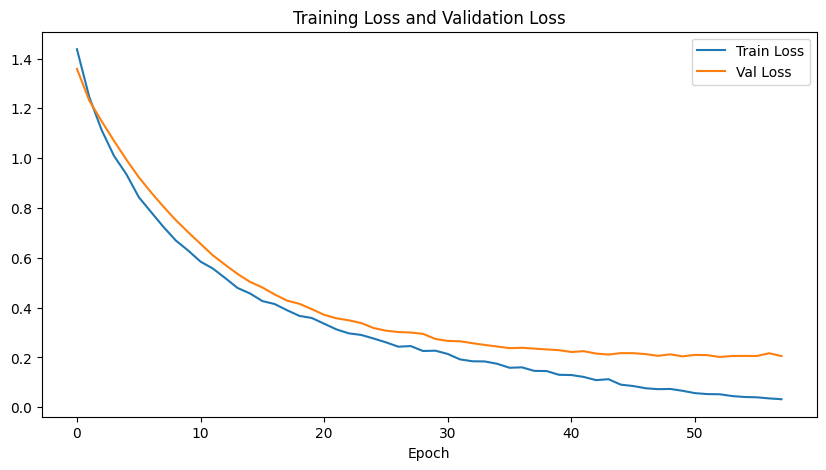

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --------- Multimodal Transformer Model ---------

class TransformerEncoderBlock(nn.Module):
    """
    A standard Transformer encoder block consisting of:
    - Multi-head self-attention
    - LayerNorm + residual connection
    - Feed-forward network (FFN)
    - LayerNorm + residual connection

    Parameters
    ----------
    embed_dim : int
        Dimensionality of the embedding features.
    num_heads : int
        Number of attention heads.
    dropout : float, optional
        Dropout probability for attention and FFN.
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Forward pass through the encoder block.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch, seq_len, embed_dim).

        Returns
        -------
        torch.Tensor
            Output tensor of same shape.
        """
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class CrossAttentionBlock(nn.Module):
    """
    A cross-attention block enabling interaction between two modalities.
    Used to fuse methylation and RNA feature representations.

    Parameters
    ----------
    embed_dim : int
        Feature embedding dimension.
    num_heads : int
        Number of attention heads.
    dropout : float
        Dropout probability.
    """

    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        """
        Perform cross-modal attention.

        Parameters
        ----------
        query : torch.Tensor
            Query sequence (batch, 1, embed_dim).
        key_value : torch.Tensor
            Key/value sequence from the other modality.

        Returns
        -------
        torch.Tensor
            Cross-attended representation.
        """
        attn_out, _ = self.cross_attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class MultiModalTransformer(nn.Module):
    """
    A multimodal Transformer integrating DNA methylation and RNA expression.
    Each modality is separately encoded and fused via bidirectional cross-attention.

    Parameters
    ----------
    methyl_dim : int
        Input dimension of methylation features.
    rna_dim : int
        Input dimension of RNA features.
    embed_dim : int
        Shared embedding dimension for both modalities.
    num_heads : int
        Number of attention heads.
    num_layers : int
        Number of Transformer encoder layers per modality.
    num_classes : int
        Number of output classes (e.g., PAM50 = 5).
    """
    def __init__(self, methyl_dim=500, rna_dim=50, embed_dim=128, num_heads=4, num_layers=2, num_classes=5):
        super().__init__()
        self.methyl_proj = nn.Linear(methyl_dim, embed_dim)
        self.rna_proj = nn.Linear(rna_dim, embed_dim)
        self.methyl_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.rna_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.methyl_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.rna_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.cross_attn_methyl = CrossAttentionBlock(embed_dim, num_heads)
        self.cross_attn_rna = CrossAttentionBlock(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, methyl_x, rna_x):
        """
        Forward pass of the multimodal Transformer model.

        Parameters
        ----------
        methyl_x : torch.Tensor
            Methylation input of shape (batch, methyl_dim).
        rna_x : torch.Tensor
            RNA input of shape (batch, rna_dim).

        Returns
        -------
        torch.Tensor
            Logits of shape (batch, num_classes).
        """
        batch_size = methyl_x.size(0)
        methyl_emb = self.methyl_proj(methyl_x)
        rna_emb = self.rna_proj(rna_x)
        methyl_cls = self.methyl_cls_token.expand(batch_size, -1, -1)
        rna_cls = self.rna_cls_token.expand(batch_size, -1, -1)
        methyl_seq = torch.cat([methyl_cls, methyl_emb.unsqueeze(1)], dim=1)
        rna_seq = torch.cat([rna_cls, rna_emb.unsqueeze(1)], dim=1)
        methyl_encoded = self.methyl_encoder(methyl_seq)
        rna_encoded = self.rna_encoder(rna_seq)
        methyl_cls_encoded = methyl_encoded[:, 0:1, :]
        rna_cls_encoded = rna_encoded[:, 0:1, :]
        methyl_cross = self.cross_attn_methyl(methyl_cls_encoded, rna_encoded)
        rna_cross = self.cross_attn_rna(rna_cls_encoded, methyl_encoded)
        fusion = torch.cat([methyl_cross.squeeze(1), rna_cross.squeeze(1)], dim=1)
        out = self.classifier(fusion)
        return out

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    """
    Apply PCA and scaling to methylation data, scaling to RNA data,
    and convert all arrays to PyTorch tensors.

    Parameters
    ----------
    methyl_np : numpy.ndarray
        Raw methylation matrix (samples × features).
    rna_np : numpy.ndarray
        RNA expression matrix (samples × genes).
    y_np : numpy.ndarray
        Labels.
    methyl_pca_dim : int
        Number of PCA components for methylation.

    Returns
    -------
    methyl_tensor, rna_tensor, y_tensor : torch.Tensor
        Preprocessed tensors.
    """
    # PCA Methyl
    pca = PCA(n_components=methyl_pca_dim)
    methyl_pca = pca.fit_transform(methyl_np)
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_pca)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor

# --------- Train Model ---------
def train_model(methyl_tensor, rna_tensor, y_tensor, epochs=50, batch_size=16, lr=1e-4, train_idx_a = train_idx_a, test_idx_a = test_idx_a, device=None):
    """
    Train the multimodal Transformer using predefined train/test splits.
    Includes early stopping and model checkpointing.

    Parameters
    ----------
    methyl_tensor : torch.Tensor
        Preprocessed methylation data.
    rna_tensor : torch.Tensor
        Preprocessed RNA data.
    y_tensor : torch.Tensor
        Labels.
    epochs : int
        Training epochs.
    batch_size : int
        Batch size.
    lr : float
        Learning rate.
    train_idx_a : array-like
        Train indices.
    test_idx_a : array-like
        Test indices.
    device : str, optional
        'cuda' or 'cpu'.

    Returns
    -------
    model : MultiModalTransformer
        Trained model.
    inf_acc : float
        Accuracy on the inference/test split.
    train_losses : list
        Training loss history.
    val_losses : list
        Validation loss history.
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)
    train_dataset = Subset(dataset, train_idx_a)
    inf_dataset = Subset(dataset, test_idx_a)
    # Save splits
    np.save(path+"train_idx_a1.npy", train_idx_a)
    np.save(path+"test_idx_a1.npy", test_idx_a)

    train_idx_a = np.load(path+"train_idx_a1.npy")
    test_idx_a = np.load(path+"test_idx_a1.npy")

    total_len = len(train_dataset)
    train_len = int(0.85 * total_len)
    val_len = total_len - train_len
    train_set1, val_set1 = random_split(train_dataset, [train_len, val_len], generator=g)
    np.save(path+"train_idx1.npy",  train_set1.indices)
    np.save(path+"valid_idx1.npy",  val_set1.indices)

    train_idx = np.load(path+"train_idx1.npy")
    valid_idx = np.load(path+"valid_idx1.npy")

    train_set1 = Subset(train_dataset, train_idx)
    val_set1  = Subset(train_dataset, valid_idx)
    train_loader = DataLoader(train_set1, batch_size=batch_size, shuffle=True, generator= g)
    val_loader = DataLoader(val_set1, batch_size=batch_size, shuffle=False, generator= g)
    inf_loader = DataLoader(inf_dataset, batch_size=batch_size, shuffle = False, generator= g)
    model = MultiModalTransformer(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    #best_val_loss = 0.0
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for methyl_x, rna_x, y in train_loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(methyl_x, rna_x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * methyl_x.size(0)
        train_loss = running_loss / train_len
        #val_acc = evaluate_model(model, val_loader, device)
        val_loss = evaluate_loss(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        #val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          counter = 0
          torch.save(model.state_dict(), path+"best_model11.pt")
        else:
          counter += 1
          if counter >= patience:
              print("Early stopping triggered.")
              break

    model.load_state_dict(torch.load(path+"best_model11.pt"))
    inf_acc = evaluate_model(model, inf_loader, device)
    print(f"Inf Accuracy: {inf_acc:.4f}")
    return model, inf_acc, train_losses, val_losses

# --------- validate Model ---------
def evaluate_model(model, loader, device):
    """
    Compute accuracy of the model on a dataset.

    Parameters
    ----------
    model : nn.Module
        Trained model.
    loader : DataLoader
        Evaluation DataLoader.
    device : str
        Device to run inference.

    Returns
    -------
    float
        Accuracy score.
    """
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy())

def evaluate_loss(model, loader, criterion, device):
    """
    Compute average cross-entropy loss of the model on a dataset.

    Parameters
    ----------
    model : nn.Module
        Model to evaluate.
    loader : DataLoader
        Dataset loader.
    criterion : loss function
        Loss function (e.g. CrossEntropyLoss).
    device : str
        Device to run inference.

    Returns
    -------
    float
        Mean loss over dataset.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            loss = criterion(out, y)
            total_loss += loss.item() * methyl_x.size(0)
            total_samples += methyl_x.size(0)
    return total_loss / total_samples


# --------- Main flow---------
def main_train_and_plot(methyl_np, rna_np, y_np):
    """
    Pipeline function:
    - Preprocess multimodal data
    - Train model
    - Plot train/validation loss curves

    Parameters
    ----------
    methyl_np : numpy.ndarray
        Raw methylation matrix.
    rna_np : numpy.ndarray
        Raw RNA matrix.
    y_np : numpy.ndarray
        Labels.

    Returns
    -------
    model : MultiModalTransformer
        Trained model.
    """
    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, y_np)
    model, inf_acc, train_losses, val_losses = train_model(methyl_tensor, rna_tensor, y_tensor,
                                                               epochs=100, batch_size=16, lr=1e-5, train_idx_a = train_idx_a, test_idx_a = test_idx_a)
    print(f"Inf Accuracy: {inf_acc:.4f}")
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Training Loss and Validation Loss")
    plt.show()
    return model


model = main_train_and_plot(methyl_scaled, rna_selected, y_label)

Load and Validate model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --------- Multimodal Transformer Model ---------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        attn_out, _ = self.cross_attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class MultiModalTransformer(nn.Module):
    def __init__(self, methyl_dim=500, rna_dim=50, embed_dim=128, num_heads=4, num_layers=2, num_classes=5):
        super().__init__()
        self.methyl_proj = nn.Linear(methyl_dim, embed_dim)
        self.rna_proj = nn.Linear(rna_dim, embed_dim)
        self.methyl_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.rna_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.methyl_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.rna_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.cross_attn_methyl = CrossAttentionBlock(embed_dim, num_heads)
        self.cross_attn_rna = CrossAttentionBlock(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, methyl_x, rna_x):
        batch_size = methyl_x.size(0)
        methyl_emb = self.methyl_proj(methyl_x)
        rna_emb = self.rna_proj(rna_x)
        methyl_cls = self.methyl_cls_token.expand(batch_size, -1, -1)
        rna_cls = self.rna_cls_token.expand(batch_size, -1, -1)
        methyl_seq = torch.cat([methyl_cls, methyl_emb.unsqueeze(1)], dim=1)
        rna_seq = torch.cat([rna_cls, rna_emb.unsqueeze(1)], dim=1)
        methyl_encoded = self.methyl_encoder(methyl_seq)
        rna_encoded = self.rna_encoder(rna_seq)
        methyl_cls_encoded = methyl_encoded[:, 0:1, :]
        rna_cls_encoded = rna_encoded[:, 0:1, :]
        methyl_cross = self.cross_attn_methyl(methyl_cls_encoded, rna_encoded)
        rna_cross = self.cross_attn_rna(rna_cls_encoded, methyl_encoded)
        fusion = torch.cat([methyl_cross.squeeze(1), rna_cross.squeeze(1)], dim=1)
        out = self.classifier(fusion)
        return out

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    # PCA Methyl
    pca = PCA(n_components=methyl_pca_dim)
    methyl_pca = pca.fit_transform(methyl_np)
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_pca)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor, pca

# --------- Load Model ---------
def load_model(methyl_tensor, rna_tensor, y_tensor, epochs=50, batch_size=16, lr=1e-4, device=None):
    """
    Load a previously trained multimodal Transformer model from disk and
    evaluate it on the predefined train/validation/test splits.

    This function:
    1. Reconstructs the dataset and corresponding DataLoaders using saved indices.
    2. Initializes the Multimodal Transformer architecture.
    3. Loads the saved model weights (best checkpoint).
    4. Evaluates the model on the inference/test dataset using accuracy, precision,
       recall, and F1-score (multiclass, per-class metrics).
    5. Returns the loaded model and evaluation results.

    Parameters
    ----------
    methyl_tensor : torch.Tensor
        Preprocessed methylation feature tensor of shape (N_samples, methyl_dim).
    rna_tensor : torch.Tensor
        Preprocessed RNA expression tensor of shape (N_samples, rna_dim).
    y_tensor : torch.Tensor
        Ground truth class labels.
    epochs : int, optional
        Not used for training here, but kept for interface consistency.
    batch_size : int, optional
        Batch size for DataLoader evaluation.
    lr : float, optional
        Learning rate (unused in evaluation mode).
    device : str, optional
        Compute device ("cuda" or "cpu"). If None, automatically selected.

    Returns
    -------
    model : MultiModalTransformer
        The model instance with loaded weights.
    inf_acc : float
        Accuracy on the inference/test dataset.
    inf_precision : numpy.ndarray
        Per-class precision values (multiclass).
    inf_recall : numpy.ndarray
        Per-class recall values (multiclass).
    inf_f1 : numpy.ndarray
        Per-class F1-score values (multiclass).

    Notes
    -----
    - This function assumes the following files already exist under `path`:
        * train_idx_a1.npy
        * test_idx_a1.npy
        * train_idx1.npy
        * valid_idx1.npy
        * best_model11.pt
    - The global variables `path` and `g` (random generator) must be defined.
    """

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)

    train_idx_a = np.load(path+"train_idx_a1.npy")
    test_idx_a = np.load(path+"test_idx_a1.npy")
    train_idx = np.load(path+"train_idx1.npy")
    valid_idx = np.load(path+"valid_idx1.npy")

    train_dataset = Subset(dataset, train_idx_a)
    inf_dataset = Subset(dataset, test_idx_a)
    train_set1 = Subset(train_dataset, train_idx)
    val_set1  = Subset(train_dataset, valid_idx)

    train_loader = DataLoader(train_set1, batch_size=batch_size, shuffle=True, generator= g)
    val_loader = DataLoader(val_set1, batch_size=batch_size, shuffle=False, generator= g)
    inf_loader = DataLoader(inf_dataset, batch_size=batch_size, shuffle=False, generator= g)
    model = MultiModalTransformer(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()


    #model.load_state_dict(torch.load(path+"model_artifact/Transformer/best_model1.pt"))
    model.load_state_dict(torch.load(path+"best_model11.pt"))
    inf_acc, inf_precision, inf_recall, inf_f1 = evaluate_model(model, inf_loader, device)
    print(f"Inf Accuracy: {inf_acc:.4f}")
    print(f"Inf Precision: {inf_precision}")
    print(f"Inf Recall: {inf_recall}")
    print(f"Inf F1: {inf_f1}")
    return model, inf_acc, inf_precision, inf_recall, inf_f1

# --------- validate Model ---------
def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()),  precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            loss = criterion(out, y)
            total_loss += loss.item() * methyl_x.size(0)
            total_samples += methyl_x.size(0)
    return total_loss / total_samples

# --------- Main flow---------
def main_load_and_val(methyl_np, rna_np, y_np):
    methyl_tensor, rna_tensor, y_tensor, pca_meth = preprocess_data(methyl_np, rna_np, y_np)
    model, inf_acc, inf_precision, inf_recall, inf_f1 = load_model(methyl_tensor, rna_tensor, y_tensor,
                                                               epochs=100, batch_size=16, lr=1e-5)
    print(f"Inf Accuracy: {inf_acc:.4f}")
    print(f"Inf Precision: {inf_precision}")
    print(f"Inf Recall: {inf_recall}")
    print(f"Inf F1: {inf_f1}")
    return model, methyl_tensor, rna_tensor, y_tensor, pca_meth


model, methyl_tensor, rna_tensor, y_tensor, pca_meth = main_load_and_val(methyl_scaled, rna_selected, y_label)

Inf Accuracy: 0.8879
Inf Precision: [0.90322581 0.82608696 0.6        1.        ]
Inf Recall: [0.96551724 0.73076923 0.5        1.        ]
Inf F1: [0.93333333 0.7755102  0.54545455 1.        ]
Inf Accuracy: 0.8879
Inf Precision: [0.90322581 0.82608696 0.6        1.        ]
Inf Recall: [0.96551724 0.73076923 0.5        1.        ]
Inf F1: [0.93333333 0.7755102  0.54545455 1.        ]


###### SHAP VALUE

/tmp/ipython-input-270327299.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_methyl, test_methyl.cpu().numpy(), feature_names=[f"methyl_{i}" for i in range(shap_vals_methyl.shape[1])])


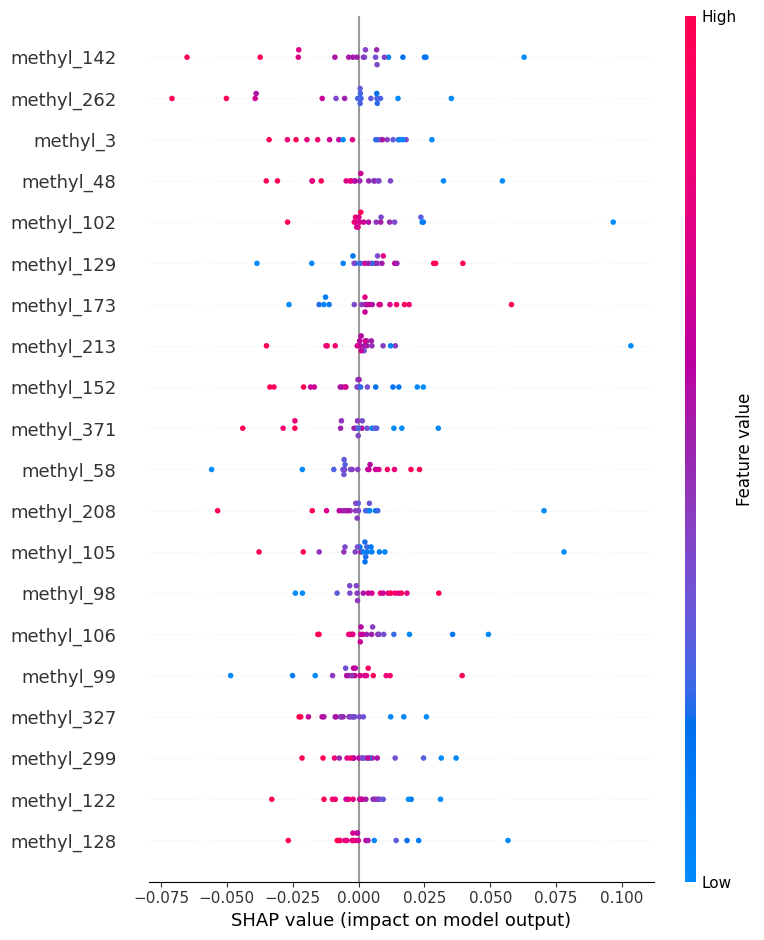

/tmp/ipython-input-270327299.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_rna, test_rna.cpu().numpy(), feature_names=[f"rna_{i}" for i in range(shap_vals_rna.shape[1])])


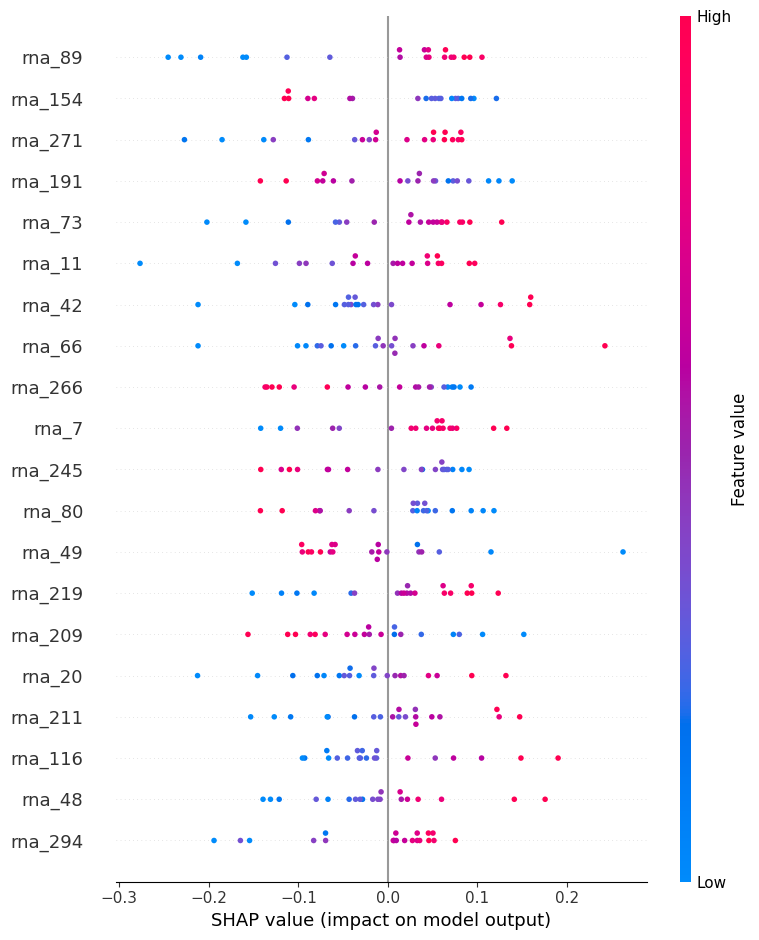

In [ ]:
import shap
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

# take a small portion of data
background_methyl = methyl_tensor[:100].to(device)
background_rna = rna_tensor[:100].to(device)


#explainer = shap.DeepExplainer(model, [background_methyl, background_rna])
explainer = shap.GradientExplainer(model, [background_methyl, background_rna])


# get some sample to explain
test_methyl = methyl_tensor[100:120].to(device)
test_rna = rna_tensor[100:120].to(device)
shap_values = explainer.shap_values([test_methyl, test_rna])

class_idx = 0
shap_vals_methyl = shap_values[0][:, :, class_idx]  # shape (20, 500)
shap_vals_rna = shap_values[1][:, :, class_idx]    # shape (20, 300)
import shap

# methylation features
shap.summary_plot(shap_vals_methyl, test_methyl.cpu().numpy(), feature_names=[f"methyl_{i}" for i in range(shap_vals_methyl.shape[1])])

# RNA features
shap.summary_plot(shap_vals_rna, test_rna.cpu().numpy(), feature_names=[f"rna_{i}" for i in range(shap_vals_rna.shape[1])])


In [ ]:
global_shap_rna = np.mean(np.abs(shap_vals_rna), axis=0)  # shape (feature_dim,)
df_rna_shap = pd.DataFrame({
    'feature': rna_selected_columns,
    'avg_abs_shap': global_shap_rna
})
df_rna_shap = df_rna_shap.sort_values(by='avg_abs_shap', ascending=False).reset_index(drop=True)

In [ ]:
W = pca_meth.components_.T  # shape (d, k)
shap_vals_orig = np.dot(shap_vals_methyl, W.T)  # Shape (num_samples, d)
global_shap_methyl = np.mean(np.abs(shap_vals_orig), axis=0)  # shape (feature_dim,)
df_methyl_shap = pd.DataFrame({
    'feature': methyl_aligned.columns,
    'avg_abs_shap': global_shap_methyl
})
df_methyl_shap = df_methyl_shap.sort_values(by='avg_abs_shap', ascending=False).reset_index(drop=True)


In [ ]:
### Save Shap Value for Cross Attention Transformer Model
df_methyl_shap.to_csv(path+"df_methyl_shap_tf1.csv")
df_rna_shap.to_csv(path+"df_rna_shap_tf1.csv")

##### 3.2 Cross Validation - Loss


Fold 1
Epoch 1, Train Loss: 1.3483, Val Loss: 1.2639
Epoch 2, Train Loss: 1.2068, Val Loss: 1.1508
Epoch 3, Train Loss: 1.0990, Val Loss: 1.0757
Epoch 4, Train Loss: 1.0321, Val Loss: 1.0071
Epoch 5, Train Loss: 0.9714, Val Loss: 0.9330
Epoch 6, Train Loss: 0.9050, Val Loss: 0.8583
Epoch 7, Train Loss: 0.8499, Val Loss: 0.7913
Epoch 8, Train Loss: 0.8010, Val Loss: 0.7295
Epoch 9, Train Loss: 0.7407, Val Loss: 0.6780
Epoch 10, Train Loss: 0.7145, Val Loss: 0.6340
Epoch 11, Train Loss: 0.6617, Val Loss: 0.5970
Epoch 12, Train Loss: 0.6337, Val Loss: 0.5625
Epoch 13, Train Loss: 0.5944, Val Loss: 0.5341
Epoch 14, Train Loss: 0.5549, Val Loss: 0.5074
Epoch 15, Train Loss: 0.5311, Val Loss: 0.4841
Epoch 16, Train Loss: 0.4999, Val Loss: 0.4629
Epoch 17, Train Loss: 0.4759, Val Loss: 0.4445
Epoch 18, Train Loss: 0.4715, Val Loss: 0.4281
Epoch 19, Train Loss: 0.4352, Val Loss: 0.4125
Epoch 20, Train Loss: 0.4179, Val Loss: 0.3980
Epoch 21, Train Loss: 0.3860, Val Loss: 0.3840
Epoch 22, Trai

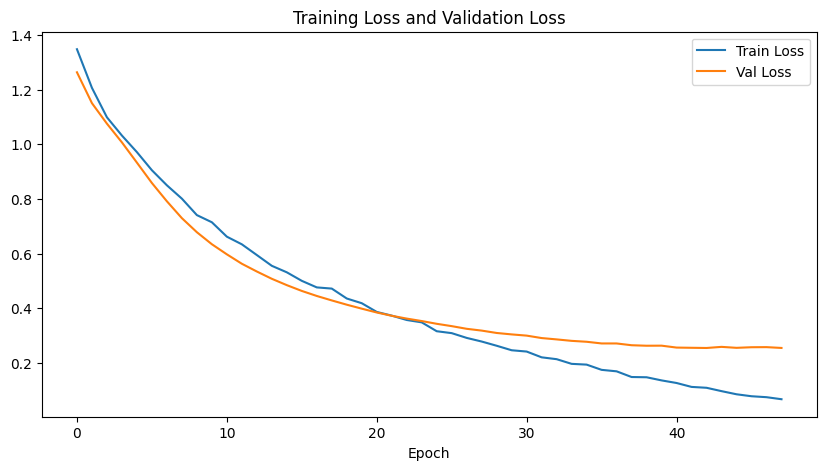


Fold 2
Epoch 1, Train Loss: 1.2740, Val Loss: 1.1830
Epoch 2, Train Loss: 1.1612, Val Loss: 1.1146
Epoch 3, Train Loss: 1.0846, Val Loss: 1.0606
Epoch 4, Train Loss: 1.0037, Val Loss: 0.9937
Epoch 5, Train Loss: 0.9440, Val Loss: 0.9187
Epoch 6, Train Loss: 0.8767, Val Loss: 0.8479
Epoch 7, Train Loss: 0.8126, Val Loss: 0.7761
Epoch 8, Train Loss: 0.7495, Val Loss: 0.7168
Epoch 9, Train Loss: 0.6939, Val Loss: 0.6621
Epoch 10, Train Loss: 0.6495, Val Loss: 0.6166
Epoch 11, Train Loss: 0.6010, Val Loss: 0.5798
Epoch 12, Train Loss: 0.5557, Val Loss: 0.5488
Epoch 13, Train Loss: 0.5219, Val Loss: 0.5218
Epoch 14, Train Loss: 0.4833, Val Loss: 0.5035
Epoch 15, Train Loss: 0.4459, Val Loss: 0.4848
Epoch 16, Train Loss: 0.4216, Val Loss: 0.4740
Epoch 17, Train Loss: 0.4005, Val Loss: 0.4605
Epoch 18, Train Loss: 0.3618, Val Loss: 0.4529
Epoch 19, Train Loss: 0.3618, Val Loss: 0.4479
Epoch 20, Train Loss: 0.3400, Val Loss: 0.4419
Epoch 21, Train Loss: 0.3162, Val Loss: 0.4345
Epoch 22, Trai

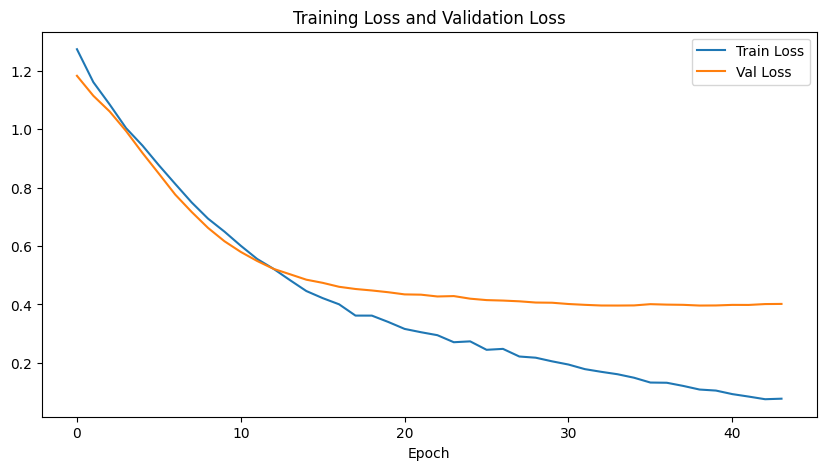


Fold 3
Epoch 1, Train Loss: 1.3482, Val Loss: 1.2400
Epoch 2, Train Loss: 1.2095, Val Loss: 1.1366
Epoch 3, Train Loss: 1.1324, Val Loss: 1.0637
Epoch 4, Train Loss: 1.0588, Val Loss: 0.9991
Epoch 5, Train Loss: 1.0078, Val Loss: 0.9311
Epoch 6, Train Loss: 0.9446, Val Loss: 0.8610
Epoch 7, Train Loss: 0.8833, Val Loss: 0.7981
Epoch 8, Train Loss: 0.8180, Val Loss: 0.7349
Epoch 9, Train Loss: 0.7460, Val Loss: 0.6800
Epoch 10, Train Loss: 0.7049, Val Loss: 0.6318
Epoch 11, Train Loss: 0.6480, Val Loss: 0.5910
Epoch 12, Train Loss: 0.6141, Val Loss: 0.5524
Epoch 13, Train Loss: 0.5792, Val Loss: 0.5139
Epoch 14, Train Loss: 0.5463, Val Loss: 0.4841
Epoch 15, Train Loss: 0.5133, Val Loss: 0.4557
Epoch 16, Train Loss: 0.4864, Val Loss: 0.4283
Epoch 17, Train Loss: 0.4481, Val Loss: 0.4066
Epoch 18, Train Loss: 0.4195, Val Loss: 0.3860
Epoch 19, Train Loss: 0.4006, Val Loss: 0.3719
Epoch 20, Train Loss: 0.3895, Val Loss: 0.3560
Epoch 21, Train Loss: 0.3652, Val Loss: 0.3453
Epoch 22, Trai

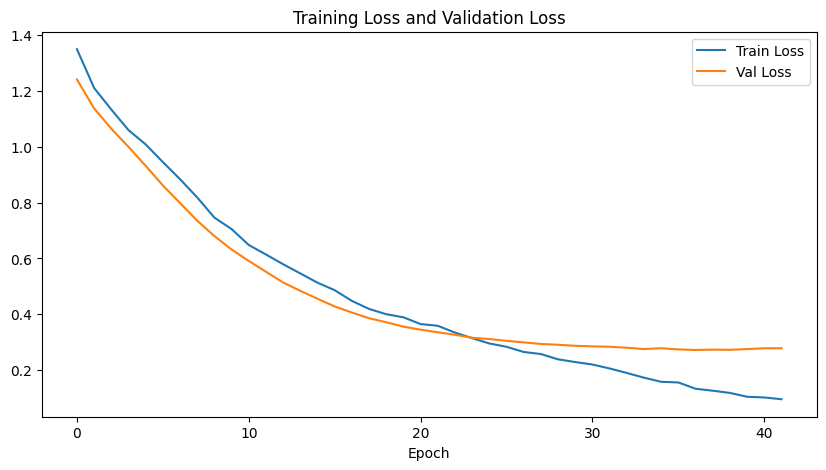


Fold 4
Epoch 1, Train Loss: 1.2852, Val Loss: 1.1813
Epoch 2, Train Loss: 1.1548, Val Loss: 1.0822
Epoch 3, Train Loss: 1.0823, Val Loss: 1.0159
Epoch 4, Train Loss: 1.0147, Val Loss: 0.9581
Epoch 5, Train Loss: 0.9507, Val Loss: 0.8992
Epoch 6, Train Loss: 0.8819, Val Loss: 0.8379
Epoch 7, Train Loss: 0.8084, Val Loss: 0.7793
Epoch 8, Train Loss: 0.7456, Val Loss: 0.7246
Epoch 9, Train Loss: 0.6824, Val Loss: 0.6784
Epoch 10, Train Loss: 0.6360, Val Loss: 0.6349
Epoch 11, Train Loss: 0.5958, Val Loss: 0.5936
Epoch 12, Train Loss: 0.5545, Val Loss: 0.5582
Epoch 13, Train Loss: 0.5240, Val Loss: 0.5224
Epoch 14, Train Loss: 0.4921, Val Loss: 0.4932
Epoch 15, Train Loss: 0.4644, Val Loss: 0.4701
Epoch 16, Train Loss: 0.4393, Val Loss: 0.4433
Epoch 17, Train Loss: 0.4177, Val Loss: 0.4236
Epoch 18, Train Loss: 0.4020, Val Loss: 0.4044
Epoch 19, Train Loss: 0.3808, Val Loss: 0.3919
Epoch 20, Train Loss: 0.3499, Val Loss: 0.3809
Epoch 21, Train Loss: 0.3456, Val Loss: 0.3621
Epoch 22, Trai

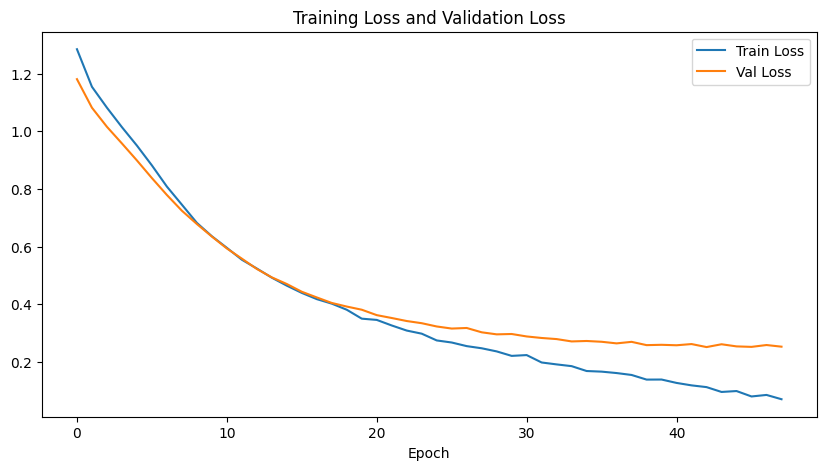


Fold 5
Epoch 1, Train Loss: 1.3956, Val Loss: 1.3184
Epoch 2, Train Loss: 1.2768, Val Loss: 1.2086
Epoch 3, Train Loss: 1.1706, Val Loss: 1.1274
Epoch 4, Train Loss: 1.0998, Val Loss: 1.0592
Epoch 5, Train Loss: 1.0191, Val Loss: 0.9937
Epoch 6, Train Loss: 0.9678, Val Loss: 0.9344
Epoch 7, Train Loss: 0.9029, Val Loss: 0.8810
Epoch 8, Train Loss: 0.8423, Val Loss: 0.8355
Epoch 9, Train Loss: 0.7995, Val Loss: 0.7979
Epoch 10, Train Loss: 0.7496, Val Loss: 0.7653
Epoch 11, Train Loss: 0.7173, Val Loss: 0.7337
Epoch 12, Train Loss: 0.6781, Val Loss: 0.7045
Epoch 13, Train Loss: 0.6472, Val Loss: 0.6770
Epoch 14, Train Loss: 0.6057, Val Loss: 0.6501
Epoch 15, Train Loss: 0.5773, Val Loss: 0.6262
Epoch 16, Train Loss: 0.5366, Val Loss: 0.6057
Epoch 17, Train Loss: 0.5264, Val Loss: 0.5857
Epoch 18, Train Loss: 0.4761, Val Loss: 0.5692
Epoch 19, Train Loss: 0.4558, Val Loss: 0.5550
Epoch 20, Train Loss: 0.4434, Val Loss: 0.5415
Epoch 21, Train Loss: 0.4080, Val Loss: 0.5286
Epoch 22, Trai

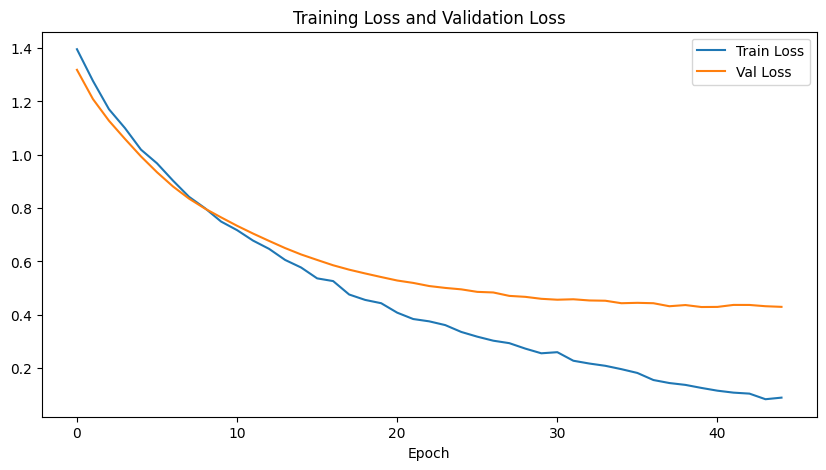

Average Inference Accuracy: 0.8950
Average Inference Precision: [0.91575144 0.79406926 0.93333333 0.95873016]
Average Inference Recall: [0.94476859 0.8157231  0.53222222 0.98888889]
Average Inference F1: [0.92933618 0.80136522 0.66879121 0.97252101]
Accuracy:  [0.9345794392523364, 0.8317757009345794, 0.8878504672897196, 0.8867924528301887, 0.9339622641509434]
Precision:  <function precision_score at 0x7dfae59fd300>
Recall:  [array([0.9375    , 0.93548387, 0.75      , 1.        ]), array([0.94339623, 0.61538462, 0.44444444, 1.        ]), array([0.9137931, 0.84     , 0.4      , 1.       ]), array([0.96363636, 0.86956522, 0.4       , 0.94444444]), array([0.96551724, 0.81818182, 0.66666667, 1.        ])]
F1:  [array([0.95238095, 0.90625   , 0.85714286, 0.94117647]), array([0.88495575, 0.66666667, 0.61538462, 0.95      ]), array([0.92173913, 0.79245283, 0.5       , 1.        ]), array([0.94642857, 0.78431373, 0.57142857, 0.97142857]), array([0.94117647, 0.85714286, 0.8       , 1.        ])]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

# --------- Multimodal Transformer Model ---------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        attn_out, _ = self.cross_attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class MultiModalTransformer(nn.Module):
    def __init__(self, methyl_dim=500, rna_dim=50, embed_dim=128, num_heads=4, num_layers=2, num_classes=4):
        super().__init__()
        self.methyl_proj = nn.Linear(methyl_dim, embed_dim)
        self.rna_proj = nn.Linear(rna_dim, embed_dim)
        self.methyl_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.rna_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.methyl_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.rna_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.cross_attn_methyl = CrossAttentionBlock(embed_dim, num_heads)
        self.cross_attn_rna = CrossAttentionBlock(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, methyl_x, rna_x):
        batch_size = methyl_x.size(0)
        methyl_emb = self.methyl_proj(methyl_x)
        rna_emb = self.rna_proj(rna_x)
        methyl_cls = self.methyl_cls_token.expand(batch_size, -1, -1)
        rna_cls = self.rna_cls_token.expand(batch_size, -1, -1)
        methyl_seq = torch.cat([methyl_cls, methyl_emb.unsqueeze(1)], dim=1)
        rna_seq = torch.cat([rna_cls, rna_emb.unsqueeze(1)], dim=1)
        methyl_encoded = self.methyl_encoder(methyl_seq)
        rna_encoded = self.rna_encoder(rna_seq)
        methyl_cls_encoded = methyl_encoded[:, 0:1, :]
        rna_cls_encoded = rna_encoded[:, 0:1, :]
        methyl_cross = self.cross_attn_methyl(methyl_cls_encoded, rna_encoded)
        rna_cross = self.cross_attn_rna(rna_cls_encoded, methyl_encoded)
        fusion = torch.cat([methyl_cross.squeeze(1), rna_cross.squeeze(1)], dim=1)
        out = self.classifier(fusion)
        return out

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    """
    Preprocess methylation and RNA data using PCA and z-score scaling.

    Parameters
    ----------
    methyl_np : ndarray
        Raw methylation matrix.
    rna_np : ndarray
        Raw RNA matrix.
    y_np : ndarray
        Label array.
    methyl_pca_dim : int
        PCA components for methylation.

    Returns
    -------
    methyl_tensor : torch.Tensor
    rna_tensor : torch.Tensor
    y_tensor : torch.Tensor
    """
    # PCA Methyl
    pca = PCA(n_components=methyl_pca_dim)
    methyl_pca = pca.fit_transform(methyl_np)
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_pca)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor

# --------- Train Model ---------
def train_model(methyl_tensor, rna_tensor, y_tensor, epochs=50, batch_size=16, lr=1e-4, train_idx=train_idx, test_idx=test_idx, device=None):
    """
    Perform 5-fold cross-validation using the multimodal cross-attention Transformer.

    Each fold:
      • Splits train/validation/test using KFold
      • Trains the model with early stopping
      • Evaluates accuracy, precision, recall, and F1
      • Records loss curves for each fold

    Parameters
    ----------
    methyl_tensor : torch.Tensor
        Preprocessed methylation tensor.
    rna_tensor : torch.Tensor
        Preprocessed RNA tensor.
    y_tensor : torch.Tensor
        Label tensor.
    epochs : int
        Training epochs per fold.
    batch_size : int
        Mini-batch size.
    lr : float
        Learning rate.
    device : str or None
        "cuda" or "cpu". Auto-select if None.

    Returns
    -------
    model : MultiModalTransformer
        Final trained model (last fold).
    accuracy_scores : list of float
    precision_scores : list of ndarray
    recall_scores : list of ndarray
    f1_scores : list of ndarray
    train_losses : list
        Loss curve from last fold.
    val_losses : list
        Validation loss curve from last fold.
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    g = torch.Generator().manual_seed(42)
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
      print(f"\nFold {fold + 1}")

      # Use Subset to split dataset
      train_dataset = Subset(dataset, train_idx)
      inf_dataset = Subset(dataset, val_idx)

      total_len = len(train_dataset)
      train_len = int(0.85 * total_len)
      val_len = total_len - train_len
      train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator = g)
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator = g)
      val_loader = DataLoader(val_subset, batch_size=batch_size, generator = g)
      inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator = g)
      model = MultiModalTransformer(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1]).to(device)
      optimizer = optim.AdamW(model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()
      #best_val_loss = 0.0
      best_val_loss = float('inf')
      patience = 5
      counter = 0
      train_losses, val_losses = [], []
      for epoch in range(epochs):
          model.train()
          running_loss = 0.0
          for methyl_x, rna_x, y in train_loader:
              methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
              optimizer.zero_grad()
              pred = model(methyl_x, rna_x)
              loss = criterion(pred, y)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
              running_loss += loss.item() * methyl_x.size(0)
          train_loss = running_loss / train_len
          #val_acc = evaluate_model(model, val_loader, device)
          val_loss = evaluate_loss(model, val_loader, criterion, device)
          train_losses.append(train_loss)
          #val_accuracies.append(val_acc)
          val_losses.append(val_loss)
          print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

          if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model12.pt")
          else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

      model.load_state_dict(torch.load("best_model12.pt"))
      inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
      print(f"Inference Accuracy: {inf_acc:.4f}")
      print(f"Inference Precision: {inf_pre}")
      print(f"Inference Recall: {inf_rec}")
      print(f"Inference F1: {inf_f1}")
      accuracy_scores.append(inf_acc)
      precision_scores.append(inf_pre)
      recall_scores.append(inf_rec)
      f1_scores.append(inf_f1)

      plt.figure(figsize=(10,5))
      plt.plot(train_losses, label="Train Loss")
      plt.plot(val_losses, label="Val Loss")
      plt.xlabel("Epoch")
      plt.legend()
      plt.title("Training Loss and Validation Loss")
      plt.show()
    print(f"Average Inference Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average Inference Precision: {np.mean(precision_scores, axis=0)}")
    print(f"Average Inference Recall: {np.mean(recall_scores, axis=0)}")
    print(f"Average Inference F1: {np.mean(f1_scores, axis=0)}")
    return model, accuracy_scores, precision_score, recall_scores, f1_scores, train_losses, val_losses

# --------- validate Model ---------
def evaluate_model(model, loader, device):
    """
    Evaluate a model on a dataset and compute multi-class metrics.

    Returns accuracy, per-class precision, recall, and F1.

    Parameters
    ----------
    model : nn.Module
    loader : DataLoader
    device : str

    Returns
    -------
    accuracy : float
    precision : ndarray
    recall : ndarray
    f1 : ndarray
    """
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)

def evaluate_loss(model, loader, criterion, device):
    """
    Compute mean cross-entropy loss over a dataset.

    Parameters
    ----------
    model : nn.Module
    loader : DataLoader
    criterion : loss function
    device : str

    Returns
    -------
    float
        Average loss.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            loss = criterion(out, y)
            total_loss += loss.item() * methyl_x.size(0)
            total_samples += methyl_x.size(0)
    return total_loss / total_samples


# --------- Main flow---------
def main_train_and_plot(methyl_np, rna_np, y_np, train_idx, test_idx):
    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, y_np)
    model, inf_acc, inf_pre, inf_rec, inf_f1, train_losses, val_losses = train_model(methyl_tensor, rna_tensor, y_tensor,
                                                                epochs = 100, batch_size=16, lr=1e-5,
                                                           train_idx = train_idx, test_idx = test_idx)
    """
    Full pipeline for:
      1. Data preprocessing
      2. k-fold cross-validation training
      3. Printing evaluation metrics

    Parameters
    ----------
    methyl_np, rna_np : ndarray
        Raw modality inputs.
    y_np : ndarray
        Labels.
    train_idx, test_idx : array-like
        Split indices (not used in CV internally).

    Returns
    -------
    model : MultiModalTransformer
        Trained model from the final fold.
    """

    print('Accuracy: ', inf_acc)
    print('Precision: ', inf_pre)
    print('Recall: ', inf_rec)
    print('F1: ', inf_f1)
    return model

model = main_train_and_plot(methyl_filled, rna_selected, y_label, train_idx_a, test_idx_a)

Summary: Transformer is a good architecture. Average Inference Accuracy: 0.8950

##### 3.4 Light weight with 50 features

In [ ]:
df_methyl_shap = pd.read_csv(path+"df_methyl_shap_tf1.csv")
df_rna_shap = pd.read_csv(path+"df_rna_shap_tf1.csv")

Transformer

In [ ]:
lw_try = df_methyl_shap[:25]['feature'].tolist() + df_rna_shap[:25]['feature'].tolist()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --------- Multimodal Transformer Model ---------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        attn_out, _ = self.cross_attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class MultiModalTransformer(nn.Module):
    def __init__(self, methyl_dim=500, rna_dim=50, embed_dim=128, num_heads=4, num_layers=2, num_classes=5):
        super().__init__()
        self.methyl_proj = nn.Linear(methyl_dim, embed_dim)
        self.rna_proj = nn.Linear(rna_dim, embed_dim)
        self.methyl_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.rna_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.methyl_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.rna_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.cross_attn_methyl = CrossAttentionBlock(embed_dim, num_heads)
        self.cross_attn_rna = CrossAttentionBlock(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, methyl_x, rna_x):
        batch_size = methyl_x.size(0)
        methyl_emb = self.methyl_proj(methyl_x)
        rna_emb = self.rna_proj(rna_x)
        methyl_cls = self.methyl_cls_token.expand(batch_size, -1, -1)
        rna_cls = self.rna_cls_token.expand(batch_size, -1, -1)
        methyl_seq = torch.cat([methyl_cls, methyl_emb.unsqueeze(1)], dim=1)
        rna_seq = torch.cat([rna_cls, rna_emb.unsqueeze(1)], dim=1)
        methyl_encoded = self.methyl_encoder(methyl_seq)
        rna_encoded = self.rna_encoder(rna_seq)
        methyl_cls_encoded = methyl_encoded[:, 0:1, :]
        rna_cls_encoded = rna_encoded[:, 0:1, :]
        methyl_cross = self.cross_attn_methyl(methyl_cls_encoded, rna_encoded)
        rna_cross = self.cross_attn_rna(rna_cls_encoded, methyl_encoded)
        fusion = torch.cat([methyl_cross.squeeze(1), rna_cross.squeeze(1)], dim=1)
        out = self.classifier(fusion)
        return out

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):

    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_np)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor

# --------- Train Model ---------
def train_model(methyl_tensor, rna_tensor, y_tensor, epochs=50, batch_size=16, lr=1e-4, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)

    train_idx_a = np.load(path+"train_idx_a.npy")
    test_idx_a = np.load(path+"test_idx_a.npy")
    train_idx = np.load(path+"train_idx.npy")
    valid_idx = np.load(path+"valid_idx.npy")

    train_dataset = Subset(dataset, train_idx_a)
    inf_dataset = Subset(dataset, test_idx_a)
    train_set = Subset(train_dataset, train_idx)
    val_set  = Subset(train_dataset, valid_idx)

    total_len = len(train_dataset)
    train_len = len(train_set)
    val_len = len(val_set)
    #train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=g)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator= g)
    val_loader = DataLoader(val_set, batch_size=batch_size, generator= g)
    inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator= g)
    model = MultiModalTransformer(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    #best_val_loss = 0.0
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for methyl_x, rna_x, y in train_loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(methyl_x, rna_x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * methyl_x.size(0)
        train_loss = running_loss / train_len
        #val_acc = evaluate_model(model, val_loader, device)
        val_loss = evaluate_loss(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        #val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          counter = 0
          torch.save(model.state_dict(), path+"best_model1_lw.pt")
        else:
          counter += 1
          if counter >= patience:
              print("Early stopping triggered.")
              break

    model.load_state_dict(torch.load(path+"best_model1_lw.pt"))
    inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
    print(f"Inf Accuracy: {inf_acc:.4f}")
    print(f"Inf Precision: {inf_pre}")
    print(f"Inf Recall: {inf_rec}")
    print(f"Inf F1: {inf_f1}")
    return model, inf_acc, inf_pre, inf_rec, inf_f1, train_losses, val_losses

# --------- validate Model ---------
def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            loss = criterion(out, y)
            total_loss += loss.item() * methyl_x.size(0)
            total_samples += methyl_x.size(0)
    return total_loss / total_samples


LightWeight Features

In [ ]:
lw_try = df_methyl_shap[:25]['feature'].tolist() + df_rna_shap[:25]['feature'].tolist()
lw_try

['cg13857025',
 'cg16448401',
 'cg23888215',
 'cg21192063',
 'cg25367206',
 'cg21383495',
 'cg02773050',
 'cg22239213',
 'cg25977493',
 'cg16962683',
 'cg01200585',
 'cg06156376',
 'cg20430749',
 'cg17739279',
 'cg01856525',
 'cg13131339',
 'cg19558029',
 'cg13948082',
 'cg02287817',
 'cg25777549',
 'cg19657945',
 'cg26672794',
 'cg04198215',
 'cg05508084',
 'cg15791180',
 'ANKRD30A',
 'CDCA3',
 'GREB1',
 'SKA1',
 'WDR19',
 'IGFBP4',
 'E2F3',
 'KRT16',
 'CENPE',
 'CPEB2',
 'NCAPG',
 'FAM136A',
 'NUDT12',
 'ADAMTS15',
 'DYNLRB2',
 'KCNK5',
 'MAPK4',
 'MTHFD1L',
 'WNT6',
 'RARA',
 'DONSON',
 'RGMA',
 'DACH1',
 'PTX3',
 'FAM83D']

Epoch 1, Train Loss: 1.5517, Val Loss: 1.3895
Epoch 2, Train Loss: 1.3363, Val Loss: 1.2031
Epoch 3, Train Loss: 1.1941, Val Loss: 1.0920
Epoch 4, Train Loss: 1.1145, Val Loss: 1.0189
Epoch 5, Train Loss: 1.0304, Val Loss: 0.9600
Epoch 6, Train Loss: 0.9598, Val Loss: 0.8979
Epoch 7, Train Loss: 0.8970, Val Loss: 0.8491
Epoch 8, Train Loss: 0.8359, Val Loss: 0.7989
Epoch 9, Train Loss: 0.7788, Val Loss: 0.7561
Epoch 10, Train Loss: 0.7227, Val Loss: 0.7216
Epoch 11, Train Loss: 0.6704, Val Loss: 0.6798
Epoch 12, Train Loss: 0.6263, Val Loss: 0.6382
Epoch 13, Train Loss: 0.5824, Val Loss: 0.6045
Epoch 14, Train Loss: 0.5411, Val Loss: 0.5808
Epoch 15, Train Loss: 0.5037, Val Loss: 0.5454
Epoch 16, Train Loss: 0.4681, Val Loss: 0.5304
Epoch 17, Train Loss: 0.4357, Val Loss: 0.5123
Epoch 18, Train Loss: 0.4084, Val Loss: 0.5029
Epoch 19, Train Loss: 0.3963, Val Loss: 0.4793
Epoch 20, Train Loss: 0.3693, Val Loss: 0.4738
Epoch 21, Train Loss: 0.3446, Val Loss: 0.4611
Epoch 22, Train Loss: 

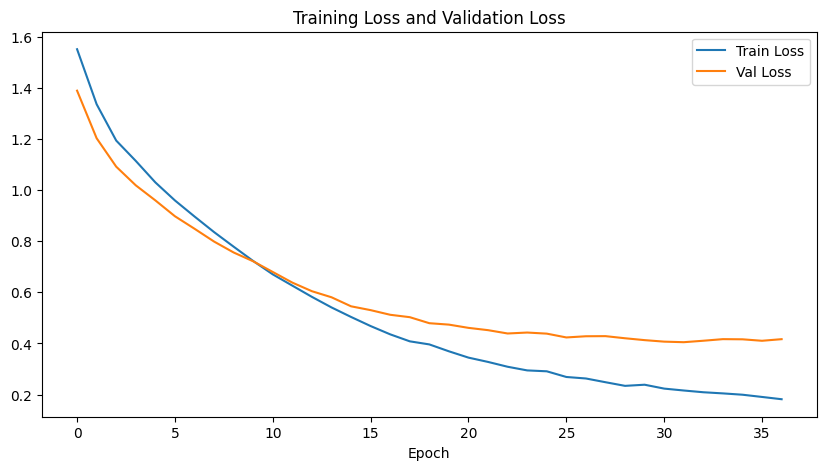

In [ ]:
methyl_scaled_lw = methyl_scaled[:, [i for (i, d)in enumerate(methyl_aligned.columns) if d in lw_try]]
rna_selected_lw = rna_selected[:, [i for (i, d)in enumerate(rna_selected_columns) if d in lw_try]]

# --------- Main flow---------
def main_train_and_plot(methyl_np, rna_np, y_np):
    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, y_np)
    model, inf_acc, inf_pre, inf_rec, inf_f1, train_losses, val_losses = train_model(methyl_tensor, rna_tensor, y_tensor,
                                                               epochs=100, batch_size=16, lr=1e-5)
    print(f"Inf Accuracy: {inf_acc:.4f}")
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Training Loss and Validation Loss")
    plt.show()
    return model


model = main_train_and_plot(methyl_scaled_lw, rna_selected_lw, y_label)

##### 3.5 Cross Validation Light Weight


Fold 1
Epoch 1, Train Loss: 1.3624, Val Loss: 1.2613
Epoch 2, Train Loss: 1.2158, Val Loss: 1.1530
Epoch 3, Train Loss: 1.1312, Val Loss: 1.0703
Epoch 4, Train Loss: 1.0533, Val Loss: 1.0022
Epoch 5, Train Loss: 1.0065, Val Loss: 0.9325
Epoch 6, Train Loss: 0.9440, Val Loss: 0.8641
Epoch 7, Train Loss: 0.8722, Val Loss: 0.8018
Epoch 8, Train Loss: 0.8307, Val Loss: 0.7467
Epoch 9, Train Loss: 0.7855, Val Loss: 0.7019
Epoch 10, Train Loss: 0.7476, Val Loss: 0.6603
Epoch 11, Train Loss: 0.7083, Val Loss: 0.6226
Epoch 12, Train Loss: 0.6579, Val Loss: 0.5884
Epoch 13, Train Loss: 0.6404, Val Loss: 0.5573
Epoch 14, Train Loss: 0.6128, Val Loss: 0.5279
Epoch 15, Train Loss: 0.5828, Val Loss: 0.5007
Epoch 16, Train Loss: 0.5540, Val Loss: 0.4726
Epoch 17, Train Loss: 0.5332, Val Loss: 0.4501
Epoch 18, Train Loss: 0.5045, Val Loss: 0.4266
Epoch 19, Train Loss: 0.4861, Val Loss: 0.4097
Epoch 20, Train Loss: 0.4646, Val Loss: 0.3909
Epoch 21, Train Loss: 0.4364, Val Loss: 0.3737
Epoch 22, Trai

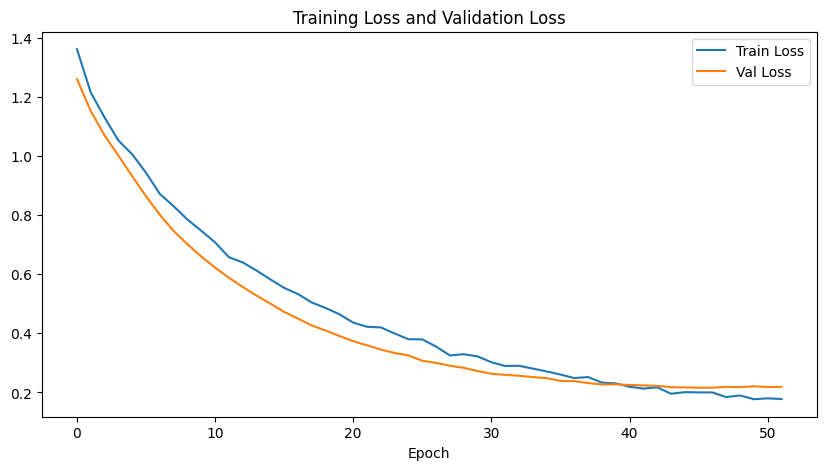


Fold 2
Epoch 1, Train Loss: 1.2985, Val Loss: 1.2675
Epoch 2, Train Loss: 1.1628, Val Loss: 1.1729
Epoch 3, Train Loss: 1.0841, Val Loss: 1.0970
Epoch 4, Train Loss: 1.0044, Val Loss: 1.0281
Epoch 5, Train Loss: 0.9461, Val Loss: 0.9605
Epoch 6, Train Loss: 0.8882, Val Loss: 0.8969
Epoch 7, Train Loss: 0.8245, Val Loss: 0.8332
Epoch 8, Train Loss: 0.7766, Val Loss: 0.7744
Epoch 9, Train Loss: 0.7279, Val Loss: 0.7132
Epoch 10, Train Loss: 0.6714, Val Loss: 0.6579
Epoch 11, Train Loss: 0.6331, Val Loss: 0.6110
Epoch 12, Train Loss: 0.5909, Val Loss: 0.5612
Epoch 13, Train Loss: 0.5493, Val Loss: 0.5226
Epoch 14, Train Loss: 0.5292, Val Loss: 0.4868
Epoch 15, Train Loss: 0.4972, Val Loss: 0.4520
Epoch 16, Train Loss: 0.4693, Val Loss: 0.4222
Epoch 17, Train Loss: 0.4350, Val Loss: 0.3934
Epoch 18, Train Loss: 0.4169, Val Loss: 0.3701
Epoch 19, Train Loss: 0.3904, Val Loss: 0.3506
Epoch 20, Train Loss: 0.3819, Val Loss: 0.3312
Epoch 21, Train Loss: 0.3714, Val Loss: 0.3156
Epoch 22, Trai

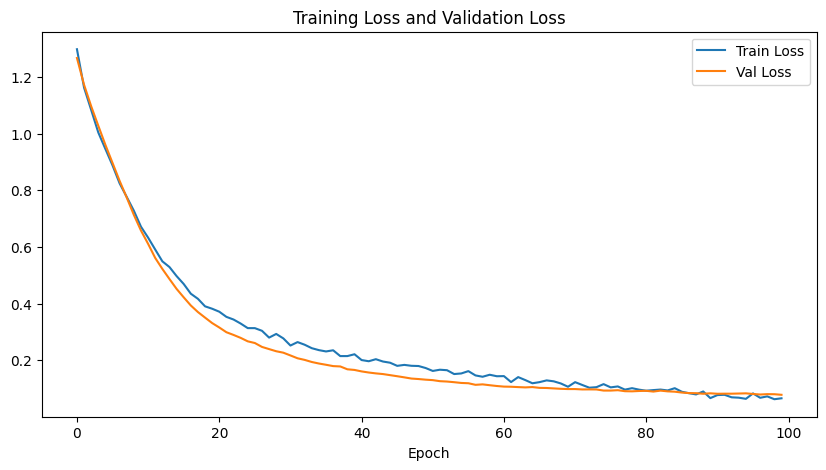


Fold 3
Epoch 1, Train Loss: 1.4793, Val Loss: 1.3759
Epoch 2, Train Loss: 1.3047, Val Loss: 1.2368
Epoch 3, Train Loss: 1.1877, Val Loss: 1.1377
Epoch 4, Train Loss: 1.0999, Val Loss: 1.0736
Epoch 5, Train Loss: 1.0235, Val Loss: 1.0184
Epoch 6, Train Loss: 0.9705, Val Loss: 0.9615
Epoch 7, Train Loss: 0.9011, Val Loss: 0.9103
Epoch 8, Train Loss: 0.8372, Val Loss: 0.8560
Epoch 9, Train Loss: 0.7708, Val Loss: 0.8037
Epoch 10, Train Loss: 0.7246, Val Loss: 0.7516
Epoch 11, Train Loss: 0.6570, Val Loss: 0.7201
Epoch 12, Train Loss: 0.6187, Val Loss: 0.6694
Epoch 13, Train Loss: 0.5786, Val Loss: 0.6431
Epoch 14, Train Loss: 0.5421, Val Loss: 0.6116
Epoch 15, Train Loss: 0.5075, Val Loss: 0.5814
Epoch 16, Train Loss: 0.4931, Val Loss: 0.5614
Epoch 17, Train Loss: 0.4611, Val Loss: 0.5355
Epoch 18, Train Loss: 0.4453, Val Loss: 0.5180
Epoch 19, Train Loss: 0.4245, Val Loss: 0.5008
Epoch 20, Train Loss: 0.4096, Val Loss: 0.4903
Epoch 21, Train Loss: 0.3923, Val Loss: 0.4649
Epoch 22, Trai

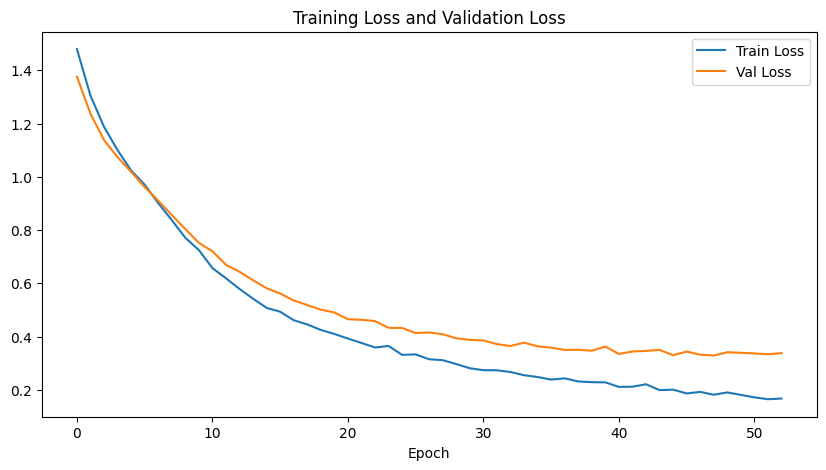


Fold 4
Epoch 1, Train Loss: 1.2720, Val Loss: 1.2024
Epoch 2, Train Loss: 1.1627, Val Loss: 1.1054
Epoch 3, Train Loss: 1.0810, Val Loss: 1.0456
Epoch 4, Train Loss: 1.0182, Val Loss: 0.9948
Epoch 5, Train Loss: 0.9617, Val Loss: 0.9482
Epoch 6, Train Loss: 0.8920, Val Loss: 0.8961
Epoch 7, Train Loss: 0.8270, Val Loss: 0.8469
Epoch 8, Train Loss: 0.7632, Val Loss: 0.8038
Epoch 9, Train Loss: 0.7165, Val Loss: 0.7534
Epoch 10, Train Loss: 0.6699, Val Loss: 0.7146
Epoch 11, Train Loss: 0.6164, Val Loss: 0.6798
Epoch 12, Train Loss: 0.5700, Val Loss: 0.6463
Epoch 13, Train Loss: 0.5235, Val Loss: 0.6157
Epoch 14, Train Loss: 0.4987, Val Loss: 0.5874
Epoch 15, Train Loss: 0.4624, Val Loss: 0.5641
Epoch 16, Train Loss: 0.4318, Val Loss: 0.5456
Epoch 17, Train Loss: 0.4098, Val Loss: 0.5261
Epoch 18, Train Loss: 0.3891, Val Loss: 0.5090
Epoch 19, Train Loss: 0.3565, Val Loss: 0.4967
Epoch 20, Train Loss: 0.3521, Val Loss: 0.4825
Epoch 21, Train Loss: 0.3295, Val Loss: 0.4687
Epoch 22, Trai

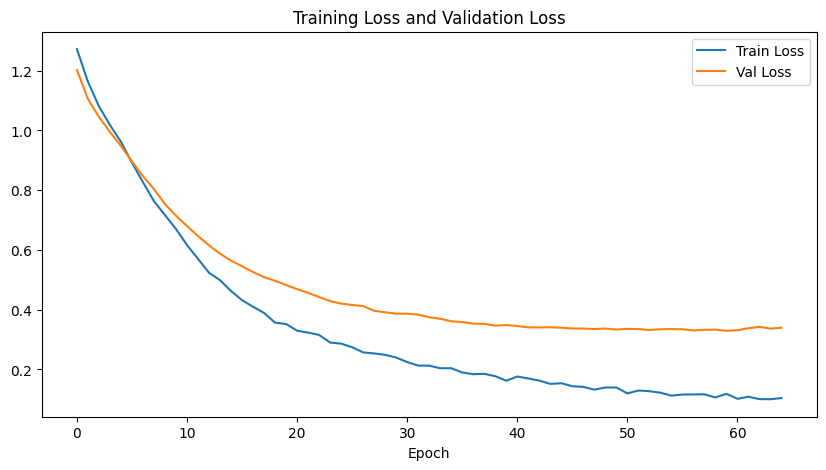


Fold 5
Epoch 1, Train Loss: 1.2334, Val Loss: 1.2088
Epoch 2, Train Loss: 1.1264, Val Loss: 1.1444
Epoch 3, Train Loss: 1.0492, Val Loss: 1.0901
Epoch 4, Train Loss: 0.9901, Val Loss: 1.0286
Epoch 5, Train Loss: 0.9338, Val Loss: 0.9657
Epoch 6, Train Loss: 0.8886, Val Loss: 0.8993
Epoch 7, Train Loss: 0.8212, Val Loss: 0.8353
Epoch 8, Train Loss: 0.7753, Val Loss: 0.7772
Epoch 9, Train Loss: 0.7153, Val Loss: 0.7214
Epoch 10, Train Loss: 0.6547, Val Loss: 0.6715
Epoch 11, Train Loss: 0.6183, Val Loss: 0.6226
Epoch 12, Train Loss: 0.5674, Val Loss: 0.5789
Epoch 13, Train Loss: 0.5442, Val Loss: 0.5387
Epoch 14, Train Loss: 0.5082, Val Loss: 0.5146
Epoch 15, Train Loss: 0.4908, Val Loss: 0.4833
Epoch 16, Train Loss: 0.4631, Val Loss: 0.4581
Epoch 17, Train Loss: 0.4352, Val Loss: 0.4318
Epoch 18, Train Loss: 0.4215, Val Loss: 0.4159
Epoch 19, Train Loss: 0.3972, Val Loss: 0.4022
Epoch 20, Train Loss: 0.3787, Val Loss: 0.3884
Epoch 21, Train Loss: 0.3563, Val Loss: 0.3724
Epoch 22, Trai

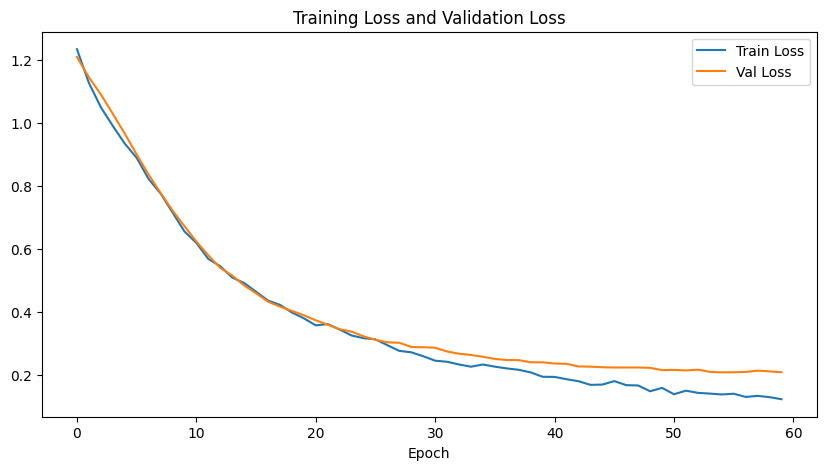

Average Inference Accuracy: 0.9043
Average Inference Precision: [0.93424064 0.80194139 0.89       0.97888889]
Average Inference Recall: [0.93698246 0.82636687 0.68555556 0.97836257]
Average Inference F1: [0.93520009 0.81037022 0.72159811 0.97835528]
Accuracy Scores: [0.9439252336448598, 0.8785046728971962, 0.897196261682243, 0.8962264150943396, 0.9056603773584906]
Precision Scores: [array([0.98360656, 0.85714286, 1.        , 1.        ]), array([0.9245283 , 0.76923077, 0.7       , 1.        ]), array([0.91803279, 0.8       , 1.        , 0.95      ]), array([0.94339623, 0.75      , 1.        , 0.94444444]), array([0.90163934, 0.83333333, 0.75      , 1.        ])]
Recall Scores: [array([0.9375    , 0.96774194, 0.75      , 1.        ]), array([0.9245283 , 0.76923077, 0.77777778, 0.94736842]), array([0.96551724, 0.8       , 0.2       , 1.        ]), array([0.90909091, 0.91304348, 0.7       , 0.94444444]), array([0.94827586, 0.68181818, 1.        , 1.        ])]
F1 Scores: [array([0.96     

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

# --------- Multimodal Transformer Model ---------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        attn_out, _ = self.cross_attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class MultiModalTransformer(nn.Module):
    def __init__(self, methyl_dim=25, rna_dim=25, embed_dim=128, num_heads=4, num_layers=2, num_classes=4):
        super().__init__()
        self.methyl_proj = nn.Linear(methyl_dim, embed_dim)
        self.rna_proj = nn.Linear(rna_dim, embed_dim)
        self.methyl_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.rna_cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.methyl_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.rna_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.cross_attn_methyl = CrossAttentionBlock(embed_dim, num_heads)
        self.cross_attn_rna = CrossAttentionBlock(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, methyl_x, rna_x):
        batch_size = methyl_x.size(0)
        methyl_emb = self.methyl_proj(methyl_x)
        rna_emb = self.rna_proj(rna_x)
        methyl_cls = self.methyl_cls_token.expand(batch_size, -1, -1)
        rna_cls = self.rna_cls_token.expand(batch_size, -1, -1)
        methyl_seq = torch.cat([methyl_cls, methyl_emb.unsqueeze(1)], dim=1)
        rna_seq = torch.cat([rna_cls, rna_emb.unsqueeze(1)], dim=1)
        methyl_encoded = self.methyl_encoder(methyl_seq)
        rna_encoded = self.rna_encoder(rna_seq)
        methyl_cls_encoded = methyl_encoded[:, 0:1, :]
        rna_cls_encoded = rna_encoded[:, 0:1, :]
        methyl_cross = self.cross_attn_methyl(methyl_cls_encoded, rna_encoded)
        rna_cross = self.cross_attn_rna(rna_cls_encoded, methyl_encoded)
        fusion = torch.cat([methyl_cross.squeeze(1), rna_cross.squeeze(1)], dim=1)
        out = self.classifier(fusion)
        return out

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    # PCA Methyl
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_np)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor

# --------- Train Model ---------
def train_model(methyl_tensor, rna_tensor, y_tensor, epochs=50, batch_size=16, lr=1e-4, train_idx=train_idx, test_idx=test_idx, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
      print(f"\nFold {fold + 1}")

      # Use Subset to split dataset
      train_dataset = Subset(dataset, train_idx)
      inf_dataset = Subset(dataset, val_idx)

      total_len = len(train_dataset)
      train_len = int(0.85 * total_len)
      val_len = total_len - train_len
      train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator = g)
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator = g)
      val_loader = DataLoader(val_subset, batch_size=batch_size, generator = g)
      inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator = g)
      model = MultiModalTransformer(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1]).to(device)
      optimizer = optim.AdamW(model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()
      #best_val_loss = 0.0
      best_val_loss = float('inf')
      patience = 5
      counter = 0
      train_losses, val_losses = [], []
      for epoch in range(epochs):
          model.train()
          running_loss = 0.0
          for methyl_x, rna_x, y in train_loader:
              methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
              optimizer.zero_grad()
              pred = model(methyl_x, rna_x)
              loss = criterion(pred, y)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
              running_loss += loss.item() * methyl_x.size(0)
          train_loss = running_loss / train_len
          #val_acc = evaluate_model(model, val_loader, device)
          val_loss = evaluate_loss(model, val_loader, criterion, device)
          train_losses.append(train_loss)
          #val_accuracies.append(val_acc)
          val_losses.append(val_loss)
          print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

          if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model2.pt")
          else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

      model.load_state_dict(torch.load("best_model2.pt"))
      inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
      print(f"Inference Accuracy: {inf_acc:.4f}")
      print(f"Inference Precision: {inf_pre}")
      print(f"Inference Recall: {inf_rec}")
      print(f"Inference F1: {inf_f1}")
      accuracy_scores.append(inf_acc)
      precision_scores.append(inf_pre)
      recall_scores.append(inf_rec)
      f1_scores.append(inf_f1)

      plt.figure(figsize=(10,5))
      plt.plot(train_losses, label="Train Loss")
      plt.plot(val_losses, label="Val Loss")
      plt.xlabel("Epoch")
      plt.legend()
      plt.title("Training Loss and Validation Loss")
      plt.show()
    print(f"Average Inference Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average Inference Precision: {np.mean(precision_scores, axis=0)}")
    print(f"Average Inference Recall: {np.mean(recall_scores, axis=0)}")
    print(f"Average Inference F1: {np.mean(f1_scores, axis=0)}")
    return model, accuracy_scores, precision_scores, recall_scores, f1_scores, train_losses, val_losses

# --------- validate Model ---------
def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl_x, rna_x, y in loader:
            methyl_x, rna_x, y = methyl_x.to(device), rna_x.to(device), y.to(device)
            out = model(methyl_x, rna_x)
            loss = criterion(out, y)
            total_loss += loss.item() * methyl_x.size(0)
            total_samples += methyl_x.size(0)
    return total_loss / total_samples


# --------- Main flow---------
def main_train_and_plot(methyl_np, rna_np, y_np, train_idx, test_idx):
    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, y_np)
    model, inf_acc, inf_pre, inf_rec, inf_f1, train_losses, val_losses = train_model(methyl_tensor, rna_tensor, y_tensor,
                                                                epochs = 100, batch_size=16, lr=1e-5,
                                                           train_idx = train_idx, test_idx = test_idx)
    print(f"Accuracy Scores: {inf_acc}")
    print(f"Precision Scores: {inf_pre}")
    print(f"Recall Scores: {inf_rec}")
    print(f"F1 Scores: {inf_f1}")
    return model

lw_try = df_methyl_shap[:25]['feature'].tolist() + df_rna_shap[:25]['feature'].tolist()
model = main_train_and_plot(methyl_scaled[:, [i for (i, d)in enumerate(methyl_aligned.columns) if d in lw_try]],
                            rna_selected[:, [i for (i, d)in enumerate(rna_selected_columns) if d in lw_try]],
                            y_label, train_idx_a, test_idx_a)

Light Weight Accuracy from 89.50% to 90.43%

#### 4 Multimodal Mamba Model

##### 4.1 Train, Valid, and Inference - Loss

In [ ]:
import torch
import torch.nn as nn
from transformers import MambaConfig, MambaModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import copy

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    """
    Apply PCA to methylation data, z-score scale both modalities,
    and convert arrays into PyTorch tensors.

    Parameters
    ----------
    methyl_np : ndarray
        Raw methylation matrix (samples × features).
    rna_np : ndarray
        Raw RNA matrix (samples × genes).
    y_np : ndarray
        Label array.
    methyl_pca_dim : int
        Number of PCA components for methylation.

    Returns
    -------
    methyl_tensor : torch.FloatTensor
    rna_tensor : torch.FloatTensor
    y_tensor : torch.LongTensor
    """
    # PCA Methyl
    pca = PCA(n_components=methyl_pca_dim)
    methyl_pca = pca.fit_transform(methyl_np)
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_pca)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor

class MultiModalMambaClassifier2(nn.Module):
    """
    Multimodal classifier combining methylation and RNA embeddings
    using the HuggingFace Mamba sequence model.

    Methylation and RNA are projected to the same hidden dimension,
    processed separately through Mamba, concatenated, and classified.
    """
    def __init__(self, methyl_dim=500, rna_dim=47, hidden_size=256, num_classes=5, seq_len = 2):
        super().__init__()
        # Hugging Face Mamba default hidden_size = 256，seq_len maximum = 4000
        # Simple linear embedding to make methyl and RNA to the same dimension
        self.methyl_embed = nn.Linear(methyl_dim, hidden_size)
        self.rna_embed = nn.Linear(rna_dim, hidden_size)

        # Mamba configuration（change seq length = 2，as two module features concatenated to length of 2）
        config = MambaConfig(
            hidden_size=hidden_size,
            intermediate_size=hidden_size*2,
            num_attention_heads=4,
            num_hidden_layers=2,
            seq_len=seq_len,
        )
        self.mamba = MambaModel(config)

        # Classifier head
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, methyl_features, rna_features):
        """
        Forward pass through methylation and RNA branches, Mamba encoding,
        feature fusion, and classification.

        Parameters
        ----------
        methyl_features : torch.Tensor
            Tensor of shape (batch, methyl_dim).
        rna_features : torch.Tensor
            Tensor of shape (batch, rna_dim).

        Returns
        -------
        logits : torch.Tensor
            Output class logits (batch, num_classes).
        """
        # embed to hidden_size
        methyl_emb = self.methyl_embed(methyl_features)  # (B, hidden)
        rna_emb = self.rna_embed(rna_features)          # (B, hidden)

        methyl_x = methyl_emb.unsqueeze(1)
        rna_x = rna_emb.unsqueeze(1)

        # Mamba forward
        outputs1 = self.mamba(inputs_embeds=methyl_x)
        last_hidden1 = outputs1.last_hidden_state  # (B, seq_len=1, hidden_size)
        outputs2 = self.mamba(inputs_embeds=rna_x)
        last_hidden2 = outputs2.last_hidden_state  # (B, seq_len=1, hidden_size)
        last_hidden = torch.cat([last_hidden1, last_hidden2], dim=1)  # (B, seq_len=2, hidden_size)

        # mean of last hidden layer
        pooled = last_hidden.mean(dim=1)                 # (B, hidden_size)

        logits = self.classifier(pooled)                  # (B, num_classes)
        return logits

class EarlyStopping:
    """
    Early stopping utility that monitors a metric, saves the best model,
    and halts training after consecutive non-improving epochs.

    Parameters
    ----------
    patience : int
        Number of epochs without improvement before stopping.
    mode : str
        'max' (higher is better) or 'min' (lower is better), depending on the metric.
    save_path : str
        File path to store the best model checkpoint.
    """
    def __init__(self, patience=3, mode='max', save_path="best_model.pt"):
        """
        patience: consecutive # of epoch without improvement
        mode: 'max' means indicator the higher the better，E.g., accuracy
        """
        self.patience = patience
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.best_state = None
        self.early_stop = False
        self.save_path = save_path  # Path to save the model

    def step(self, current_score, model):
       """
        Update early stopping state based on the new metric value.

        Parameters
        ----------
        current_score : float
            Current evaluation metric.
        model : nn.Module
            Model whose state will be saved if improvement occurs.
        """
        if self.best_score is None:
            self.best_score = current_score
            self.best_state = copy.deepcopy(model.state_dict())
            torch.save(self.best_state, self.save_path)  # <-- Save model
            return
        if (self.mode == 'max' and current_score > self.best_score) or \
           (self.mode == 'min' and current_score < self.best_score):
            self.best_score = current_score
            self.best_state = copy.deepcopy(model.state_dict())
            torch.save(self.best_state, self.save_path)  # <-- Save model
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train the model for one epoch on a given dataloader.

    Parameters
    ----------
    model : nn.Module
        Neural network model.
    dataloader : DataLoader
        Training data loader containing (methyl, rna, label).
    optimizer : torch.optim.Optimizer
        Optimizer used for training.
    criterion : loss function
        Loss function (e.g., CrossEntropyLoss).
    device : str
        'cuda' or 'cpu'.

    Returns
    -------
    float
        Average training loss for the epoch.
    """
    model.train()
    total_loss = 0
    for methyl, rna, label in dataloader:
        methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
        optimizer.zero_grad()
        logits = model(methyl, rna)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate_model(model, loader, device):
    """
    Evaluate a trained model and compute multi-class metrics.

    Parameters
    ----------
    model : nn.Module
        Trained model.
    loader : DataLoader
        Evaluation dataloader.
    device : str
        'cuda' or 'cpu'.

    Returns
    -------
    accuracy : float
    precision : ndarray
    recall : ndarray
    f1 : ndarray
        Per-class metrics (average=None).
    """
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl, rna, y in loader:
            methyl, rna, y = methyl.to(device), rna.to(device), y.to(device)
            out = model(methyl, rna)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)

def evaluate_loss(model, dataloader, criterion, device):
    """
    Compute mean loss over an evaluation dataset.

    Parameters
    ----------
    model : nn.Module
        Model to evaluate.
    dataloader : DataLoader
        Validation or test dataloader.
    criterion : loss function
        Loss function used during evaluation.
    device : str
        'cuda' or 'cpu'.

    Returns
    -------
    float
        Average loss across all samples.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl, rna, label in dataloader:
            methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
            logits = model(methyl, rna)
            loss = criterion(logits, label)
            total_loss += loss.item() * label.size(0)
            total_samples += label.size(0)
    return total_loss / total_samples


In [ ]:
if __name__ == "__main__":

    #methyl_np = methyl_scaled  # shape (N, 50000)
    methyl_np = methyl_filled
    rna_np = rna_selected     # shape (N, 300)
    labels_np = y_label  # shape (N, )

    batch_size = 8
    #methyl_dim = 50000
    #rna_dim = 300
    num_classes = 4
    learning_rate = 5e-5
    patience_ = 5
    methyl_pca_dim = 500
    seq_len = 1

    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, labels_np, methyl_pca_dim = methyl_pca_dim)
    #dataset = BRCA_MultiModalDataset(methyl_np, rna_np, labels_np)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)


    train_idx_a = np.load(path+"train_idx_a1.npy")
    test_idx_a = np.load(path+"test_idx_a1.npy")
    train_idx = np.load(path+"train_idx1.npy")
    valid_idx = np.load(path+"valid_idx1.npy")

    train_dataset = Subset(dataset, train_idx_a)
    inf_dataset = Subset(dataset, test_idx_a)
    train_set1 = Subset(train_dataset, train_idx)
    val_set1  = Subset(train_dataset, valid_idx)

    total_len = len(train_dataset)
    train_len = len(train_set1)
    val_len = len(val_set1)
    #train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=g)
    train_loader = DataLoader(train_set1, batch_size=batch_size, shuffle=True, generator= g)
    val_loader = DataLoader(val_set1, batch_size=batch_size, generator= g)
    inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator= g)
    model = MultiModalMambaClassifier2(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1], num_classes=4, seq_len = 2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopping(patience=patience_, mode='min', save_path=path+"best_model_512.pt")

    epochs = 100
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate_loss(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        early_stopper.step(val_loss, model)

        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model parameter weights
    model.load_state_dict(early_stopper.best_state)
    inf_acc, inf_pre, inf_recall, inf_f1 = evaluate_model(model, inf_loader, device)
    print(f"Inf accuracy: {inf_acc:.4f}")
    print(f"Inf precision: {inf_pre}")
    print(f"Inf recall: {inf_recall}")
    print(f"Inf f1: {inf_f1}")


Epoch 1: Train Loss=1.0470, Val Loss=0.6907
Epoch 2: Train Loss=0.5419, Val Loss=0.5027
Epoch 3: Train Loss=0.3689, Val Loss=0.4096
Epoch 4: Train Loss=0.2659, Val Loss=0.3534
Epoch 5: Train Loss=0.1977, Val Loss=0.3073
Epoch 6: Train Loss=0.1383, Val Loss=0.2801
Epoch 7: Train Loss=0.1001, Val Loss=0.2533
Epoch 8: Train Loss=0.0735, Val Loss=0.2354
Epoch 9: Train Loss=0.0547, Val Loss=0.2206
Epoch 10: Train Loss=0.0416, Val Loss=0.2097
Epoch 11: Train Loss=0.0331, Val Loss=0.1979
Epoch 12: Train Loss=0.0271, Val Loss=0.1906
Epoch 13: Train Loss=0.0222, Val Loss=0.1850
Epoch 14: Train Loss=0.0185, Val Loss=0.1772
Epoch 15: Train Loss=0.0161, Val Loss=0.1729
Epoch 16: Train Loss=0.0136, Val Loss=0.1666
Epoch 17: Train Loss=0.0120, Val Loss=0.1627
Epoch 18: Train Loss=0.0106, Val Loss=0.1592
Epoch 19: Train Loss=0.0095, Val Loss=0.1571
Epoch 20: Train Loss=0.0085, Val Loss=0.1538
Epoch 21: Train Loss=0.0077, Val Loss=0.1504
Epoch 22: Train Loss=0.0070, Val Loss=0.1484
Epoch 23: Train Los

##### Load Model and Inference

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    """
    Apply PCA to methylation data, z-score scale both modalities,
    and convert arrays into PyTorch tensors.

    Parameters
    ----------
    methyl_np : ndarray
        Raw methylation matrix (samples × features).
    rna_np : ndarray
        Raw RNA matrix (samples × genes).
    y_np : ndarray
        Label array.
    methyl_pca_dim : int
        Number of PCA components for methylation.

    Returns
    -------
    methyl_tensor : torch.FloatTensor
    rna_tensor : torch.FloatTensor
    y_tensor : torch.LongTensor
    pca: PCA artifact
    """


    # PCA Methyl
    pca = PCA(n_components=methyl_pca_dim)
    methyl_pca = pca.fit_transform(methyl_np)
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_pca)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor, pca


if __name__ == "__main__":

    #methyl_np = methyl_scaled  # shape (N, 50000)
    methyl_np = methyl_filled
    rna_np = rna_selected     # shape (N, 300)
    labels_np = y_label  # shape (N, )

    batch_size = 8
    #methyl_dim = 50000
    #rna_dim = 300
    num_classes = 4
    learning_rate = 5e-5
    patience_ = 5
    methyl_pca_dim = 500
    seq_len = 1

    methyl_tensor, rna_tensor, y_tensor, pca_meth_mamba = preprocess_data(methyl_np, rna_np, labels_np, methyl_pca_dim = methyl_pca_dim)
    #dataset = BRCA_MultiModalDataset(methyl_np, rna_np, labels_np)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)


    train_idx_a = np.load(path+"train_idx_a1.npy")
    test_idx_a = np.load(path+"test_idx_a1.npy")
    train_idx = np.load(path+"train_idx1.npy")
    valid_idx = np.load(path+"valid_idx1.npy")

    train_dataset = Subset(dataset, train_idx_a)
    inf_dataset = Subset(dataset, test_idx_a)
    train_set1 = Subset(train_dataset, train_idx)
    val_set1  = Subset(train_dataset, valid_idx)

    total_len = len(train_dataset)
    train_len = len(train_set1)
    val_len =len(val_set1)
    #train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=g)
    train_loader = DataLoader(train_set1, batch_size=batch_size, shuffle=True, generator= g)
    val_loader = DataLoader(val_set1, batch_size=batch_size, generator= g)
    inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator= g)
    model = MultiModalMambaClassifier2(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1], num_classes=4, seq_len = 2).to(device)

    #model.load_state_dict(torch.load(path+"model_artifact/Mamba/best_model_5.pt"))
    model.load_state_dict(torch.load(path+"best_model_512.pt"))
    model.eval()
    inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
    print(f"Inf accuracy: {inf_acc:.4f}")
    print(f"Inf precision: {inf_pre}")
    print(f"Inf recall: {inf_rec}")
    print(f"Inf f1: {inf_f1}")

Inf accuracy: 0.8692
Inf precision: [0.9122807  0.73076923 0.71428571 1.        ]
Inf recall: [0.89655172 0.73076923 0.83333333 1.        ]
Inf f1: [0.90434783 0.73076923 0.76923077 1.        ]


##### SHAP Value

In [ ]:
import shap
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

# take a small portion of data
background_methyl = methyl_tensor[:100].to(device)
background_rna = rna_tensor[:100].to(device)

explainer = shap.GradientExplainer(model, [background_methyl, background_rna])

# get some sample to explain
test_methyl = methyl_tensor[100:200].to(device)
test_rna = rna_tensor[100:200].to(device)

shap_values = explainer.shap_values([test_methyl, test_rna])

In [ ]:
class_idx = 0
shap_vals_methyl = shap_values[0][:, :, class_idx]  # shape (20, 500)
shap_vals_rna = shap_values[1][:, :, class_idx]    # shape (20, 300)

In [ ]:
global_shap_rna = np.mean(np.abs(shap_vals_rna), axis=0)  # shape (feature_dim,)
df_rna_shap = pd.DataFrame({
    'feature': rna_selected_columns,
    'avg_abs_shap': global_shap_rna
})
df_rna_shap = df_rna_shap.sort_values(by='avg_abs_shap', ascending=False).reset_index(drop=True)

W = pca_meth_mamba.components_.T  # shape (d, k)
shap_vals_orig = np.dot(shap_vals_methyl, W.T)  # Shape (num_samples, d)
global_shap_methyl = np.mean(np.abs(shap_vals_orig), axis=0)  # shape (feature_dim,)
df_methyl_shap = pd.DataFrame({
    'feature': methyl_aligned.columns,
    'avg_abs_shap': global_shap_methyl
})
df_methyl_shap = df_methyl_shap.sort_values(by='avg_abs_shap', ascending=False).reset_index(drop=True)

df_methyl_shap.to_csv(path+"df_methyl_shap_mamba2.csv")
df_rna_shap.to_csv(path+"df_rna_shap_mamba2.csv")

##### Cross Validation - Methyl_filled and 20% inference data

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    # PCA Methyl
    pca = PCA(n_components=methyl_pca_dim)
    methyl_pca = pca.fit_transform(methyl_np)
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_pca)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for methyl, rna, label in dataloader:
        methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
        optimizer.zero_grad()
        logits = model(methyl, rna)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl, rna, y in loader:
            methyl, rna, y = methyl.to(device), rna.to(device), y.to(device)
            out = model(methyl, rna)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)


def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl, rna, label in dataloader:
            methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
            logits = model(methyl, rna)
            loss = criterion(logits, label)
            total_loss += loss.item() * label.size(0)
            total_samples += label.size(0)
    return total_loss / total_samples


if __name__ == "__main__":

    #methyl_np = methyl_scaled  # shape (N, 50000)
    methyl_np = methyl_filled
    rna_np = rna_selected     # shape (N, 300)
    labels_np = y_label  # shape (N, )

    batch_size = 8
    #methyl_dim = 50000
    #rna_dim = 300
    num_classes = 4
    learning_rate = 5e-5
    patience_ = 5
    methyl_pca_dim = 500
    seq_len = 1

    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, labels_np, methyl_pca_dim = methyl_pca_dim)
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
      print(f"\nFold {fold + 1}")

      # Use Subset to split dataset
      train_dataset = Subset(dataset, train_idx)
      inf_dataset = Subset(dataset, val_idx)

      total_len = len(train_dataset)
      train_len = int(0.85 * total_len)
      val_len = total_len - train_len
      train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator = g)
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator = g)
      val_loader = DataLoader(val_subset, batch_size=batch_size, generator = g)
      inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator = g)

      device = "cuda" if torch.cuda.is_available() else "cpu"
      model = MultiModalMambaClassifier2(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1], num_classes=4, seq_len = 2).to(device)

      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      criterion = torch.nn.CrossEntropyLoss()
      early_stopper = EarlyStopping(patience=patience_, mode='min', save_path=f"best_model_532_fold{fold}_cg.pt")

      epochs = 100
      for epoch in range(epochs):
          train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
          val_loss = evaluate_loss(model, val_loader, criterion, device)
          print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
          early_stopper.step(val_loss, model)

          if early_stopper.early_stop:
              print(f"Early stopping triggered at epoch {epoch+1}")
              break

      # Load the best model parameter weights
      model.load_state_dict(early_stopper.best_state)
      inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
      print(f"Inf accuracy: {inf_acc:.4f}")
      print(f"Inf precision: {inf_pre}")
      print(f"Inf recall: {inf_rec}")
      print(f"Inf f1: {inf_f1}")
      accuracy_scores.append(inf_acc)
      precision_scores.append(inf_pre)
      recall_scores.append(inf_rec)
      f1_scores.append(inf_f1)

    print(f"Average accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average precision: {np.mean(precision_scores, axis=0)}")
    print(f"Average recall: {np.mean(recall_scores, axis=0)}")
    print(f"Average f1: {np.mean(f1_scores, axis=0)}")
    print(f"Accuracy scores: {accuracy_scores}")
    print(f"Precision scores: {precision_scores}")
    print(f"Recall scores: {recall_scores}")
    print(f"F1 scores: {f1_scores}")


Fold 1
Epoch 1: Train Loss=1.0164, Val Loss=0.7737
Epoch 2: Train Loss=0.5348, Val Loss=0.5903
Epoch 3: Train Loss=0.3759, Val Loss=0.5004
Epoch 4: Train Loss=0.2712, Val Loss=0.4477
Epoch 5: Train Loss=0.2005, Val Loss=0.4085
Epoch 6: Train Loss=0.1433, Val Loss=0.3788
Epoch 7: Train Loss=0.1042, Val Loss=0.3590
Epoch 8: Train Loss=0.0789, Val Loss=0.3468
Epoch 9: Train Loss=0.0598, Val Loss=0.3347
Epoch 10: Train Loss=0.0471, Val Loss=0.3296
Epoch 11: Train Loss=0.0361, Val Loss=0.3251
Epoch 12: Train Loss=0.0291, Val Loss=0.3217
Epoch 13: Train Loss=0.0243, Val Loss=0.3165
Epoch 14: Train Loss=0.0205, Val Loss=0.3171
Epoch 15: Train Loss=0.0174, Val Loss=0.3163
Epoch 16: Train Loss=0.0151, Val Loss=0.3149
Epoch 17: Train Loss=0.0131, Val Loss=0.3133
Epoch 18: Train Loss=0.0116, Val Loss=0.3135
Epoch 19: Train Loss=0.0105, Val Loss=0.3138
Epoch 20: Train Loss=0.0093, Val Loss=0.3135
Epoch 21: Train Loss=0.0084, Val Loss=0.3149
Epoch 22: Train Loss=0.0076, Val Loss=0.3161
Early stopp

In [ ]:
print(f"Average accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average precision: {np.mean(precision_scores, axis=0)}")
print(f"Average recall: {np.mean(recall_scores, axis=0)}")
print(f"Average f1: {np.mean(f1_scores, axis=0)}")
print(f"Accuracy scores: {accuracy_scores}")
print(f"Precision scores: {precision_scores}")
print(f"Recall scores: {recall_scores}")
print(f"F1 scores: {f1_scores}")

Average accuracy: 0.9025
Average precision: [0.94199838 0.81046684 0.8169697  0.93777778]
Average recall: [0.91572854 0.86077427 0.75       0.97836257]
Average f1: [0.92827455 0.83160167 0.76333333 0.95664905]
Accuracy scores: [0.9158878504672897, 0.8878504672897196, 0.897196261682243, 0.8584905660377359, 0.9528301886792453]
Precision scores: [array([0.96774194, 0.87096774, 0.6       , 0.88888889]), array([0.89090909, 0.82608696, 0.81818182, 1.        ]), array([0.94642857, 0.78571429, 0.66666667, 0.95      ]), array([0.94, 0.7 , 1.  , 0.85]), array([0.96491228, 0.86956522, 1.        , 1.        ])]
Recall scores: [array([0.9375    , 0.87096774, 0.75      , 1.        ]), array([0.9245283 , 0.73076923, 1.        , 0.94736842]), array([0.9137931, 0.88     , 0.4      , 1.       ]), array([0.85454545, 0.91304348, 0.6       , 0.94444444]), array([0.94827586, 0.90909091, 1.        , 1.        ])]
F1 scores: [array([0.95238095, 0.87096774, 0.66666667, 0.94117647]), array([0.90740741, 0.775510

Based on Cross Validation, 5.3.2 is the best, use methyl_filled, avg accuracy 90.25%

##### 4.4 !!! Light Weight

In [ ]:
## Get Top features from the SHAP Value Results
df_methyl_shap = pd.read_csv(path+"df_methyl_shap_mamba2.csv")
df_rna_shap = pd.read_csv(path+"df_rna_shap_mamba2.csv")

In [ ]:
## Select top 25 Methyl features and top 25 RNA features
lw_try = df_methyl_shap[:25]['feature'].tolist() + df_rna_shap[:25]['feature'].tolist()
lw_try

['cg23357130',
 'cg18260625',
 'cg18413131',
 'cg26107890',
 'cg19980771',
 'cg09557387',
 'cg06546677',
 'cg17935217',
 'cg17882374',
 'cg03596016',
 'cg24368848',
 'cg08911275',
 'cg04227961',
 'cg07906855',
 'cg17794299',
 'cg10184328',
 'cg17164063',
 'cg08819022',
 'cg25070340',
 'cg19717586',
 'cg23736843',
 'cg02575448',
 'cg16601494',
 'cg24402300',
 'cg26512254',
 'MASTL',
 'RFC4',
 'CKS1B',
 'CDC25A',
 'ZNF703',
 'PPP1R14C',
 'MTHFD1L',
 'ABAT',
 'ANKRD30A',
 'CENPO',
 'CCNA2',
 'GABRP',
 'POP1',
 'B3GNT5',
 'KRT16',
 'ARSG',
 'GREB1',
 'RGMA',
 'ZNF552',
 'DSCC1',
 'CYP4B1',
 'BCL11A',
 'TTK',
 'ZNF454',
 'CDC45']

In [ ]:
top_cpg_n= [d for (i, d)in enumerate(methyl_aligned.columns) if d in lw_try]

In [ ]:
top_cpg_methyl_aligned_index = [i for (i, d)in enumerate(methyl_aligned.columns) if d in lw_try]

In [ ]:
top_rna_n=[d for (i, d)in enumerate(rna_selected_columns) if d in lw_try]

In [ ]:
top_rna_selected_index =  [i for (i, d)in enumerate(rna_selected_columns) if d in lw_try]

In [ ]:
top_cpg_n

['cg10184328',
 'cg17794299',
 'cg08911275',
 'cg07906855',
 'cg23736843',
 'cg17935217',
 'cg26512254',
 'cg03596016',
 'cg23357130',
 'cg19717586',
 'cg24368848',
 'cg25070340',
 'cg17882374',
 'cg26107890',
 'cg08819022',
 'cg17164063',
 'cg18413131',
 'cg19980771',
 'cg09557387',
 'cg24402300',
 'cg16601494',
 'cg18260625',
 'cg04227961',
 'cg02575448',
 'cg06546677']

In [ ]:
top_rna_n

['ZNF703',
 'CKS1B',
 'ABAT',
 'CDC45',
 'B3GNT5',
 'ZNF552',
 'GABRP',
 'KRT16',
 'ANKRD30A',
 'PPP1R14C',
 'MTHFD1L',
 'RFC4',
 'CDC25A',
 'ZNF454',
 'TTK',
 'POP1',
 'CCNA2',
 'CYP4B1',
 'ARSG',
 'CENPO',
 'GREB1',
 'DSCC1',
 'RGMA',
 'BCL11A',
 'MASTL']

In [ ]:
top_cpg_methyl_aligned_index

[223,
 990,
 1764,
 2315,
 2990,
 5333,
 6664,
 11539,
 20009,
 20952,
 22087,
 22778,
 24319,
 24698,
 26172,
 27588,
 30822,
 30969,
 33044,
 33357,
 36348,
 37699,
 46824,
 47420,
 49044]

In [ ]:
top_rna_selected_index

[4,
 5,
 8,
 23,
 26,
 38,
 65,
 66,
 89,
 115,
 116,
 146,
 164,
 176,
 226,
 231,
 243,
 248,
 263,
 264,
 271,
 273,
 278,
 280,
 288]

In [ ]:
import os
import json

os.makedirs(path + "files", exist_ok=True)  # create "files" folder if it doesn’t exist

feature_json = {"feature_names": lw_try, "feature_methyl": top_cpg_n, "feature_rna":top_rna_n }

with open(path + "files/feature_json_v2.json", "w") as f:
    json.dump(feature_json, f, indent=4)

Inference Steps <br/>
3. convert numpy to tensor <br/>
4. convert tensor to Tensordataset <br/>
5. convert Tensordataset to Dataloader <br/>

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import joblib

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np):
    # PCA Methyl
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_np)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor, scaler_methyl, scaler_rna

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for methyl, rna, label in dataloader:
        methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
        optimizer.zero_grad()
        logits = model(methyl, rna)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl, rna, y in loader:
            methyl, rna, y = methyl.to(device), rna.to(device), y.to(device)
            out = model(methyl, rna)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)


def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl, rna, label in dataloader:
            methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
            logits = model(methyl, rna)
            loss = criterion(logits, label)
            total_loss += loss.item() * label.size(0)
            total_samples += label.size(0)
    return total_loss / total_samples


if __name__ == "__main__":

    batch_size = 8
    #methyl_dim = 50000
    #rna_dim = 300
    num_classes = 4
    learning_rate = 5e-5
    patience_ = 5
    methyl_pca_dim = 500
    seq_len = 1

    methyl_np_lw = methyl_filled[:, top_cpg_methyl_aligned_index]
    rna_selected_lw = rna_selected[:, top_rna_selected_index]
    labels_np = y_label  # shape (N, )

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    methyl_tensor1, rna_tensor1, y_tensor1, scaler_methyl, scaler_rna = preprocess_data(methyl_np_lw, rna_selected_lw, labels_np)
    joblib.dump(scaler_methyl, path+"scaler_methyl_lw.pkl")
    joblib.dump(scaler_rna, path+"scaler_rna_lw.pkl")
    dataset = TensorDataset(methyl_tensor1, rna_tensor1, y_tensor1)
    train_idx_a = np.load(path+"train_idx_a.npy")
    test_idx_a = np.load(path+"test_idx_a.npy")
    train_dataset = Subset(dataset, train_idx_a)
    inf_dataset = Subset(dataset, test_idx_a)

    total_len = len(train_dataset)
    train_len = int(0.85 * total_len)
    val_len = total_len - train_len
    train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator = g)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator = g)
    val_loader = DataLoader(val_subset, batch_size=batch_size, generator = g)
    inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator = g)

    model = MultiModalMambaClassifier2(methyl_dim=methyl_tensor1.shape[1], rna_dim=rna_tensor1.shape[1], num_classes=4, seq_len = 2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopping(patience=patience_, mode='min', save_path=path+"best_model_53_lw1.pt")

    epochs = 100
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate_loss(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        early_stopper.step(val_loss, model)

        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model parameter weights
    model.load_state_dict(early_stopper.best_state)
    inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
    print(f"Inf accuracy: {inf_acc:.4f}")
    print(f"Inf precision: {inf_pre}")
    print(f"Inf recall: {inf_rec}")
    print(f"Inf f1: {inf_f1}")

Epoch 1: Train Loss=1.0891, Val Loss=0.7831
Epoch 2: Train Loss=0.6338, Val Loss=0.5179
Epoch 3: Train Loss=0.4388, Val Loss=0.4066
Epoch 4: Train Loss=0.3370, Val Loss=0.3530
Epoch 5: Train Loss=0.2751, Val Loss=0.3257
Epoch 6: Train Loss=0.2301, Val Loss=0.3094
Epoch 7: Train Loss=0.1844, Val Loss=0.3005
Epoch 8: Train Loss=0.1469, Val Loss=0.2919
Epoch 9: Train Loss=0.1186, Val Loss=0.2889
Epoch 10: Train Loss=0.0951, Val Loss=0.2884
Epoch 11: Train Loss=0.0753, Val Loss=0.2901
Epoch 12: Train Loss=0.0589, Val Loss=0.2919
Epoch 13: Train Loss=0.0465, Val Loss=0.2990
Epoch 14: Train Loss=0.0366, Val Loss=0.2944
Epoch 15: Train Loss=0.0288, Val Loss=0.2985
Early stopping triggered at epoch 15
Inf accuracy: 0.9065
Inf precision: [0.88888889 0.875      0.9        1.        ]
Inf recall: [0.97959184 0.75       0.81818182 1.        ]
Inf f1: [0.93203883 0.80769231 0.85714286 1.        ]


In [ ]:
torch.save(methyl_np_lw, path+"tensor_methyl1.pt")
rna_lw =  torch.FloatTensor(rna_filtered[top_rna_n].to_numpy())
torch.save(rna_lw, path+"tensor_rna111.pt")

torch.save(rna_selected_lw, path+"tensor_rna1.pt")

In [ ]:
import joblib
scaler_methyl_n = joblib.load(path+"scaler_methyl_lw.pkl")
scaler_rna_n = joblib.load(path+"scaler_rna_lw.pkl")

In [ ]:
import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
import torch.nn.functional as F

In [ ]:
#labels_np = torch.LongTensor(y_label)

In [ ]:
methyl_tensor2 = torch.FloatTensor(scaler_methyl_n.transform(methyl_np_lw[test_idx_a]))
rna_tensor2 = torch.FloatTensor(scaler_rna_n.transform(rna_selected_lw[test_idx_a]))
y_tensor2 = torch.LongTensor(labels_np[test_idx_a])
inference_dataset = TensorDataset(methyl_tensor2[0:10], rna_tensor2[0:10], y_tensor2[0:10])

In [ ]:
device = "cpu"
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import joblib


In [ ]:
test_loader = DataLoader(inference_dataset, batch_size=1, shuffle = False, generator = g)
model1 = MultiModalMambaClassifier2(methyl_dim=25, rna_dim=25, num_classes=4, seq_len = 2).to(device)
#model1.load_state_dict(path+'model_artifact/Mamba/best_model_5_lw_2.pt')
    ##early_stopper.best_state
#state_dict = torch.load(path+'model_artifact/Mamba/best_model_5_lw.pt', map_location=torch.device('cpu'))
state_dict = torch.load(path+'best_model_53_lw1.pt', map_location=torch.device('cpu'))
model1.load_state_dict(state_dict)
model1.eval()
with torch.no_grad():
  c=0
  for methyl, rna, y in test_loader:
    methyl, rna, y= methyl.to(device), rna.to(device), y.to(device)
    logits = model1(methyl, rna)
    preds = torch.argmax(logits, dim=1)
    print(preds, y)
    if preds==y:
      c+=1
  print('inference accuracy ', c/len(test_loader))


tensor([0]) tensor([1])
tensor([0]) tensor([0])
tensor([3]) tensor([3])
tensor([2]) tensor([1])
tensor([3]) tensor([3])
tensor([0]) tensor([1])
tensor([1]) tensor([1])
tensor([0]) tensor([0])
tensor([0]) tensor([0])
tensor([0]) tensor([1])
inference accuracy  0.6


In [ ]:
methyl_tensor2[1:2,], rna_tensor2[1:2,]

(tensor([[-0.9912, -0.8703,  1.5748,  2.2164,  1.5079, -0.7992,  1.2410,  1.6404,
          -0.9713,  1.9919, -0.8207, -0.4090,  0.9004,  0.7683, -0.9138,  1.9256,
          -0.8784,  1.1640,  1.0508,  1.1711, -0.9775,  1.6097,  1.2824,  1.7531,
           0.6748]]),
 tensor([[ 1.3590,  0.3000, -1.3017,  0.4341,  0.5362,  1.1386, -0.4665,  1.2343,
          -1.7114,  0.1507, -0.7374, -0.2496, -0.2304, -0.5807, -0.3602,  0.1763,
           0.6457,  0.7057,  1.7047,  0.1172, -0.4348,  0.1968, -0.5741, -0.2668,
          -0.5551]]))

In [ ]:
## Save model to
traced_model = torch.jit.trace(model1.to('cpu'), (methyl_tensor2[1:2,], rna_tensor2[1:2,]))
traced_model.save("mamba_ts4.pt")
#traced_model.save(path+"files/mamba_ts1.pt")
traced_model.save(path+"mamba_ts4.pt")

/usr/local/lib/python3.12/dist-packages/transformers/models/mamba/modeling_mamba.py:353: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if cache_position.shape[0] == self.conv_kernel_size:


In [ ]:
with torch.no_grad():
    logits = traced_model(methyl_tensor2[1:2], rna_tensor2[1:2])
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    print(probs)

[0.77724206 0.17668784 0.02515608 0.02091406]


##### 4.5 Enrichment Analysis

###### 4.5.1 Overall Enriched Pathway Chart

In [ ]:
annot = pd.read_csv(path+"humanmethylation450_15017482_v1-2.csv", skiprows=7)
# pull Gene names
mapped = annot[annot['IlmnID'].isin(top_cpg_n)][['IlmnID', 'UCSC_RefGene_Name']]
gene_names = mapped['UCSC_RefGene_Name'].dropna().astype(str)
genes = set(";".join(gene_names).split(";"))
genes = [g for g in genes if g.strip() != ""]

/tmp/ipython-input-1961998086.py:1: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv(path+"humanmethylation450_15017482_v1-2.csv", skiprows=7)


In [ ]:
# Enrichr test
from gseapy import enrichr

enr = enrichr(gene_list=genes,
              gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021', 'MSigDB_Hallmark_2020', 'Reactome_2022', 'WikiPathways_2023_Human', 'BioPlanet_2019'],
              organism='Human',
              outdir=None,
              cutoff=0.1)

# Check how many hits it found
enr.results.head()

2025-09-06 17:16:54,435 [WARNING] Input library not found: WikiPathways_2023_Human. Skip


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Legionellosis,2/57,0.002482,0.022339,0,0,30.180303,181.041432,CR1L;HSF1
1,KEGG_2021_Human,Cholesterol metabolism,1/50,0.063047,0.181671,0,0,16.265306,44.955341,OSBPL5
2,KEGG_2021_Human,Malaria,1/50,0.063047,0.181671,0,0,16.265306,44.955341,CR1L
3,KEGG_2021_Human,Leishmaniasis,1/77,0.095484,0.181671,0,0,10.472632,24.598040,CR1L
4,KEGG_2021_Human,Complement and coagulation cascades,1/85,0.104886,0.181671,0,0,9.471429,21.356919,CR1L


In [ ]:
dfc = enr.results
dfc = dfc[(dfc['Adjusted P-value']<=0.1)]
dfc

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Legionellosis,2/57,0.002482,0.022339,0,0,30.180303,181.041432,CR1L;HSF1
9,GO_Biological_Process_2021,determination of pancreatic left/right asymmet...,1/5,0.006484,0.080274,0,0,199.700000,1006.181577,CCDC40
10,GO_Biological_Process_2021,cellular response to sodium arsenite (GO:1903936),1/5,0.006484,0.080274,0,0,199.700000,1006.181577,HSF1
11,GO_Biological_Process_2021,response to sodium arsenite (GO:1903935),1/5,0.006484,0.080274,0,0,199.700000,1006.181577,HSF1
12,GO_Biological_Process_2021,determination of liver left/right asymmetry (G...,1/6,0.007776,0.080274,0,0,159.752000,775.878398,CCDC40
...,...,...,...,...,...,...,...,...,...,...
73,GO_Biological_Process_2021,lung development (GO:0030324),1/35,0.044545,0.091580,0,0,23.458824,72.986128,CCDC40
74,GO_Biological_Process_2021,positive regulation of myeloid leukocyte diffe...,1/36,0.045790,0.091580,0,0,22.787429,70.269473,HSF1
75,GO_Biological_Process_2021,cellular response to heat (GO:0034605),1/36,0.045790,0.091580,0,0,22.787429,70.269473,HSF1
176,BioPlanet_2019,Organic cation transport,1/8,0.010355,0.075481,0,0,114.097143,521.462040,SLC22A16


In [ ]:
# Enrichr test
from gseapy import enrichr

enr_rna = enrichr(gene_list=top_rna_n,
              gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021', 'MSigDB_Hallmark_2020', 'Reactome_2022', 'WikiPathways_2023_Human', 'BioPlanet_2019'],
              organism='Human',
              outdir=None,
              cutoff=0.1)

# Check how many hits it found
enr_rna.results.head()

2025-09-06 17:17:21,254 [WARNING] Input library not found: WikiPathways_2023_Human. Skip


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell cycle,4/124,0.000016,0.000612,0,0,31.515873,347.838157,CCNA2;CDC45;TTK;CDC25A
1,KEGG_2021_Human,GABAergic synapse,2/89,0.005496,0.087262,0,0,19.878061,103.440370,GABRP;ABAT
2,KEGG_2021_Human,Progesterone-mediated oocyte maturation,2/100,0.006889,0.087262,0,0,17.637090,87.794233,CCNA2;CDC25A
3,KEGG_2021_Human,Cellular senescence,2/156,0.016124,0.147787,0,0,11.191982,46.194381,CCNA2;CDC25A
4,KEGG_2021_Human,One carbon pool by folate,1/20,0.024717,0.147787,0,0,43.763158,161.935639,MTHFD1L


In [ ]:
dfb = enr_rna.results
dfb = dfb[(dfb['Adjusted P-value']<=0.05)]
dfb

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell cycle,4/124,0.000016,0.000612,0,0,31.515873,347.838157,CCNA2;CDC45;TTK;CDC25A
38,GO_Biological_Process_2021,positive regulation of DNA-directed DNA polyme...,2/9,0.000054,0.005291,0,0,248.049689,2438.797545,RFC4;DSCC1
39,GO_Biological_Process_2021,regulation of DNA-directed DNA polymerase acti...,2/9,0.000054,0.005291,0,0,248.049689,2438.797545,RFC4;DSCC1
40,GO_Biological_Process_2021,regulation of cell cycle (GO:0051726),4/296,0.000465,0.022395,0,0,12.839530,98.515319,ZNF703;MASTL;CDC25A;CKS1B
41,GO_Biological_Process_2021,G2/M transition of mitotic cell cycle (GO:0000...,3/130,0.000556,0.022395,0,0,21.311382,159.729418,CCNA2;MASTL;CDC25A
...,...,...,...,...,...,...,...,...,...,...
420,BioPlanet_2019,DNA replication pre-Initiation,2/88,0.005377,0.029302,0,0,20.110212,105.090153,CCNA2;CDC45
421,BioPlanet_2019,G2 phase pathway,1/5,0.006235,0.030891,0,0,208.031250,1056.296661,CCNA2
422,BioPlanet_2019,Cyclin B2-mediated events,1/5,0.006235,0.030891,0,0,208.031250,1056.296661,CDC25A
423,BioPlanet_2019,Oncostatin M,3/311,0.006647,0.031503,0,0,8.707349,43.654630,CCNA2;KRT16;CKS1B


In [ ]:
dfc.to_csv(path+"df_methyl_enr1.csv", index = False)
dfb.to_csv(path+"df_rna_enr1.csv", index = False)

In [ ]:
dfc = pd.read_csv(path+"df_methyl_enr1.csv")
dfb = pd.read_csv(path+"df_rna_enr1.csv")

/tmp/ipython-input-1496226888.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


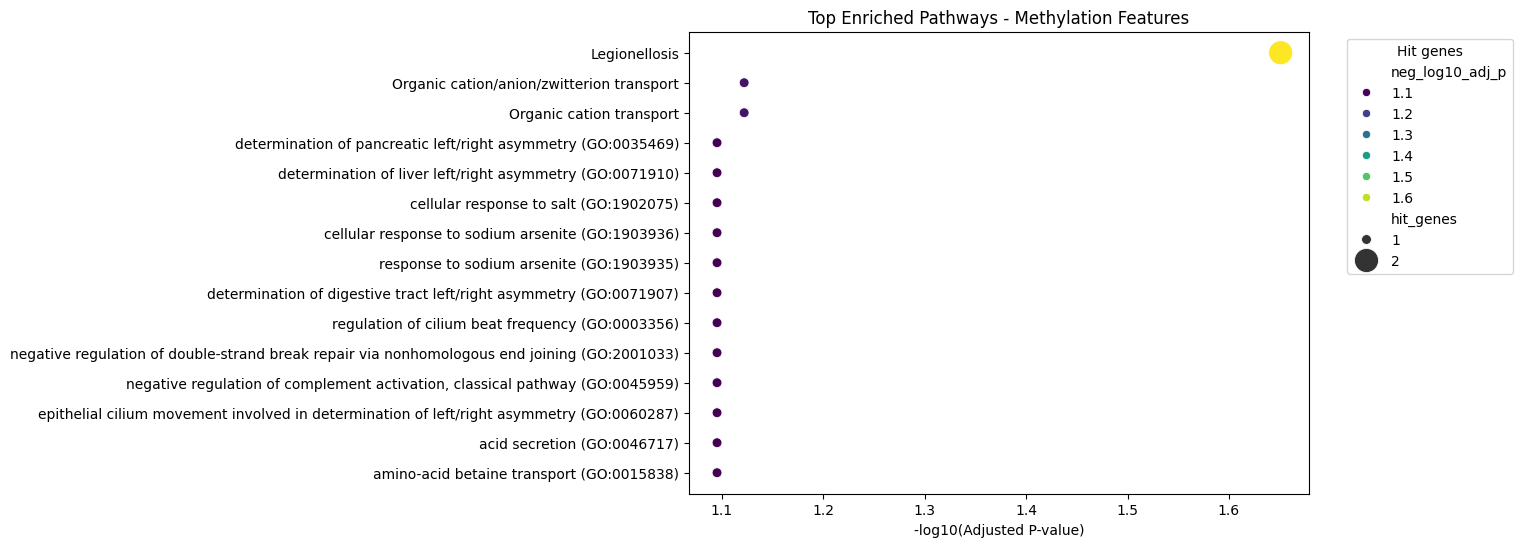

/tmp/ipython-input-1496226888.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='neg_log10_adj_p', y='Term', palette='coolwarm')


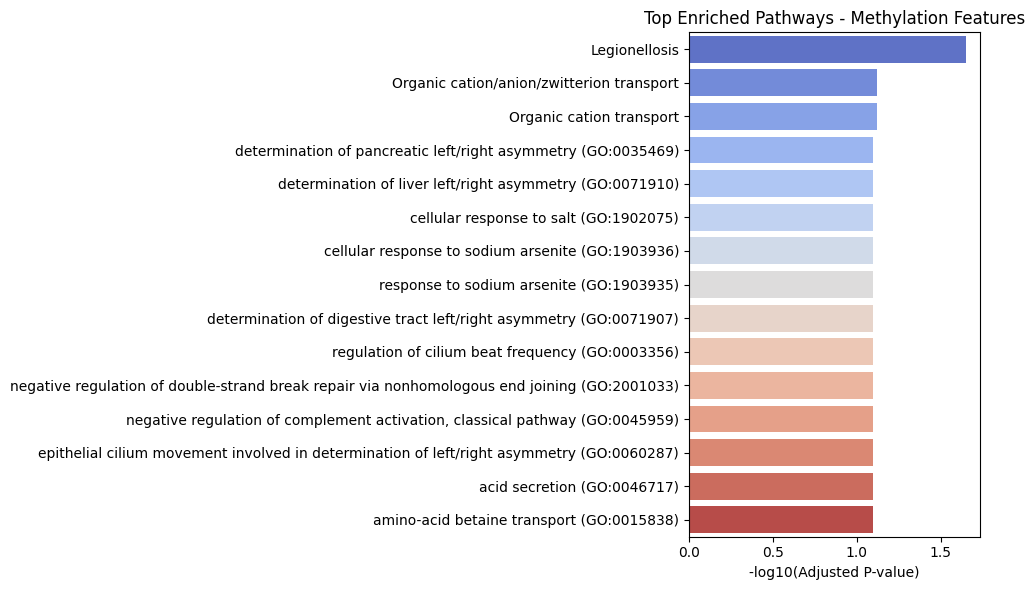

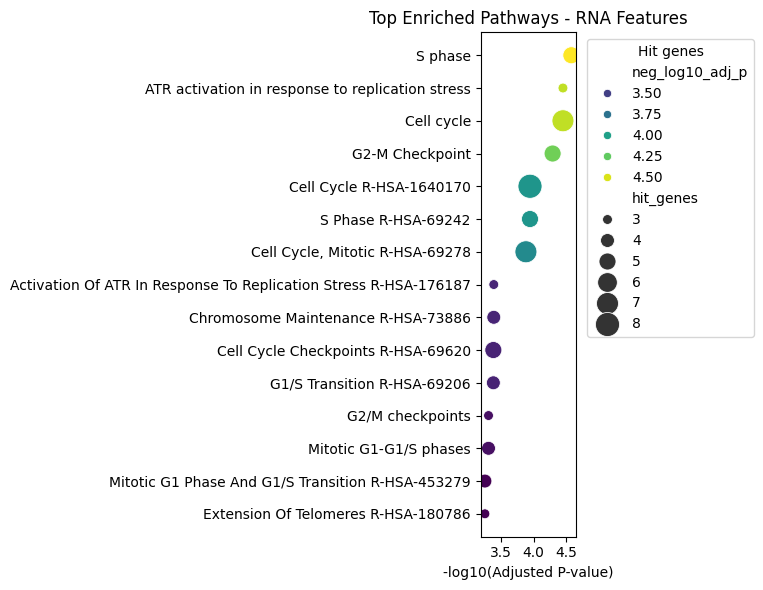

/tmp/ipython-input-1496226888.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='neg_log10_adj_p', y='Term', palette='coolwarm')


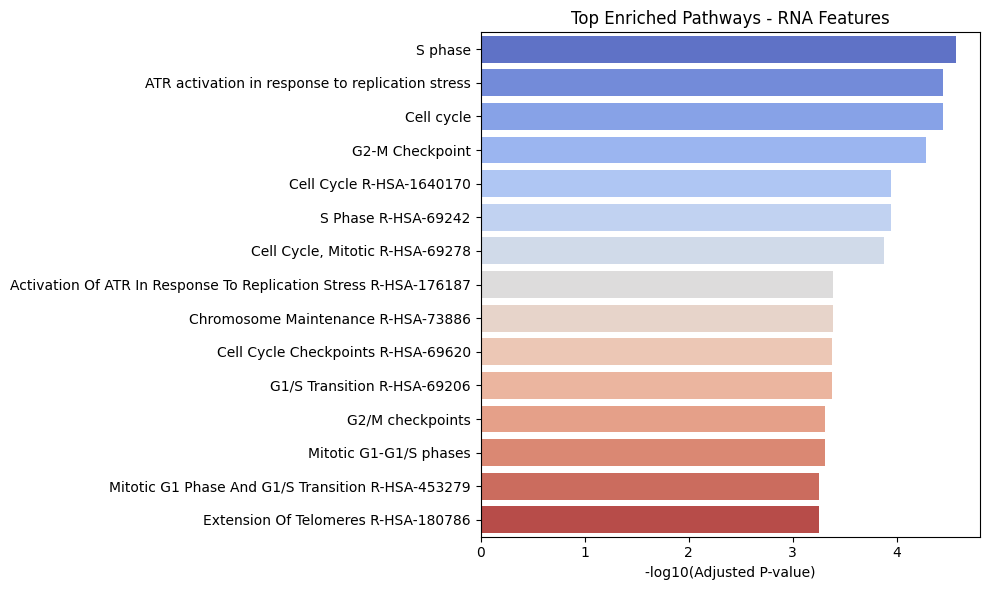

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def preprocess_df(df):
    # Calculate-log10(Adjusted P)
    df['neg_log10_adj_p'] = -np.log10(df['Adjusted P-value'])
    # Hit genes and total genes
    df['hit_genes'] = df['Overlap'].apply(lambda x: int(x.split('/')[0]))
    df['total_genes'] = df['Overlap'].apply(lambda x: int(x.split('/')[1]))
    return df

def plot_dotplot(df, title, top_n=15):
    df = df.sort_values('Adjusted P-value').head(top_n)
    plt.figure(figsize=(8, top_n * 0.4))
    sns.scatterplot(data=df, x='neg_log10_adj_p', y='Term',
                    size='hit_genes', hue='neg_log10_adj_p', palette='viridis', sizes=(50, 300), legend='brief')
    plt.xlabel('-log10(Adjusted P-value)')
    plt.ylabel('')
    plt.title(title)
    plt.legend(title='Hit genes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_barplot(df, title, top_n=15):
    df = df.sort_values('Adjusted P-value').head(top_n)
    plt.figure(figsize=(10, top_n * 0.4))
    sns.barplot(data=df, x='neg_log10_adj_p', y='Term', palette='coolwarm')
    plt.xlabel('-log10(Adjusted P-value)')
    plt.ylabel('')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ------------------
methy_df = dfc
rna_df = dfb

methy_df = preprocess_df(methy_df)
rna_df = preprocess_df(rna_df)

plot_dotplot(methy_df, 'Top Enriched Pathways - Methylation Features')
plot_barplot(methy_df, 'Top Enriched Pathways - Methylation Features')

plot_dotplot(rna_df, 'Top Enriched Pathways - RNA Features')
plot_barplot(rna_df, 'Top Enriched Pathways - RNA Features')


In [ ]:
df_enrich

,Term,Genes,neg_log10_adj_p,hit_genes,total_genes,Source
0,Legionellosis,CR1L;HSF1,1.650943,2,57,Methyl
1,determination of pancreatic left/right asymmet...,CCDC40,1.095425,1,5,Methyl
2,cellular response to sodium arsenite (GO:1903936),HSF1,1.095425,1,5,Methyl
3,response to sodium arsenite (GO:1903935),HSF1,1.095425,1,5,Methyl
4,determination of liver left/right asymmetry (G...,CCDC40,1.095425,1,6,Methyl
...,...,...,...,...,...,...
59,DNA replication pre-Initiation,CCNA2;CDC45,1.533101,2,88,RNA
60,G2 phase pathway,CCNA2,1.510164,1,5,RNA
61,Cyclin B2-mediated events,CDC25A,1.510164,1,5,RNA
62,Oncostatin M,CCNA2;KRT16;CKS1B,1.501653,3,311,RNA


###### 4.5.2 Gene path network

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def build_gene_pathway_network(df_meth, df_rna, label1="Methylation", label2="RNA", top_n=10):
    # only keep top_n path for visualization
    df_meth_top = df_meth.head(top_n).copy()
    df_rna_top = df_rna.head(top_n).copy()

    # Add Source Label
    df_meth_top["Source"] = label1
    df_rna_top["Source"] = label2

    # combine
    df_all = pd.concat([df_meth_top, df_rna_top], ignore_index=True)

    # Create NetworkX Plot
    G = nx.Graph()

    for idx, row in df_all.iterrows():
        pathway = f"{row['Source']} | {row['Term']}"
        genes = row["Genes"].split(';')

        #  Add path Nodes
        G.add_node(pathway, type="pathway", source=row["Source"])

        for gene in genes:
            gene = gene.strip()
            G.add_node(gene, type="gene")
            G.add_edge(gene, pathway)

    return G

# Visualization
def plot_gene_pathway_network(G, figsize=(14, 10)):
    plt.figure(figsize=figsize)

    color_map = []
    for node in G.nodes(data=True):
        if node[1]["type"] == "gene":
            color_map.append("#1f77b4")  # Blue
        elif node[1]["source"] == "Methylation":
            color_map.append("#ff7f0e")  # Orange
        else:
            color_map.append("#2ca02c")  # Green

    pos = nx.spring_layout(G, k=0.4)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color=color_map, font_size=8, edge_color="#aaaaaa")
    plt.title("Integrated Gene–Pathway Enrichment Network", fontsize=16)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-639047835.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


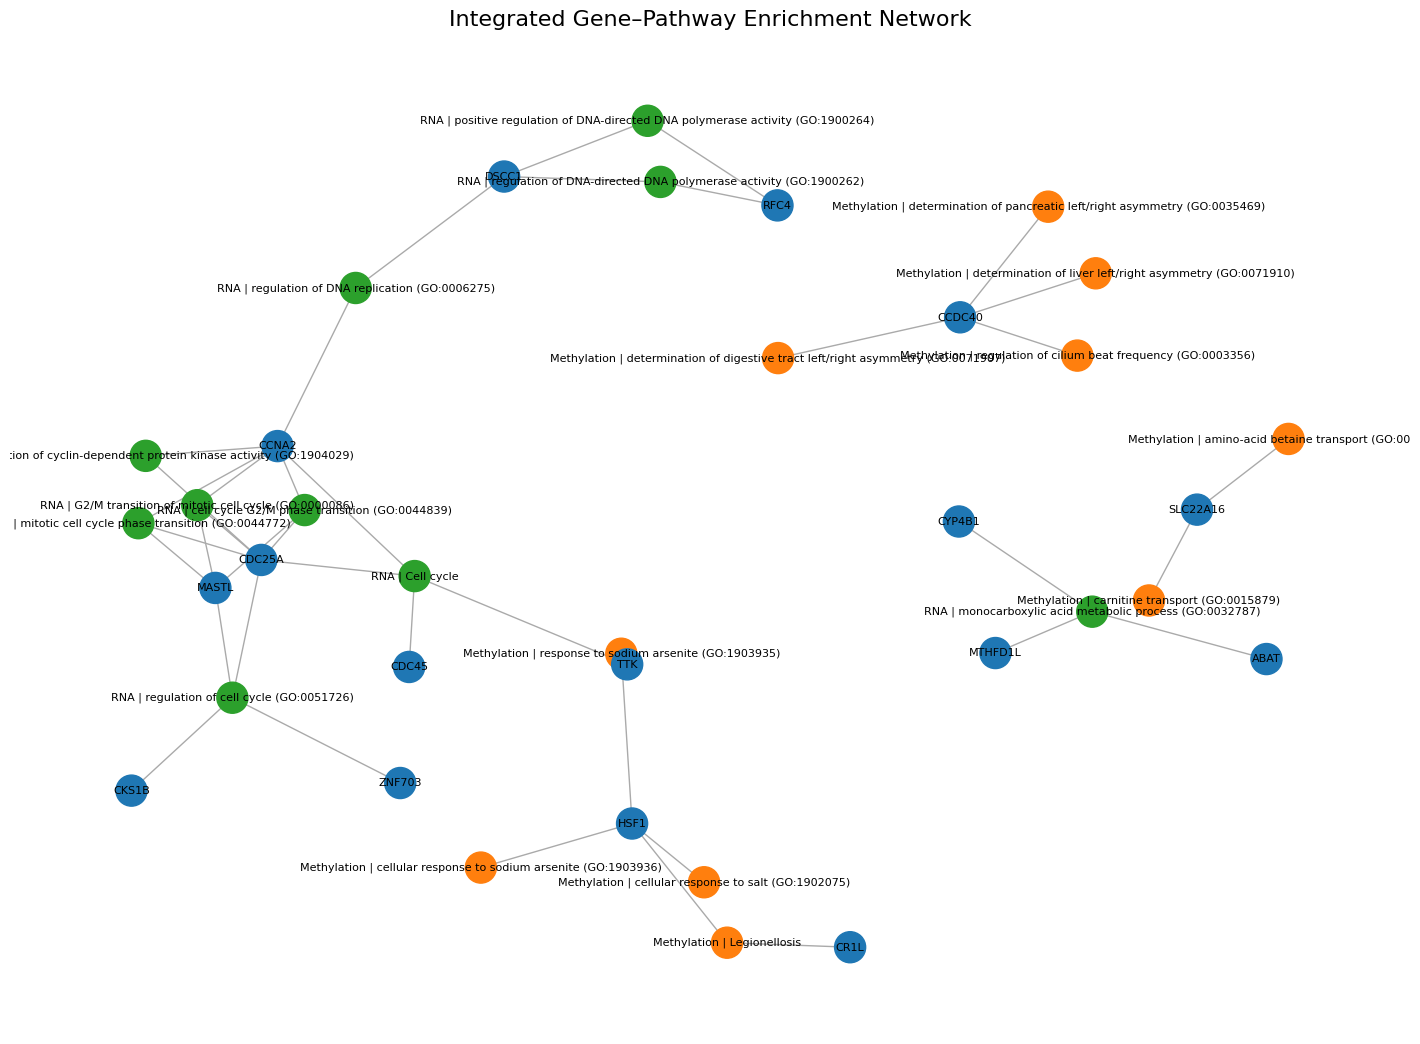

In [ ]:
df_meth = dfc
df_rna = dfb
G = build_gene_pathway_network(df_meth, df_rna, top_n=10)
plot_gene_pathway_network(G)

###### 4.5.3 Enriched Path Analysis by SubType

In [ ]:
methyl_express = pd.DataFrame(methyl_scaled.numpy(), columns=methyl_filled_cols)
methyl_express.index = methyl_aligned.index
methyl_express.index.name = 'SampleID'
methyl_express = methyl_express[top_cpg_n]
print(methyl_express.shape)

rna_express = pd.DataFrame(rna_selected.numpy(), columns=rna_selected_columns)
rna_express.index = rna_filtered.index
rna_express.index.name = 'SampleID'
rna_express = rna_express[top_rna_n]
print(rna_express.shape)

In [ ]:
# Merge DataFrames on index
merged_df = pd.merge(methyl_express, rna_express, left_index=True, right_index=True, how='inner')
merged_df = pd.merge(labels_aligned, merged_df, left_index=True, right_index=True, how='inner')
print("Merged DataFrame using pd.merge():")
print(merged_df.shape)

Merged DataFrame using pd.merge():
(533, 51)


In [ ]:
mapped1 = mapped[~mapped['UCSC_RefGene_Name'].isna()]
methyl_express_df =merged_df[top_cpg_n]
map_dict = dict(zip(mapped1['IlmnID'], mapped1['UCSC_RefGene_Name']))

In [ ]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Reversed map：Gene -> CpG
gene2cpg = defaultdict(list)
for cpg, genes in map_dict.items():
    for gene in genes.split(';'):
        gene2cpg[gene].append(cpg)

In [ ]:
# Aggregate CpG at gene level
gene_methyl_df = pd.DataFrame(index=methyl_express_df.index)
for gene, cpgs in gene2cpg.items():
    valid_cpgs = [cpg for cpg in cpgs if cpg in methyl_express_df.columns]
    if valid_cpgs:
        gene_methyl_df[gene] = methyl_express_df[valid_cpgs].mean(axis=1)

In [ ]:
methyl_express_df_t =  gene_methyl_df.T
methyl_express_df_t.index = methyl_express_df_t.index.str.upper()

In [ ]:
rna_express_df = merged_df[top_rna_n]

In [ ]:
rna_express_df_t = rna_express_df.T
rna_express_df_t.index = rna_express_df_t.index.str.upper()

In [ ]:
subtype_map = merged_df['PAM50'].to_dict()

In [ ]:
with open("methyl_pathways2.gmt", "w") as f:
    for _, row in df_meth[['Term', 'Genes']].iterrows():
        term = row["Term"].replace(" ", "_")  # GMT format prefers no spaces
        genes = row["Genes"].split(";")
        f.write(f"{term}\tNA\t" + "\t".join(genes) + "\n")

with open("rna_pathways2.gmt", "w") as f:
    for _, row in df_rna[['Term', 'Genes']].iterrows():
        term = row["Term"].replace(" ", "_")  # GMT format prefers no spaces
        genes = row["Genes"].split(";")
        f.write(f"{term}\tNA\t" + "\t".join(genes) + "\n")

RNA by SubType

In [ ]:
import gseapy as gp
ss = gp.ssgsea(data=rna_express_df_t,
               gene_sets="rna_pathways2.gmt",
               sample_norm_method='rank',  # nonparametric approach
               outdir=None,
               verbose=True,
               min_size=5,
               scale=True,
               permutation_num=0)  # no permutation for ssGSEA

enrichment_scores = ss.res2d
enrichment_scores = enrichment_scores.set_index('Name')
enrichment_scores.index.name = 'SampleID'
enrichment_scores['Subtype'] = enrichment_scores.index.map(subtype_map)
enrichment_scores = enrichment_scores.dropna(subset=["Subtype"])

2025-08-24 23:49:36,088 [INFO] Parsing data files for ssGSEA...........................
2025-08-24 23:49:36,093 [INFO] 0056 gene_sets have been filtered out when max_size=500 and min_size=5
2025-08-24 23:49:36,094 [INFO] 0007 gene_sets used for further statistical testing.....
2025-08-24 23:49:36,094 [INFO] Start to run ssGSEA...Might take a while................


In [ ]:
tcga_matrix = enrichment_scores.pivot_table(
    index="Term", columns="Subtype", values="NES", aggfunc="mean"
)
tcga_matrix.to_csv(path+'tcga_enr_subtype.csv')

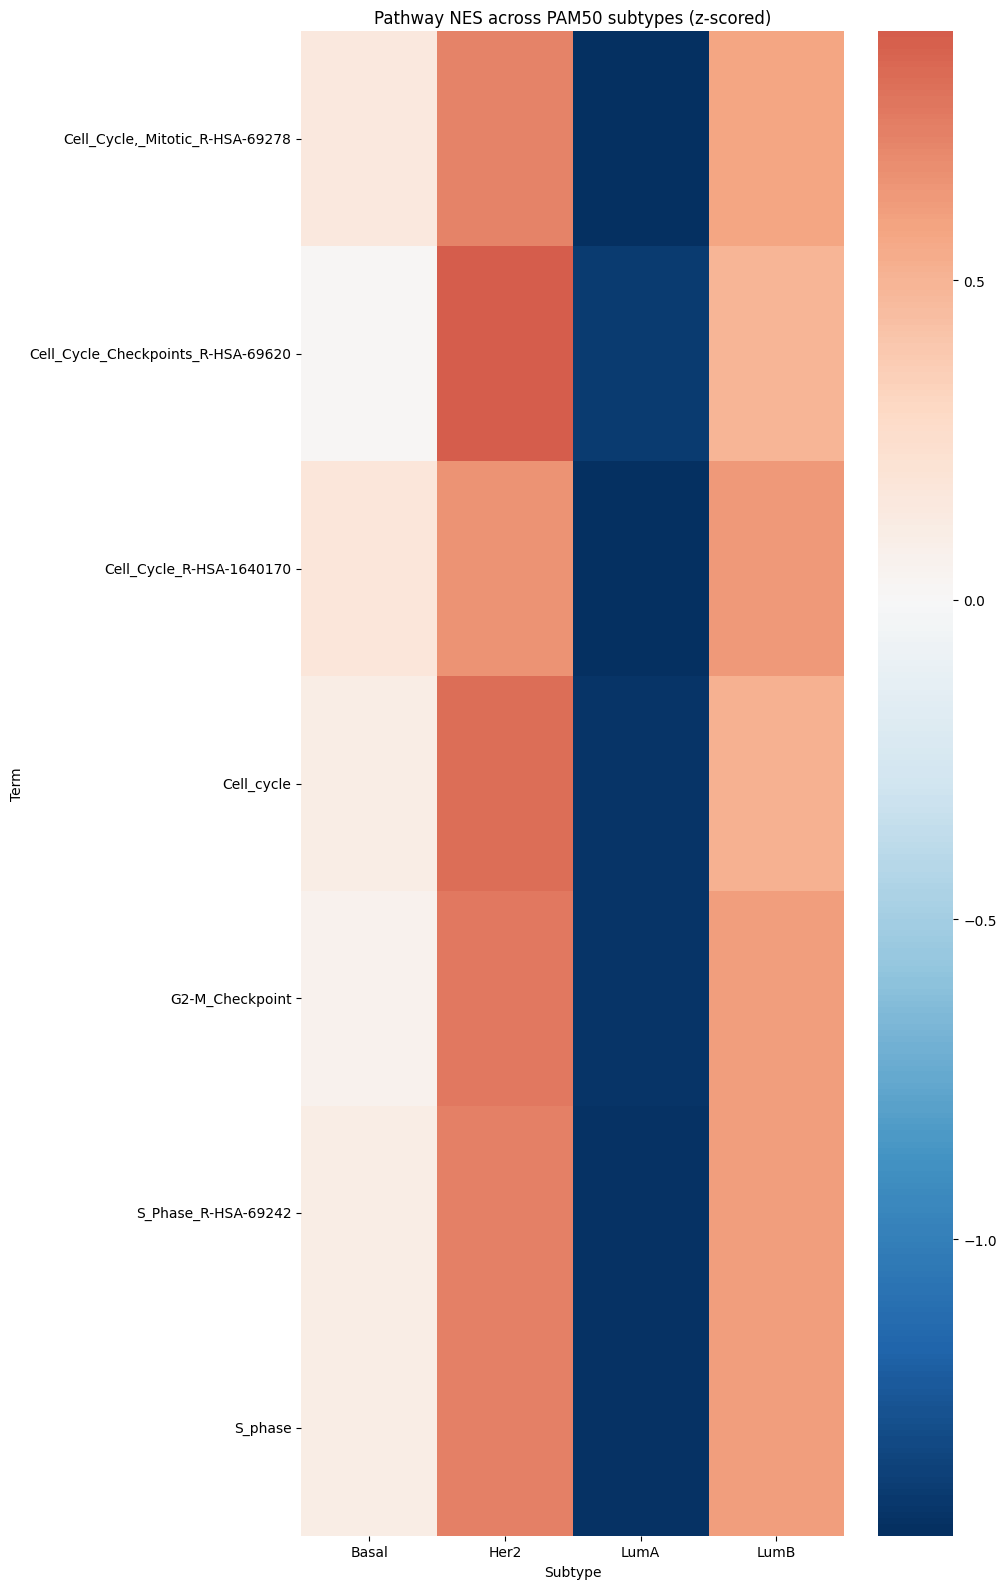

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: calculate every (Term, Subtype) average NES
pivot_df = enrichment_scores.groupby(['Term', 'Subtype'])['NES'].mean().unstack()

# Step 2: z-score standardize single pathway
pivot_df_z = pivot_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
pivot_df_z = pivot_df_z.astype(float).fillna(0)

# Step 3: heatmap
plt.figure(figsize=(10, 16))
sns.heatmap(pivot_df_z, cmap="RdBu_r", center=0, annot=False)
plt.title("Pathway NES across PAM50 subtypes (z-scored)")
plt.tight_layout()
plt.show()

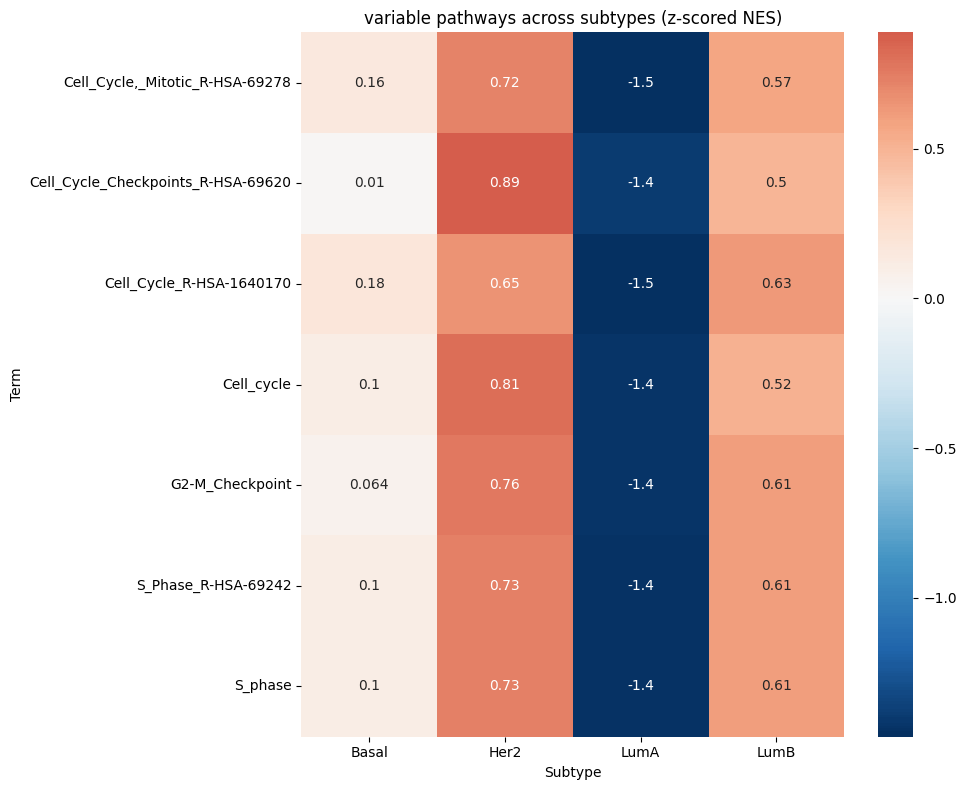

In [ ]:
# Get the top 20 path with largest NES variance
top_terms = enrichment_scores.groupby('Term')['NES'].std().sort_values(ascending=False).head(20).index.tolist()

# heatmap with the selected path
top_df_rna = enrichment_scores[enrichment_scores['Term'].isin(top_terms)]
pivot_df_rna = top_df_rna.groupby(['Term', 'Subtype'])['NES'].mean().unstack()

# Step 2: z-score standardize single path
pivot_df_rna_z = pivot_df_rna.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
pivot_df_rna_z = pivot_df_rna_z.astype(float).fillna(0)


# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df_rna_z, cmap="RdBu_r", center=0, annot=True)
plt.title("variable pathways across subtypes (z-scored NES)")
plt.tight_layout()
plt.show()

Methyl by Subtype

In [ ]:
import gseapy as gp
ss = gp.ssgsea(data=methyl_express_df_t,
               gene_sets="methyl_pathways2.gmt",
               sample_norm_method='rank',  #non parametic approach
               outdir=None,
               verbose=True,
               min_size= 2,
               scale=True,
               permutation_num=0)  # no permutation for ssGSEA

enrichment_scores = ss.res2d
enrichment_scores = enrichment_scores.set_index('Name')
enrichment_scores.index.name = 'SampleID'
enrichment_scores['Subtype'] = enrichment_scores.index.map(subtype_map)
enrichment_scores = enrichment_scores.dropna(subset=["Subtype"])

2025-08-24 23:49:52,962 [INFO] Parsing data files for ssGSEA...........................
2025-08-24 23:49:52,967 [INFO] 0068 gene_sets have been filtered out when max_size=500 and min_size=2
2025-08-24 23:49:52,967 [INFO] 0002 gene_sets used for further statistical testing.....
2025-08-24 23:49:52,968 [INFO] Start to run ssGSEA...Might take a while................


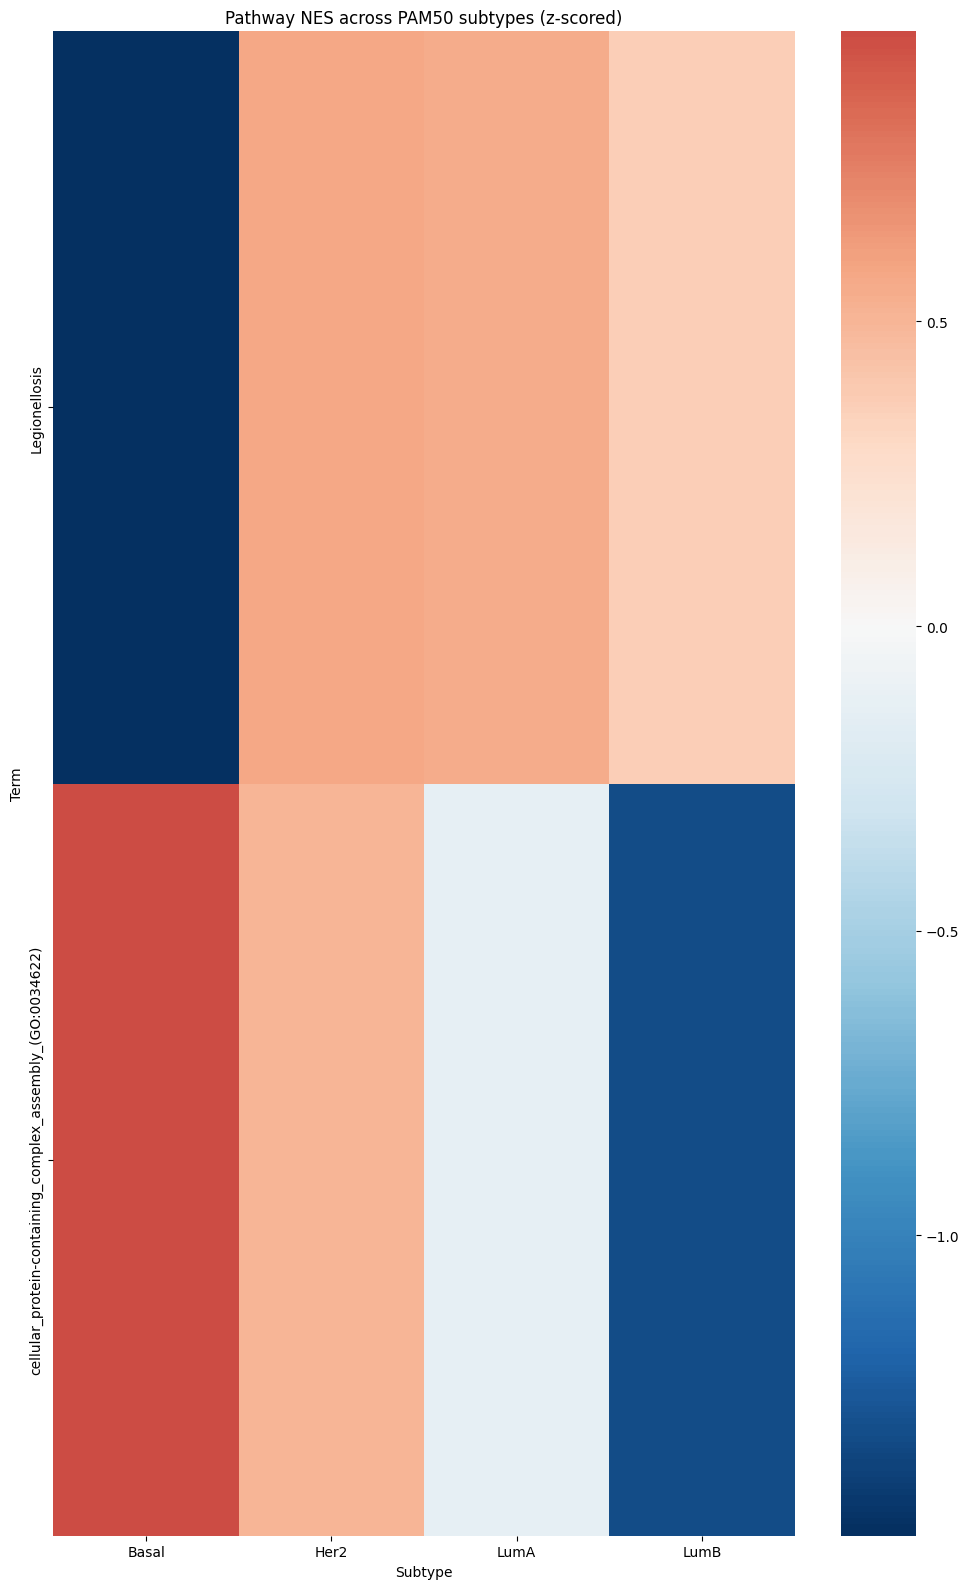

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: calculate every (Term, Subtype) average NES
pivot_df = enrichment_scores.groupby(['Term', 'Subtype'])['NES'].mean().unstack()

# Step 2: z-score standardize single path
pivot_df_z = pivot_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
pivot_df_z = pivot_df_z.astype(float).fillna(0)

# Step 3: heatmap
plt.figure(figsize=(10, 16))
sns.heatmap(pivot_df_z, cmap="RdBu_r", center=0, annot=False)
plt.title("Pathway NES across PAM50 subtypes (z-scored)")
plt.tight_layout()
plt.show()

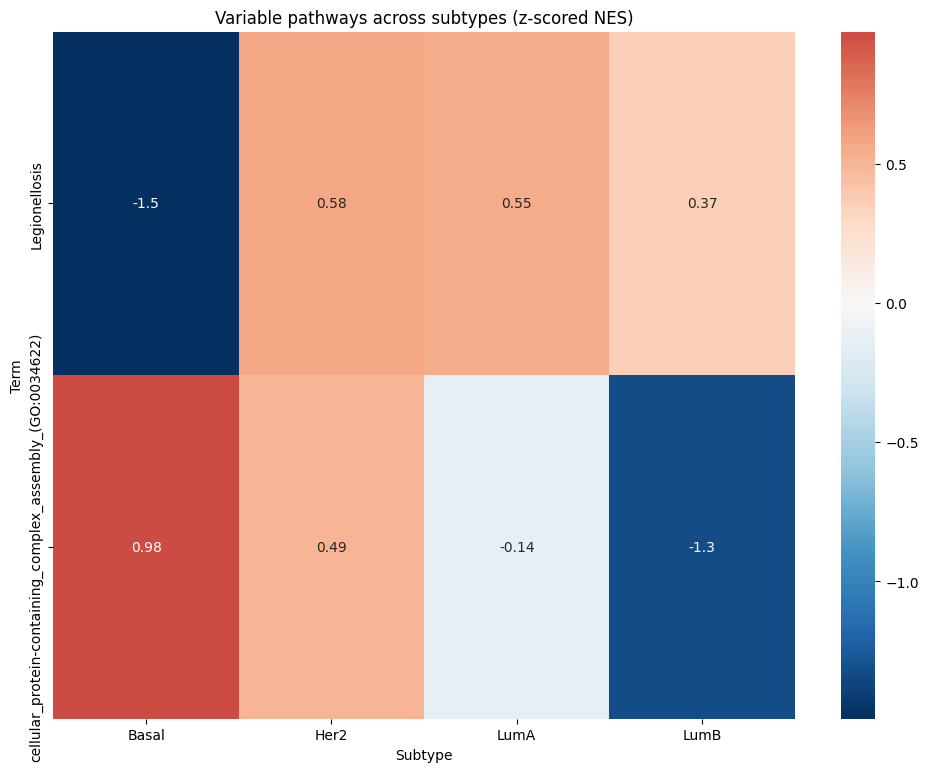

In [ ]:
# Get the top 20 path with largest NES variance
top_terms = enrichment_scores.groupby('Term')['NES'].std().sort_values(ascending=False).head(20).index.tolist()

# heatmap with the selected map
top_df_meth = enrichment_scores[enrichment_scores['Term'].isin(top_terms)]
pivot_df_meth = top_df_meth.groupby(['Term', 'Subtype'])['NES'].mean().unstack()

# Step 2: z-score standardize single path
pivot_df_meth_z = pivot_df_meth.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
pivot_df_meth_z = pivot_df_meth_z.astype(float).fillna(0)


# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df_meth_z, cmap="RdBu_r", center=0, annot=True)
plt.title("Variable pathways across subtypes (z-scored NES)")
plt.tight_layout()
plt.show()

##### 4.6 Cross Validation Light Weight

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np, methyl_pca_dim=500):
    # PCA Methyl

    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_np)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for methyl, rna, label in dataloader:
        methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
        optimizer.zero_grad()
        logits = model(methyl, rna)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl, rna, y in loader:
            methyl, rna, y = methyl.to(device), rna.to(device), y.to(device)
            out = model(methyl, rna)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)


def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl, rna, label in dataloader:
            methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
            logits = model(methyl, rna)
            loss = criterion(logits, label)
            total_loss += loss.item() * label.size(0)
            total_samples += label.size(0)
    return total_loss / total_samples


if __name__ == "__main__":

    #methyl_np = methyl_scaled  # shape (N, 50000)
    methyl_np = methyl_filled[:, top_cpg_methyl_aligned_index]
    rna_np = rna_selected[:, top_rna_selected_index]     # shape (N, 300)
    labels_np = y_label  # shape (N, )

    batch_size = 8
    #methyl_dim = 50000
    #rna_dim = 300
    num_classes = 4
    learning_rate = 5e-5
    patience_ = 5
    methyl_pca_dim = 25
    seq_len = 1

    methyl_tensor, rna_tensor, y_tensor = preprocess_data(methyl_np, rna_np, labels_np, methyl_pca_dim = methyl_pca_dim)
    #dataset = BRCA_MultiModalDataset(methyl_np, rna_np, labels_np)
    dataset = TensorDataset(methyl_tensor, rna_tensor, y_tensor)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    g = torch.Generator()
    g.manual_seed(42)
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
      print(f"\nFold {fold + 1}")

      # Use Subset to split dataset
      train_dataset = Subset(dataset, train_idx)
      inf_dataset = Subset(dataset, val_idx)

      total_len = len(train_dataset)
      train_len = int(0.85 * total_len)
      val_len = total_len - train_len
      train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator = g)
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator = g)
      val_loader = DataLoader(val_subset, batch_size=batch_size, generator = g)
      inf_loader = DataLoader(inf_dataset, batch_size=batch_size, generator = g)

      device = "cuda" if torch.cuda.is_available() else "cpu"
      #model = MultiModalMambaClassifier(methyl_dim=methyl_np.shape[1], rna_dim=rna_np.shape[1], num_classes=5).to(device)
      model = MultiModalMambaClassifier2(methyl_dim=methyl_tensor.shape[1], rna_dim=rna_tensor.shape[1], num_classes=4, seq_len = 2).to(device)

      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      criterion = torch.nn.CrossEntropyLoss()
      early_stopper = EarlyStopping(patience=patience_, mode='min', save_path=f"best_model_531_fold{fold}_cg.pt")

      epochs = 100
      for epoch in range(epochs):
          train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
          val_loss = evaluate_loss(model, val_loader, criterion, device)
          print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
          early_stopper.step(val_loss, model)

          if early_stopper.early_stop:
              print(f"Early stopping triggered at epoch {epoch+1}")
              break

      # Load the best model parameter weights
      model.load_state_dict(early_stopper.best_state)
      inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, inf_loader, device)
      print(f"Inf accuracy: {inf_acc:.4f}")
      print(f"Inf precision: {inf_pre}")
      print(f"Inf recall: {inf_rec}")
      print(f"Inf f1: {inf_f1}")
      accuracy_scores.append(inf_acc)
      precision_scores.append(inf_pre)
      recall_scores.append(inf_rec)
      f1_scores.append(inf_f1)
    print(f"Average accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average precision: {np.mean(precision_scores, axis=0)}")
    print(f"Average recall: {np.mean(recall_scores, axis=0)}")
    print(f"Average f1: {np.mean(f1_scores, axis=0)}")
    print(f"Accuracy scores: {accuracy_scores}")
    print(f"Precision scores: {precision_scores}")
    print(f"Recall scores: {recall_scores}")
    print(f"F1 scores: {f1_scores}")



Fold 1
Epoch 1: Train Loss=1.0959, Val Loss=0.9021
Epoch 2: Train Loss=0.6744, Val Loss=0.6490
Epoch 3: Train Loss=0.4806, Val Loss=0.5298
Epoch 4: Train Loss=0.3631, Val Loss=0.4607
Epoch 5: Train Loss=0.2810, Val Loss=0.4200
Epoch 6: Train Loss=0.2206, Val Loss=0.3910
Epoch 7: Train Loss=0.1751, Val Loss=0.3687
Epoch 8: Train Loss=0.1294, Val Loss=0.3585
Epoch 9: Train Loss=0.0971, Val Loss=0.3578
Epoch 10: Train Loss=0.0745, Val Loss=0.3556
Epoch 11: Train Loss=0.0551, Val Loss=0.3617
Epoch 12: Train Loss=0.0452, Val Loss=0.3653
Epoch 13: Train Loss=0.0333, Val Loss=0.3659
Epoch 14: Train Loss=0.0267, Val Loss=0.3718
Epoch 15: Train Loss=0.0223, Val Loss=0.3766
Early stopping triggered at epoch 15
Inf accuracy: 0.9252
Inf precision: [0.93846154 0.875      1.         1.        ]
Inf recall: [0.953125   0.90322581 0.5        1.        ]
Inf f1: [0.94573643 0.88888889 0.66666667 1.        ]

Fold 2
Epoch 1: Train Loss=1.1588, Val Loss=0.8389
Epoch 2: Train Loss=0.6879, Val Loss=0.5225

Lightweight 90.25% to 89.87%

##### 4.7 Final model without Testing

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import joblib

# --------- Data Preprocess ---------
def preprocess_data(methyl_np, rna_np, y_np):
   """
    Scale methylation and RNA features using StandardScaler and convert them to tensors.

    Parameters
    ----------
    methyl_np : ndarray
        Raw methylation feature matrix (samples × CpGs).
    rna_np : ndarray
        Raw RNA expression matrix (samples × genes).
    y_np : ndarray
        Class label array.

    Returns
    -------
    methyl_tensor : torch.FloatTensor
        Standardized methylation features.
    rna_tensor : torch.FloatTensor
        Standardized RNA features.
    y_tensor : torch.LongTensor
        Integer class labels.
    scaler_methyl : StandardScaler
        Fitted scaler for methylation data.
    scaler_rna : StandardScaler
        Fitted scaler for RNA data.
    """
    # PCA Methyl
    scaler_methyl = StandardScaler()
    methyl_scaled = scaler_methyl.fit_transform(methyl_np)
    scaler_rna = StandardScaler()
    rna_scaled = scaler_rna.fit_transform(rna_np)
    methyl_tensor = torch.FloatTensor(methyl_scaled)
    rna_tensor = torch.FloatTensor(rna_scaled)
    y_tensor = torch.LongTensor(y_np)
    return methyl_tensor, rna_tensor, y_tensor, scaler_methyl, scaler_rna

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train the model for a single epoch.

    Parameters
    ----------
    model : nn.Module
        Model to be trained.
    dataloader : DataLoader
        Training dataloader providing (methyl, rna, label).
    optimizer : torch.optim.Optimizer
        Optimizer used for updating weights.
    criterion : loss function
        Loss function such as CrossEntropyLoss.
    device : str
        'cuda' or 'cpu'.

    Returns
    -------
    float
        Mean training loss for the epoch.
    """
    model.train()
    total_loss = 0
    for methyl, rna, label in dataloader:
        methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
        optimizer.zero_grad()
        logits = model(methyl, rna)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, loader, device):
    """
    Evaluate a trained model on a dataset, returning accuracy, precision, recall, and F1.

    Parameters
    ----------
    model : nn.Module
        Model to evaluate.
    loader : DataLoader
        Evaluation dataloader.
    device : str
        'cuda' or 'cpu'.

    Returns
    -------
    accuracy : float
    precision : ndarray
        Per-class precision.
    recall : ndarray
        Per-class recall.
    f1 : ndarray
        Per-class F1 score.
    """
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for methyl, rna, y in loader:
            methyl, rna, y = methyl.to(device), rna.to(device), y.to(device)
            out = model(methyl, rna)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return accuracy_score(targets.numpy(), preds.numpy()), precision_score(targets.numpy(), preds.numpy(), average=None), recall_score(targets.numpy(), preds.numpy(), average=None), f1_score(targets.numpy(), preds.numpy(), average = None)


def evaluate_loss(model, dataloader, criterion, device):
    """
    Compute the mean validation/test loss over a dataset.

    Parameters
    ----------
    model : nn.Module
        Trained model.
    dataloader : DataLoader
        Validation or test dataloader.
    criterion : loss function
        Loss function used for evaluation.
    device : str
        'cuda' or 'cpu'.

    Returns
    -------
    float
        Average loss across all samples.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for methyl, rna, label in dataloader:
            methyl, rna, label = methyl.to(device), rna.to(device), label.to(device)
            logits = model(methyl, rna)
            loss = criterion(logits, label)
            total_loss += loss.item() * label.size(0)
            total_samples += label.size(0)
    return total_loss / total_samples


if __name__ == "__main__":

    batch_size = 8
    #methyl_dim = 50000
    #rna_dim = 300
    num_classes = 4
    learning_rate = 5e-5
    patience_ = 5
    methyl_pca_dim = 500
    seq_len = 1

    #lw_try = df_methyl_shap[:25]['feature'].tolist() + df_rna_shap[:25]['feature'].tolist()
    methyl_np_lw = methyl_filled[:, top_cpg_methyl_aligned_index]
    rna_selected_lw = rna_selected[:, top_rna_selected_index]
    labels_np = y_label  # shape (N, )

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    methyl_tensor1, rna_tensor1, y_tensor1, scaler_methyl, scaler_rna = preprocess_data(methyl_np_lw, rna_selected_lw, labels_np)
    joblib.dump(scaler_methyl, path+"scaler_methyl_lw.pkl")
    joblib.dump(scaler_rna, path+"scaler_rna_lw.pkl")
    dataset = TensorDataset(methyl_tensor1, rna_tensor1, y_tensor1)

    total_len = len(dataset)
    train_len = int(0.85 * total_len)
    val_len = total_len - train_len
    train_subset, val_subset = random_split(dataset, [train_len, val_len], generator = g)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator = g)
    val_loader = DataLoader(val_subset, batch_size=batch_size, generator = g)

    model = MultiModalMambaClassifier2(methyl_dim=methyl_tensor1.shape[1], rna_dim=rna_tensor1.shape[1], num_classes=4, seq_len = 2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopping(patience=patience_, mode='min', save_path=path+"best_model_53_lw_n1.pt")

    epochs = 100
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate_loss(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        early_stopper.step(val_loss, model)

        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model parameter weights
    model.load_state_dict(early_stopper.best_state)
    inf_acc, inf_pre, inf_rec, inf_f1 = evaluate_model(model, val_loader, device)
    print(f"Validation accuracy: {inf_acc:.4f}")
    print(f"Validation precision: {inf_pre}")
    print(f"Validation recall: {inf_rec}")
    print(f"Validation f1: {inf_f1}")

Epoch 1: Train Loss=1.1004, Val Loss=0.7894
Epoch 2: Train Loss=0.6108, Val Loss=0.5184
Epoch 3: Train Loss=0.4157, Val Loss=0.4013
Epoch 4: Train Loss=0.3209, Val Loss=0.3314
Epoch 5: Train Loss=0.2488, Val Loss=0.2871
Epoch 6: Train Loss=0.1950, Val Loss=0.2563
Epoch 7: Train Loss=0.1574, Val Loss=0.2358
Epoch 8: Train Loss=0.1216, Val Loss=0.2249
Epoch 9: Train Loss=0.0938, Val Loss=0.2147
Epoch 10: Train Loss=0.0730, Val Loss=0.2069
Epoch 11: Train Loss=0.0557, Val Loss=0.2063
Epoch 12: Train Loss=0.0423, Val Loss=0.2022
Epoch 13: Train Loss=0.0325, Val Loss=0.2054
Epoch 14: Train Loss=0.0253, Val Loss=0.2076
Epoch 15: Train Loss=0.0197, Val Loss=0.2093
Epoch 16: Train Loss=0.0161, Val Loss=0.2096
Epoch 17: Train Loss=0.0134, Val Loss=0.2121
Early stopping triggered at epoch 17
Validation accuracy: 0.9250
Validation precision: [0.97727273 0.83333333 0.75       1.        ]
Validation recall: [0.95555556 0.95238095 0.6        0.88888889]
Validation f1: [0.96629213 0.88888889 0.666666

In [ ]:
methyl_tensor2 = torch.FloatTensor(scaler_methyl_n.transform(methyl_np_lw[test_idx_a]))
rna_tensor2 = torch.FloatTensor(scaler_rna_n.transform(rna_selected_lw[test_idx_a]))
y_tensor2 = torch.LongTensor(labels_np[test_idx_a])
inference_dataset = TensorDataset(methyl_tensor2[0:10], rna_tensor2[0:10], y_tensor2[0:10])

In [ ]:
test_idx_a

array([524, 181,  61, 488, 127, 272, 139, 493,  97, 113, 232, 376, 305,
       256, 102, 184,  40, 474, 193, 188, 482, 245, 264, 435, 502,  78,
       518, 348, 521, 238,  86, 370, 331, 196, 497, 507,  93, 294, 198,
        18, 318, 326, 144, 145, 532, 286, 460,  37, 110, 207, 449, 159,
       223,  41, 171,  17, 503, 155, 268, 333,  62, 514, 372, 374,  34,
       288, 219, 414, 154, 369, 273,  32, 244, 337, 157,  31, 175,  89,
       409, 461, 163,  92, 471, 247, 250, 396, 384, 407,  66, 341, 321,
        87, 485, 108,  85, 135, 148, 486, 190, 297, 204,  27, 469, 255,
       442, 312, 130])

In [ ]:
test_loader = DataLoader(inference_dataset, batch_size=1, shuffle = False, generator = g)
model1 = MultiModalMambaClassifier2(methyl_dim=25, rna_dim=25, num_classes=4, seq_len = 2).to(device)
#model1.load_state_dict(path+'model_artifact/Mamba/best_model_5_lw_2.pt')
    ##early_stopper.best_state
#state_dict = torch.load(path+'model_artifact/Mamba/best_model_5_lw.pt', map_location=torch.device('cpu'))
state_dict = torch.load(path+'best_model_53_lw_n1.pt', map_location=torch.device('cpu'))
model1.load_state_dict(state_dict)
model1.eval()
with torch.no_grad():
  c=0
  for methyl, rna, y in test_loader:
    methyl, rna, y= methyl.to(device), rna.to(device), y.to(device)
    logits = model1(methyl, rna)
    preds = torch.argmax(logits, dim=1)
    print(preds, y)
    if preds==y:
      c+=1
  print('inference accuracy ', c/len(test_loader))

tensor([1], device='cuda:0') tensor([1], device='cuda:0')
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
tensor([3], device='cuda:0') tensor([3], device='cuda:0')
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
tensor([3], device='cuda:0') tensor([3], device='cuda:0')
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
tensor([1], device='cuda:0') tensor([1], device='cuda:0')
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
tensor([1], device='cuda:0') tensor([1], device='cuda:0')
inference accuracy  1.0


In [ ]:
traced_model = torch.jit.trace(model1.to('cpu'), (methyl_tensor2[0:1,], rna_tensor2[0:1,]))
traced_model.save("mamba_ts5.pt")
#traced_model.save(path+"files/mamba_ts1.pt")
traced_model.save(path+"mamba_ts5.pt")

/usr/local/lib/python3.12/dist-packages/transformers/models/mamba/modeling_mamba.py:353: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if cache_position.shape[0] == self.conv_kernel_size:


In [ ]:
with torch.no_grad():
    logits = traced_model(methyl_tensor2[0:1], rna_tensor2[0:1])
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    print(probs)

[0.04329038 0.95233417 0.00225281 0.00212259]


In [ ]:
methyl_tensor2, rna_tensor2, y_tensor2

(tensor([[-1.3153, -0.9014,  0.9437,  ...,  0.2384, -0.9877, -1.2313],
         [ 0.3206,  1.6907,  1.0099,  ...,  0.2979, -0.5252,  1.1527],
         [-1.7523,  1.7798, -0.9897,  ...,  0.9567, -0.9629, -0.2998],
         ...,
         [-0.7623, -0.8769,  0.4014,  ..., -0.7860,  0.8099, -0.7207],
         [ 0.0186,  1.6988,  1.6614,  ...,  1.4048,  1.7513,  1.3298],
         [ 0.3522, -0.8533,  0.3665,  ...,  0.8487, -1.2259, -1.0240]]),
 tensor([[ 0.1999,  0.2632,  1.5688,  ..., -0.1878, -1.5685, -0.1205],
         [ 0.6404, -0.3798, -0.3470,  ...,  0.6075,  0.8100, -1.2376],
         [-1.1644,  1.3835, -2.0006,  ...,  1.7614,  1.1180,  1.5511],
         ...,
         [-0.1045, -0.4304,  0.4792,  ..., -0.3459,  0.0412, -0.3554],
         [ 1.3863, -0.0337, -0.3166,  ..., -0.8615, -1.3992,  0.0512],
         [ 0.2489,  0.9719,  1.5347,  ..., -1.5079, -0.4026,  0.2102]]),
 tensor([1, 0, 3, 0, 0, 3, 0, 1, 0, 1, 3, 0, 0, 0, 1, 0, 0, 3, 2, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 2, 0, 0, 1, 3,

In [ ]:
### Lightweight RNA Scaler
print(top_rna_n)
rna_lw_scaler_np = StandardScaler()
rna_lw_scaler_np.fit_transform(rna_filtered[top_rna_n])
import joblib
# Save to file
joblib.dump(rna_lw_scaler_np, path+"rna_scaler_np1.pkl")

['ZNF703', 'CKS1B', 'ABAT', 'CDC45', 'B3GNT5', 'ZNF552', 'GABRP', 'KRT16', 'ANKRD30A', 'PPP1R14C', 'MTHFD1L', 'RFC4', 'CDC25A', 'ZNF454', 'TTK', 'POP1', 'CCNA2', 'CYP4B1', 'ARSG', 'CENPO', 'GREB1', 'DSCC1', 'RGMA', 'BCL11A', 'MASTL']


['/content/drive/MyDrive/Colab Notebooks/BRCA/rna_scaler_np1.pkl']

##### 4.8 Final Light Weight Model Shap Value

In [ ]:
methyl_tensor1.shape, rna_tensor1.shape, y_tensor1.shape

(torch.Size([533, 25]), torch.Size([533, 25]), torch.Size([533]))

In [ ]:
import shap
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1.to(device)
model1.eval()

# take a small portion of data
background_methyl = methyl_tensor1.to(device)
background_rna = rna_tensor1.to(device)

explainer = shap.GradientExplainer(model1, [background_methyl, background_rna])

In [ ]:
import joblib

# Save
joblib.dump(explainer, path + "shap_explainer_lw_final.joblib")

# Save
joblib.dump(explainer, "shap_explainer_lw_final.joblib")

['shap_explainer_lw_final.joblib']

In [ ]:
#local importance
sample_methyl = methyl_tensor2[0:1].to(device)
sample_rna = rna_tensor2[0:1].to(device)
shap_values = explainer.shap_values([sample_methyl, sample_rna])
y_probs = torch.softmax(model1(sample_methyl, sample_rna), dim=1).cpu().detach().numpy()[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_local_shap_methyl_auto(
    shap_value,          # np.ndarray (1, n_features, n_classes)
    feature_values,       # array-like (n_features,)
    feature_names,        # list[str] length n_features
    class_prob,           # array-like (n_classes,)
    class_names=None,     # optional list[str] length n_classes
    top_n=15,
    sample_idx=0
):
    """
    Auto-selects the predicted class via argmax(class_prob) and plots top-N local SHAP
    (signed) for the given sample. Returns a ranked table.
    """
    shap_value = np.asarray(shap_value)
    feature_values = np.asarray(feature_values).ravel()
    class_prob = np.asarray(class_prob).ravel()

    # basic checks
    if shap_value.ndim != 3:
        raise ValueError("shap_methyl must be (n_samples, n_features, n_classes)")
    n_samples, n_features, n_classes = shap_value.shape
    if len(feature_names) != n_features:
        raise ValueError("feature_names length != n_features")
    if class_prob.shape[0] != n_classes:
        raise ValueError("class_prob length != n_classes")

    # default class names
    if class_names is None:
        class_names = [f"class_{i}" for i in range(n_classes)]

    # pick predicted class
    cls_idx = int(np.argmax(class_prob))
    cls_name = class_names[cls_idx]

    # extract local SHAP for that class
    shap_vals = shap_value[sample_idx, :, cls_idx]  # (n_features,)

    # build ranking
    df = pd.DataFrame({
        "feature": feature_names,
        "value": feature_values,
        "shap": shap_vals
    })
    df["abs_shap"] = np.abs(df["shap"])
    df_top = df.sort_values("abs_shap", ascending=False).head(top_n).copy()

    # reverse for barh so the largest is on TOP
    df_top = df_top.iloc[::-1]

    # plot
    fig_h = max(3.0, 0.5 * len(df_top))
    fig, ax = plt.subplots(figsize=(12, fig_h))
    bars = ax.barh(df_top["feature"], df_top["shap"])  # default colors (no specified palette)

    ax.set_title(f"Local SHAP (Top {top_n}) Methyl — predicted class: {cls_name} (p={class_prob[cls_idx]:.3f})")
    ax.set_xlabel("SHAP value (signed contribution)")
    ax.set_ylabel("")
    ax.grid(axis='x', linestyle=':', linewidth=0.8, alpha=0.6)
    plt.subplots_adjust(left=0.40, right=0.97)

    # annotate with value and shap
    xmax = np.max(np.abs(df_top["shap"])) + 1e-9
    for bar, (v, s) in zip(bars, zip(df_top["value"], df_top["shap"])):
        ax.text(bar.get_width() + 0.02 * xmax,
                bar.get_y() + bar.get_height() / 2,
                f"value={v:.3f} | shap={s:.3f}",
                va="center", ha="left", fontsize=9)

    plt.show()
    return df_top.iloc[::-1][["feature", "value", "shap", "abs_shap"]]  # return sorted high→low



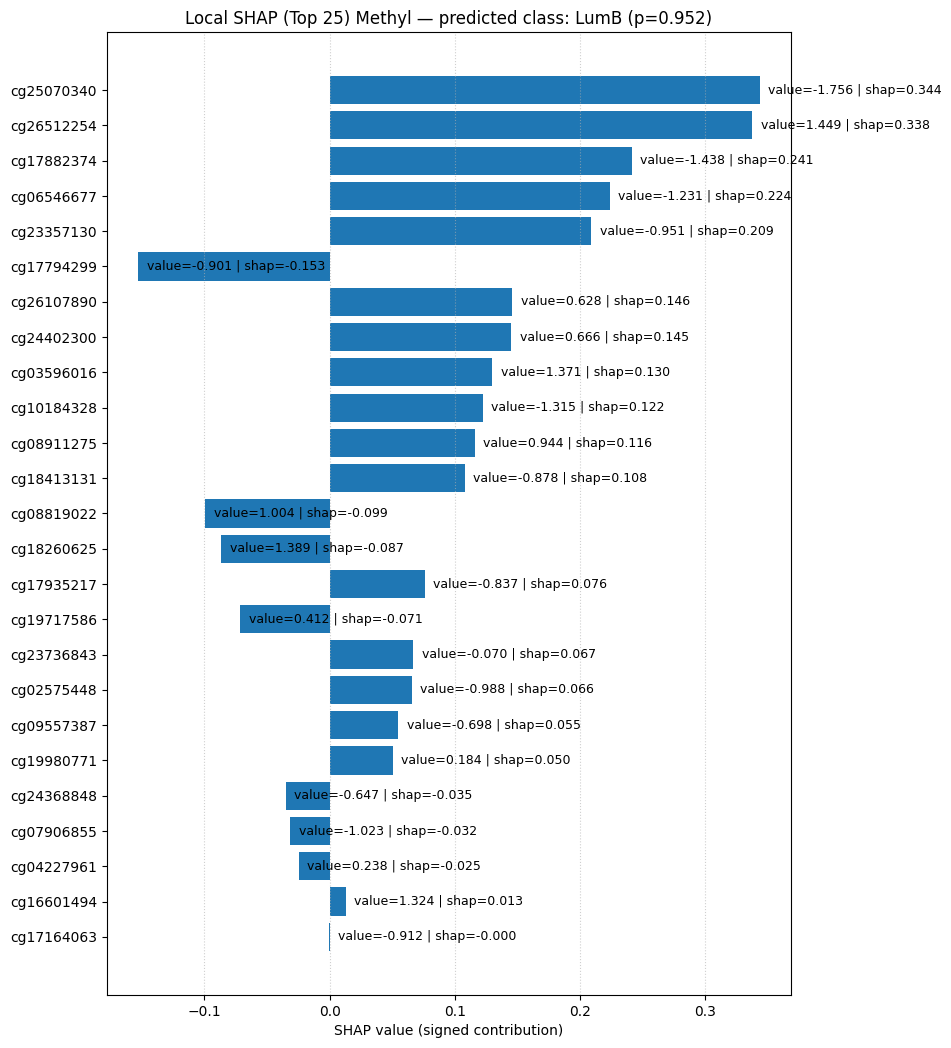

       feature     value      shap  abs_shap
11  cg25070340 -1.756365  0.343769  0.343769
6   cg26512254  1.449075  0.337556  0.337556
12  cg17882374 -1.438467  0.241409  0.241409
24  cg06546677 -1.231304  0.223803  0.223803
8   cg23357130 -0.950608  0.209252  0.209252
1   cg17794299 -0.901350 -0.153147  0.153147
13  cg26107890  0.628043  0.146012  0.146012
19  cg24402300  0.665966  0.145079  0.145079
7   cg03596016  1.370607  0.129865  0.129865
0   cg10184328 -1.315292  0.122287  0.122287


In [ ]:
# (Optional) class names
class_names = ["LumA", "LumB", "Basal", "Her2"]

# Plot & get ranked table
ranked = plot_local_shap_methyl_auto(
    shap_value=shap_values[0],
    feature_values=sample_methyl.to('cpu'),
    feature_names=top_cpg_n,
    class_prob=y_probs,
    class_names=class_names,
    top_n=25
)
print(ranked.head(10))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_local_shap_rna_auto(
    shap_value,          # np.ndarray (1, n_features, n_classes)
    feature_values,       # array-like (n_features,)
    feature_names,        # list[str] length n_features
    class_prob,           # array-like (n_classes,)
    class_names=None,     # optional list[str] length n_classes
    top_n=15,
    sample_idx=0
):
    """
    Auto-selects the predicted class via argmax(class_prob) and plots top-N local SHAP
    (signed) for the given sample. Returns a ranked table.
    """
    shap_value = np.asarray(shap_value)
    feature_values = np.asarray(feature_values).ravel()
    class_prob = np.asarray(class_prob).ravel()

    # basic checks
    if shap_value.ndim != 3:
        raise ValueError("shap_methyl must be (n_samples, n_features, n_classes)")
    n_samples, n_features, n_classes = shap_value.shape
    if len(feature_names) != n_features:
        raise ValueError("feature_names length != n_features")
    if class_prob.shape[0] != n_classes:
        raise ValueError("class_prob length != n_classes")

    # default class names
    if class_names is None:
        class_names = [f"class_{i}" for i in range(n_classes)]

    # pick predicted class
    cls_idx = int(np.argmax(class_prob))
    cls_name = class_names[cls_idx]

    # extract local SHAP for that class
    shap_vals = shap_value[sample_idx, :, cls_idx]  # (n_features,)

    # build ranking
    df = pd.DataFrame({
        "feature": feature_names,
        "value": feature_values,
        "shap": shap_vals
    })
    df["abs_shap"] = np.abs(df["shap"])
    df_top = df.sort_values("abs_shap", ascending=False).head(top_n).copy()

    # reverse for barh so the largest is on TOP
    df_top = df_top.iloc[::-1]

    # plot
    fig_h = max(3.0, 0.5 * len(df_top))
    fig, ax = plt.subplots(figsize=(12, fig_h))
    bars = ax.barh(df_top["feature"], df_top["shap"])  # default colors (no specified palette)

    ax.set_title(f"Local SHAP (Top {top_n}) RNA — predicted class: {cls_name} (p={class_prob[cls_idx]:.3f})")
    ax.set_xlabel("SHAP value (signed contribution)")
    ax.set_ylabel("")
    ax.grid(axis='x', linestyle=':', linewidth=0.8, alpha=0.6)
    plt.subplots_adjust(left=0.40, right=0.97)

    # annotate with value and shap
    xmax = np.max(np.abs(df_top["shap"])) + 1e-9
    for bar, (v, s) in zip(bars, zip(df_top["value"], df_top["shap"])):
        ax.text(bar.get_width() + 0.02 * xmax,
                bar.get_y() + bar.get_height() / 2,
                f"value={v:.3f} | shap={s:.3f}",
                va="center", ha="left", fontsize=9)

    plt.show()
    return df_top.iloc[::-1][["feature", "value", "shap", "abs_shap"]]  # return sorted high→low



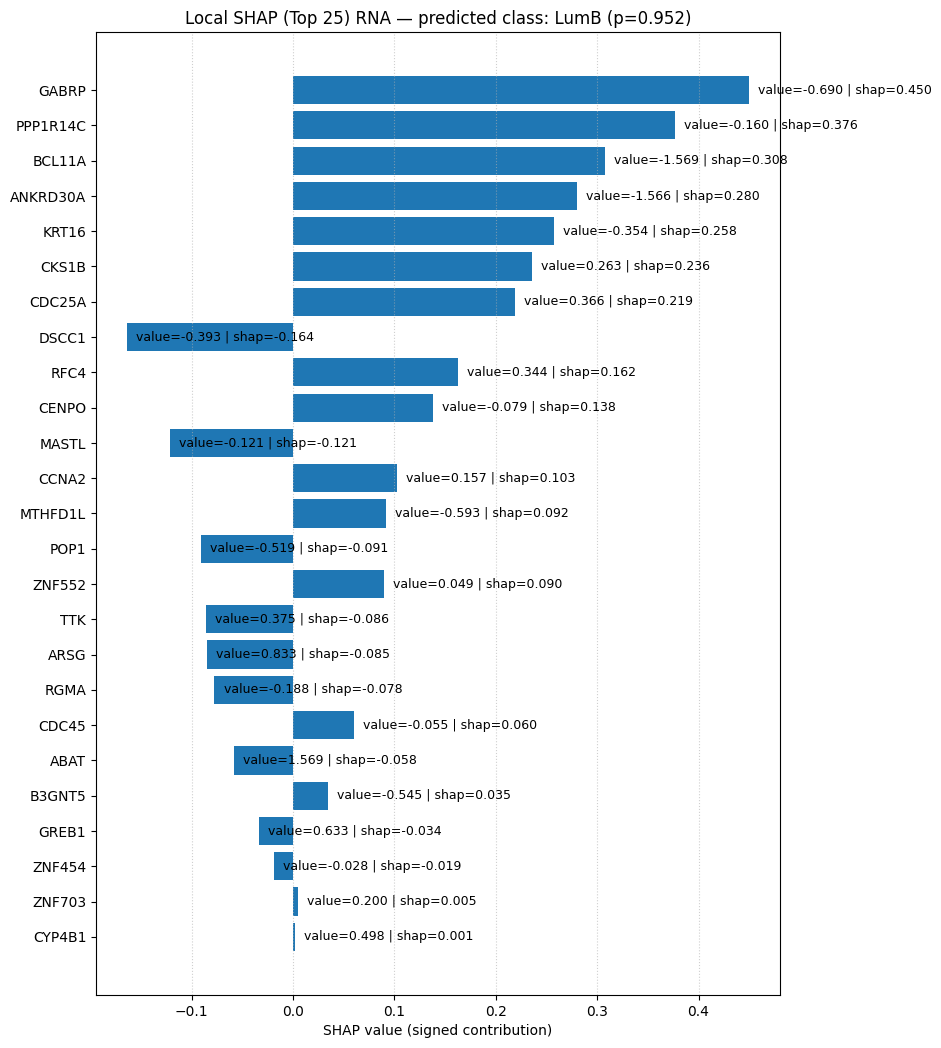

     feature     value      shap  abs_shap
6      GABRP -0.690481  0.449670  0.449670
9   PPP1R14C -0.160453  0.376315  0.376315
23    BCL11A -1.568534  0.307502  0.307502
8   ANKRD30A -1.566442  0.280242  0.280242
7      KRT16 -0.353871  0.257525  0.257525
1      CKS1B  0.263249  0.235755  0.235755
12    CDC25A  0.365843  0.218974  0.218974
21     DSCC1 -0.392830 -0.163805  0.163805
11      RFC4  0.344296  0.162367  0.162367
19     CENPO -0.079381  0.137860  0.137860


In [ ]:
# Plot & get ranked table
ranked = plot_local_shap_rna_auto(
    shap_value=shap_values[1],
    feature_values=sample_rna.to('cpu'),
    feature_names=top_rna_n,
    class_prob=y_probs,
    class_names=class_names,
    top_n=25
)
print(ranked.head(10))

#### 5 Plots

###### 5.1 Cross Validation Average Accuracy

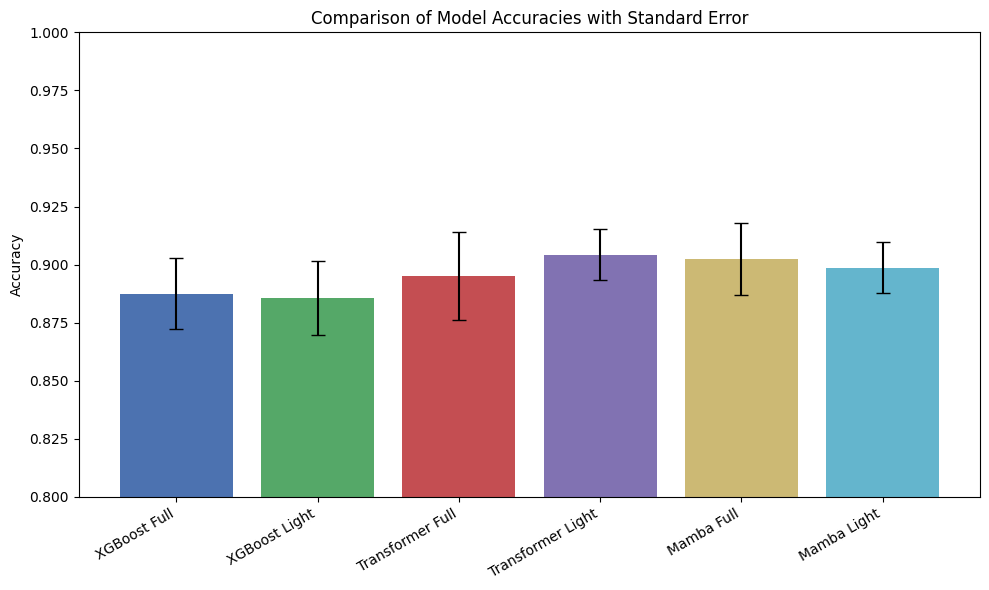

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracy scores
results = {
    "XGBoost Full": [0.9158878504672897, 0.8317757009345794, 0.8785046728971962, 0.9056603773584906, 0.9056603773584906],
    "XGBoost Light": [0.9252336448598131, 0.8504672897196262, 0.8878504672897196, 0.8490566037735849, 0.9150943396226415],
    "Transformer Full": [0.9345794392523364, 0.8317757009345794, 0.8878504672897196, 0.8867924528301887, 0.9339622641509434],
    "Transformer Light": [0.9439252336448598, 0.8785046728971962, 0.897196261682243, 0.8962264150943396, 0.9056603773584906],
    "Mamba Full": [0.9158878504672897, 0.8878504672897196, 0.897196261682243, 0.8584905660377359, 0.9528301886792453],
    "Mamba Light": [0.9252336448598131, 0.9065420560747663, 0.8785046728971962, 0.9150943396226415, 0.8679245283018868]
}

# Calculate mean and standard error
means = {k: np.mean(v) for k, v in results.items()}
std_errors = {k: np.std(v, ddof=1) / np.sqrt(len(v)) for k, v in results.items()}

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    means.keys(),
    means.values(),
    yerr=std_errors.values(),
    capsize=5,
    color=['#4C72B0','#55A868','#C44E52','#8172B2','#CCB974','#64B5CD']
)

# Labels and title
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies with Standard Error")
plt.xticks(rotation=30, ha='right')
plt.ylim(0.8, 1.0)
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipython-input-2781355654.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


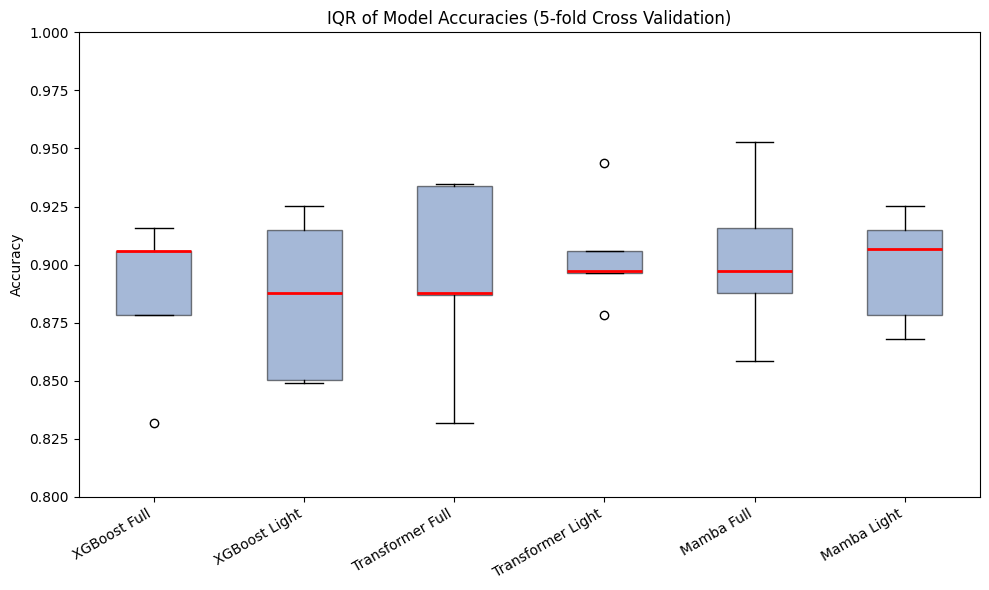

In [ ]:

# Prepare data and labels for boxplot
data = [v for v in results.values()]
labels = list(results.keys())

# Plot IQR as a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor="#4C72B0", alpha=0.5),
    medianprops=dict(color="red", linewidth=2)
)

# Labels and title
plt.ylabel("Accuracy")
plt.title("IQR of Model Accuracies (5-fold Cross Validation)")
plt.xticks(rotation=30, ha='right')
plt.ylim(0.8, 1.0)
plt.tight_layout()

# Show the plot
plt.show()

###### 5.2 Cross Validation F1 by Subtypes

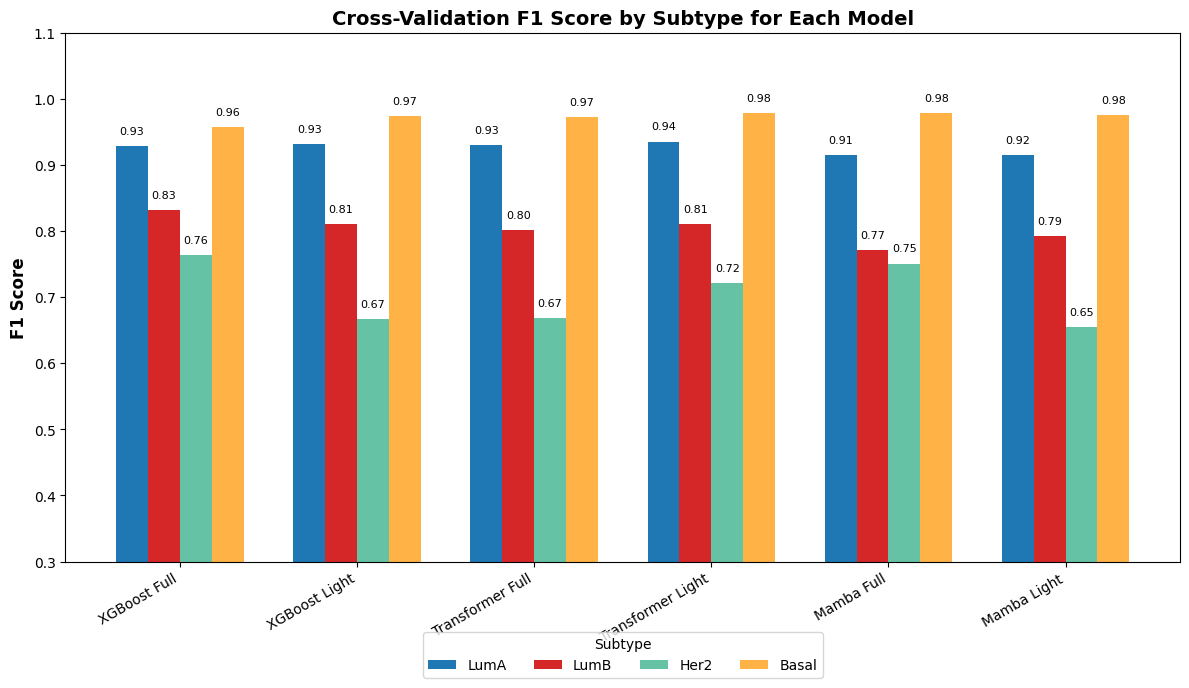

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Subtype label
subtypes = ['LumA', 'LumB', 'Her2', 'Basal']

# F1 scores
f1_scores = {
    "XGBoost Full": [
        [0.9375, 0.875, 0.6667, 1.0000],
        [0.8814, 0.6154, 0.7368, 0.9474],
        [0.9167, 0.7500, 0.5714, 0.9744],
        [0.9217, 0.8636, 0.7778, 0.9714],
        [0.9167, 0.7500, 1.0000, 1.0000]
    ],
    "XGBoost Light": [
        [0.9635, 0.8205, 0.5714, 0.9677],
        [0.8750, 0.7347, 0.5000, 0.9778],
        [0.9138, 0.8333, 0.8000, 0.9565],
        [0.8889, 0.7619, 0.5455, 0.9744],
        [0.9355, 0.8085, 0.8571, 1.0000]
    ],
    "Transformer Full": [
        [0.9524, 0.9063, 0.8571, 0.9412],
        [0.8850, 0.6667, 0.6154, 0.9500],
        [0.9217, 0.7925, 0.5000, 1.0000],
        [0.9464, 0.7843, 0.5714, 0.9714],
        [0.9412, 0.8571, 0.8000, 1.0000]
    ],
    "Transformer Light": [
        [0.9600, 0.9091, 0.8571, 1.0000],
        [0.9245, 0.7692, 0.7368, 0.9730],
        [0.9412, 0.8000, 0.3333, 0.9744],
        [0.9259, 0.8235, 0.8235, 0.9444],
        [0.9244, 0.7500, 0.8571, 1.0000]
    ],
    "Mamba Full": [
        [0.9524, 0.8710, 0.6667, 0.9412],
        [0.9074, 0.7755, 0.9000, 0.9730],
        [0.9298, 0.8302, 0.5000, 0.9744],
        [0.8952, 0.7925, 0.7500, 0.8947],
        [0.9565, 0.8889, 1.0000, 1.0000]
    ],
    "Mamba Light": [
        [0.9457, 0.8889, 0.6667, 1.0000],
        [0.9444, 0.8085, 0.8182, 0.9730],
        [0.9138, 0.7600, 0.6000, 1.0000],
        [0.9533, 0.8462, 0.7500, 0.9730],
        [0.8983, 0.7500, 0.5000, 0.9200]
    ]
}

# Put into DataFrame
records = []
for model, folds in f1_scores.items():
    for fold_id, values in enumerate(folds, start=1):
        for subtype, score in zip(subtypes, values):
            records.append([model, fold_id, subtype, score])

df = pd.DataFrame(records, columns=["Model", "Fold", "Subtype", "F1"])

#df.to_csv("f1_scores_by_model.csv", index=False)

# ---- plot ----
means = df.groupby(["Model", "Subtype"])["F1"].mean().unstack()
errors = df.groupby(["Model", "Subtype"])["F1"].sem().unstack()

x = np.arange(len(f1_scores.keys()))
width = 0.18
colors = ['#1f77b4', '#d62728', '#66c2a5', '#ffb347']

plt.figure(figsize=(12, 7))

for i, subtype in enumerate(subtypes):
    plt.bar(x + i*width, means[subtype], width,
            label=subtype, color=colors[i])

    # data label
    for j, val in enumerate(means[subtype]):
        plt.text(x[j] + i*width, val + 0.015, f"{val:.2f}",
                 ha='center', va='bottom', fontsize=8)

plt.ylabel("F1 Score", fontsize=12, fontweight="bold")
plt.title("Cross-Validation F1 Score by Subtype for Each Model", fontsize=14, fontweight="bold")
plt.xticks(x + 1.5*width, f1_scores.keys(), rotation=30, ha="right", fontsize=10)
plt.ylim(0.3, 1.1)

plt.legend(title="Subtype", loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4)
plt.tight_layout()
plt.show()


/tmp/ipython-input-4071564593.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4071564593.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4071564593.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4071564593.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


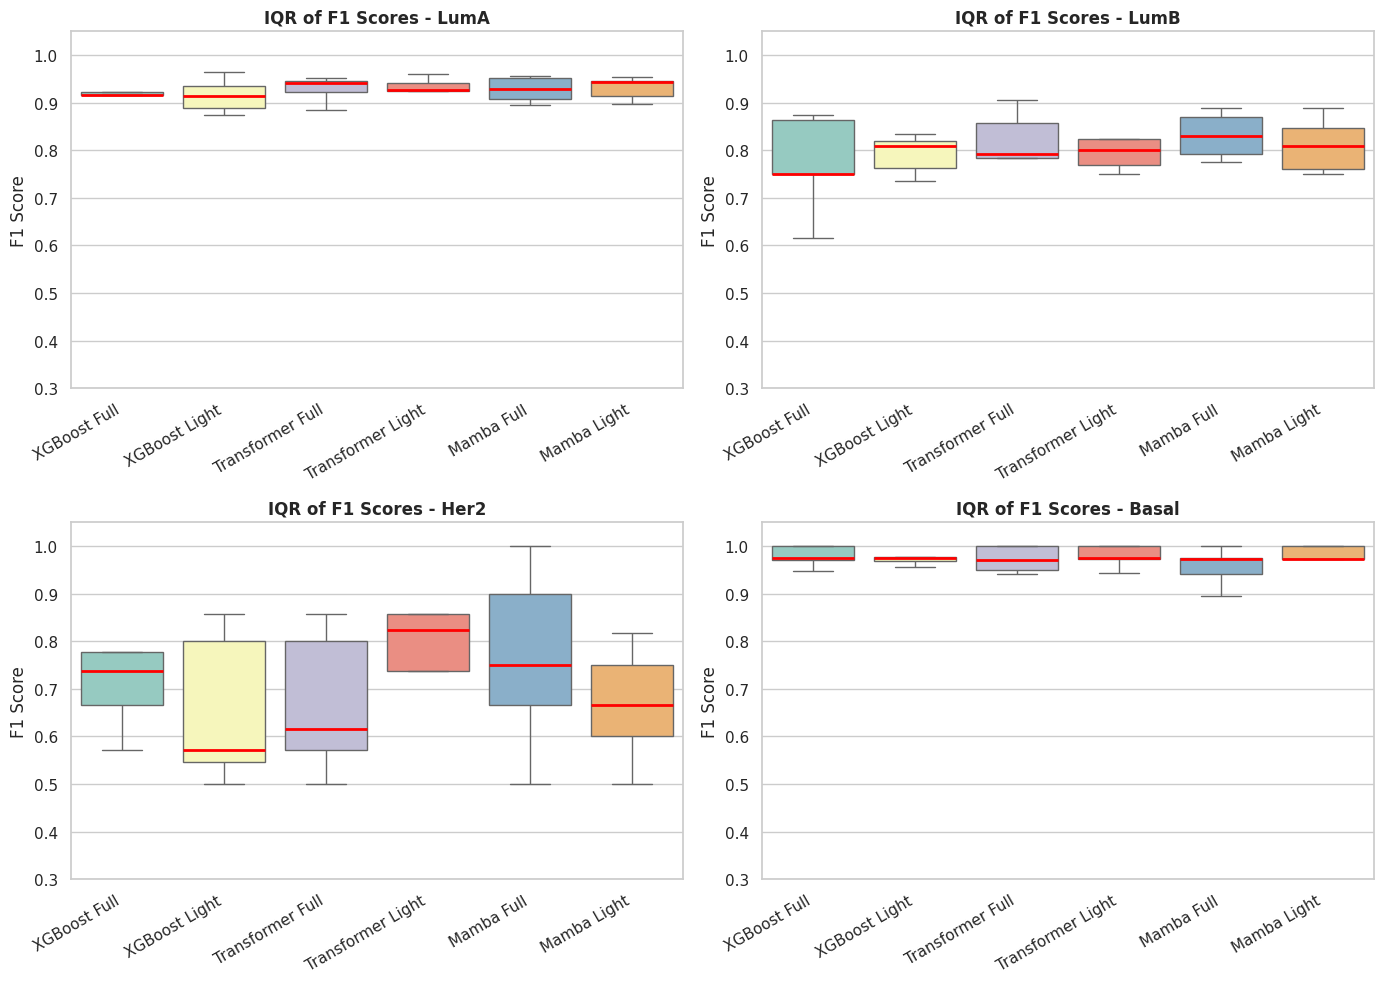

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Data: F1 scores per model & fold
# ----------------------------
f1_scores = {
    "XGBoost Full": [
        [0.9375, 0.875, 0.66666667, 1.0],
        [0.88135593, 0.61538462, 0.73684211, 0.94736842],
        [0.91666667, 0.75, 0.57142857, 0.97435897],
        [0.92173913, 0.86363636, 0.77777778, 0.97142857],
        [0.91666667, 0.75, 1.0, 1.0],
    ],
    "XGBoost Light": [
        [0.96350365, 0.82051282, 0.57142857, 0.96774194],
        [0.875, 0.73469388, 0.5, 0.97777778],
        [0.9137931, 0.83333333, 0.8, 0.95652174],
        [0.88888889, 0.76190476, 0.54545455, 0.97435897],
        [0.93548387, 0.80851064, 0.85714286, 1.0],
    ],
    "Transformer Full": [
        [0.95238095, 0.90625, 0.85714286, 0.94117647],
        [0.88495575, 0.66666667, 0.61538462, 0.95],
        [0.92173913, 0.79245283, 0.5, 1.0],
        [0.94642857, 0.78431373, 0.57142857, 0.97142857],
        [0.94117647, 0.85714286, 0.8, 1.0],
    ],
    "Transformer Light": [
        [0.96, 0.90909091, 0.85714286, 1.0],
        [0.9245283, 0.76923077, 0.73684211, 0.97297297],
        [0.94117647, 0.8, 0.33333333, 0.97435897],
        [0.92592593, 0.82352941, 0.82352941, 0.94444444],
        [0.92436975, 0.75, 0.85714286, 1.0],
    ],
    "Mamba Full": [
        [0.95238095, 0.87096774, 0.66666667, 0.94117647],
        [0.90740741, 0.7755102, 0.9, 0.97297297],
        [0.92982456, 0.83018868, 0.5, 0.97435897],
        [0.8952381, 0.79245283, 0.75, 0.89473684],
        [0.95652174, 0.88888889, 1.0, 1.0],
    ],
    "Mamba Light": [
        [0.94573643, 0.88888889, 0.66666667, 1.0],
        [0.94444444, 0.80851064, 0.81818182, 0.97297297],
        [0.9137931, 0.76, 0.6, 1.0],
        [0.95327103, 0.84615385, 0.75, 0.97297297],
        [0.89830508, 0.75, 0.5, 0.92],
    ]
}

subtypes = ["LumA", "LumB", "Her2", "Basal"]

# ----------------------------
# Build dataframe
# ----------------------------
rows = []
for model, folds in f1_scores.items():
    for fold_idx, vals in enumerate(folds, start=1):
        for subtype, f1 in zip(subtypes, vals):
            rows.append([model, fold_idx, subtype, f1])
df = pd.DataFrame(rows, columns=["Model", "Fold", "Subtype", "F1"])

# ----------------------------
# Plot: IQR boxplots per subtype
# ----------------------------
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, subtype in zip(axes, subtypes):
    dsub = df[df["Subtype"] == subtype]
    sns.boxplot(
        data=dsub, x="Model", y="F1",
        showfliers=False,
        palette="Set3",
        medianprops=dict(color="red", linewidth=2),
        ax=ax
    )
    # sns.stripplot(
    #     data=dsub, x="Model", y="F1",
    #     color="black", size=4, jitter=True, alpha=0.7, ax=ax
    # )
    ax.set_title(f"IQR of F1 Scores - {subtype}", fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("F1 Score")
    ax.set_ylim(0.3, 1.05)
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

plt.tight_layout()
plt.show()


###### 5.3 Cross Validation F1 Macro Average

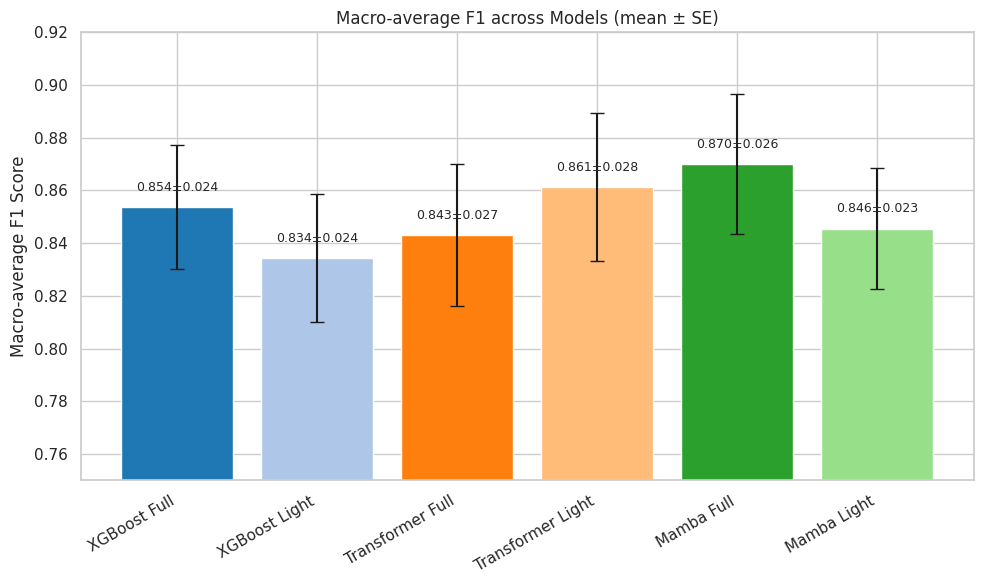

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- F1 data per fold: [LumA, LumB, Her2, Basal] ---
f1_scores = {
    "XGBoost Full": [
        [0.9375, 0.8750, 0.6667, 1.0000],
        [0.8814, 0.6154, 0.7368, 0.9474],
        [0.9167, 0.7500, 0.5714, 0.9744],
        [0.9217, 0.8636, 0.7778, 0.9714],
        [0.9167, 0.7500, 1.0000, 1.0000],
    ],
    "XGBoost Light": [
        [0.9635, 0.8205, 0.5714, 0.9677],
        [0.8750, 0.7347, 0.5000, 0.9778],
        [0.9138, 0.8333, 0.8000, 0.9565],
        [0.8889, 0.7619, 0.5455, 0.9744],
        [0.9355, 0.8085, 0.8571, 1.0000],
    ],
    "Transformer Full": [
        [0.9524, 0.9063, 0.8571, 0.9412],
        [0.8850, 0.6667, 0.6154, 0.9500],
        [0.9217, 0.7925, 0.5000, 1.0000],
        [0.9464, 0.7843, 0.5714, 0.9714],
        [0.9412, 0.8571, 0.8000, 1.0000],
    ],
    "Transformer Light": [
        [0.9600, 0.9091, 0.8571, 1.0000],
        [0.9245, 0.7692, 0.7368, 0.9730],
        [0.9412, 0.8000, 0.3333, 0.9744],
        [0.9259, 0.8235, 0.8235, 0.9444],
        [0.9244, 0.7500, 0.8571, 1.0000],
    ],
    "Mamba Full": [
        [0.9524, 0.8710, 0.6667, 0.9412],
        [0.9074, 0.7755, 0.9000, 0.9730],
        [0.9298, 0.8302, 0.5000, 0.9744],
        [0.8952, 0.7925, 0.7500, 0.8947],
        [0.9565, 0.8889, 1.0000, 1.0000],
    ],
    "Mamba Light": [
        [0.9457, 0.8889, 0.6667, 1.0000],
        [0.9444, 0.8085, 0.8182, 0.9730],
        [0.9138, 0.7600, 0.6000, 1.0000],
        [0.9533, 0.8462, 0.7500, 0.9730],
        [0.8983, 0.7500, 0.5000, 0.9200],
    ],
}

# --- Macro-average F1 per fold, then mean ± SE ---
order = ["XGBoost Full", "XGBoost Light", "Transformer Full", "Transformer Light", "Mamba Full", "Mamba Light"]
macro = {m: [np.mean(fold) for fold in f1_scores[m]] for m in order}
means = np.array([np.mean(macro[m]) for m in order])
ses   = np.array([np.std(macro[m], ddof=1) / np.sqrt(len(macro[m])) for m in order])

# --- EXACT color palette used before ---
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a']

# --- Plot ---
plt.figure(figsize=(10, 6))
bars = plt.bar(order, means, yerr=ses, capsize=5, color=colors)
plt.ylabel("Macro-average F1 Score")
plt.title("Macro-average F1 across Models (mean ± SE)")
plt.xticks(rotation=30, ha="right")

# Data labels (mean±SE)
for b, mu, se in zip(bars, means, ses):
    x = b.get_x() + b.get_width()/2
    y = b.get_height()
    plt.text(x, y + 0.005, f"{mu:.3f}±{se:.3f}", ha='center', va='bottom', fontsize=9)

plt.ylim(0.75, 0.92)   # same visual range
plt.tight_layout()
plt.show()
